In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 8.3 MB/s eta 0:00:00


✅ Building 100% Clean Test Set!
💾 Successfully exported: 'Master_Engineered_Credit_Data.csv'

--- FINAL MODEL PERFORMANCE ---
AUC Score:         0.8562
Optimal Threshold: 0.4287
Recall:            0.8312
Precision:         0.1798


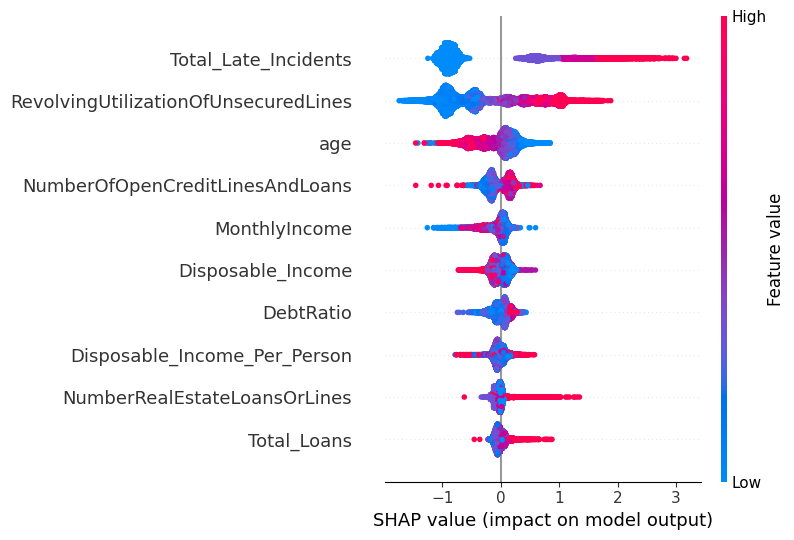

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve
import xgboost as xgb
import shap
import matplotlib.pyplot as plt


# ==========================================
# 0. LOAD THE RAW DATA 📥
# ==========================================
# (Make sure 'cs-training.csv' is uploaded to your Colab session files!)
df = pd.read_csv('cs-training.csv', index_col=0)


# ==========================================
# 1. SMART SPLITTER & IMPUTER 🧠
# ==========================================
total_defaults = (df['SeriousDlqin2yrs'] == 1).sum()
total_good = (df['SeriousDlqin2yrs'] == 0).sum()


req_test_defaults = int(np.ceil(0.2 * total_defaults))
req_test_good = int(np.ceil(0.2 * total_good))


clean_df = df.dropna()
clean_defaults = (clean_df['SeriousDlqin2yrs'] == 1).sum()
clean_good = (clean_df['SeriousDlqin2yrs'] == 0).sum()


if clean_defaults >= req_test_defaults and clean_good >= req_test_good:
    print("✅ Building 100% Clean Test Set!")
    test_defaults = clean_df[clean_df['SeriousDlqin2yrs'] == 1].sample(n=req_test_defaults, random_state=42)
    test_good = clean_df[clean_df['SeriousDlqin2yrs'] == 0].sample(n=req_test_good, random_state=42)
    test_df = pd.concat([test_defaults, test_good])
    train_df = df.drop(test_df.index)


    # Impute ONLY the training set to prevent leakage
    train_df['MonthlyIncome'] = train_df['MonthlyIncome'].fillna(
        train_df.groupby('NumberOfDependents')['MonthlyIncome'].transform('median')
    )
    train_df['MonthlyIncome'] = train_df['MonthlyIncome'].fillna(train_df['MonthlyIncome'].median())
    train_df['NumberOfDependents'] = train_df['NumberOfDependents'].fillna(train_df['NumberOfDependents'].median())
else:
    print("⚠️ Imputing entire dataset before splitting.")
    df_imputed = df.copy()
    df_imputed['MonthlyIncome'] = df_imputed['MonthlyIncome'].fillna(
        df_imputed.groupby('NumberOfDependents')['MonthlyIncome'].transform('median')
    )
    df_imputed['MonthlyIncome'] = df_imputed['MonthlyIncome'].fillna(df_imputed['MonthlyIncome'].median())
    df_imputed['NumberOfDependents'] = df_imputed['NumberOfDependents'].fillna(df_imputed['NumberOfDependents'].median())

    train_df, test_df = train_test_split(df_imputed, test_size=0.2, stratify=df_imputed['SeriousDlqin2yrs'], random_state=42)


# ==========================================
# 2. CENTRALIZED FEATURE ENGINEERING 🛠️
# ==========================================
def add_features(data):
    d = data.copy()

    # Behavior Features
    d['Total_Late_Incidents'] = d['NumberOfTime30-59DaysPastDueNotWorse'] + d['NumberOfTime60-89DaysPastDueNotWorse'] + d['NumberOfTimes90DaysLate']
    d = d.drop(columns=['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate'])

    # Polynomial & Structural Features
    d['Utilization_Squared'] = d['RevolvingUtilizationOfUnsecuredLines'] ** 2
    d['Total_Loans'] = d['NumberOfOpenCreditLinesAndLoans'] + d['NumberRealEstateLoansOrLines']

    # Financial Capacity Features 💵
    d['Monthly_Debt_Amount'] = d['DebtRatio'] * d['MonthlyIncome']
    d['Disposable_Income'] = d['MonthlyIncome'] - d['Monthly_Debt_Amount']
    d['Disposable_Income_Per_Person'] = d['Disposable_Income'] / (d['NumberOfDependents'] + 1)

    return d


train_df = add_features(train_df)
test_df = add_features(test_df)


# ==========================================
# 3. EXPORT THE FINAL DATASET TO CSV 📁
# ==========================================
# Recombine Train and Test sets into one master dataframe
final_engineered_df = pd.concat([train_df, test_df]).sort_index()


# Save it to the Colab environment
final_engineered_df.to_csv('Master_Engineered_Credit_Data.csv', index=False)
print("💾 Successfully exported: 'Master_Engineered_Credit_Data.csv'")


# ==========================================
# 4. PREPARE & TRAIN XGBOOST 🌳
# ==========================================
X_train = train_df.drop('SeriousDlqin2yrs', axis=1)
y_train = train_df['SeriousDlqin2yrs']
X_test = test_df.drop('SeriousDlqin2yrs', axis=1)
y_test = test_df['SeriousDlqin2yrs']


imbalance_ratio = (y_train == 0).sum() / (y_train == 1).sum()


xgb_model = xgb.XGBClassifier(
    max_depth=4,
    learning_rate=0.1,
    n_estimators=200,
    scale_pos_weight=imbalance_ratio,
    random_state=42,
    eval_metric='auc'
)
xgb_model.fit(X_train, y_train)


# ==========================================
# 5. BUSINESS METRICS & EVALUATION 📊
# ==========================================
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_proba)


fpr_curve, tpr_curve, thresholds = roc_curve(y_test, y_pred_proba)
optimal_idx = np.argmax(tpr_curve - fpr_curve)
optimal_threshold = thresholds[optimal_idx]


y_pred_opt = (y_pred_proba >= optimal_threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_opt).ravel()
fpr = fp / (fp + tn)


print(f"\n--- FINAL MODEL PERFORMANCE ---")
print(f"AUC Score:         {auc_score:.4f}")
print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"Recall:            {recall_score(y_test, y_pred_opt):.4f}")
print(f"Precision:         {precision_score(y_test, y_pred_opt):.4f}")


# ==========================================
# 6. SHAP EXPLAINER 🔍
# ==========================================
shap.initjs()
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)


plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, plot_type="dot", max_display=10)



✅ Building 100% Clean Test Set!
💾 Successfully exported: 'Master_Engineered_Credit_Data.csv'

--- FINAL MODEL PERFORMANCE ---
AUC Score:         0.8561
Optimal Threshold: 0.4571
Recall:            0.8111
Precision:         0.1879


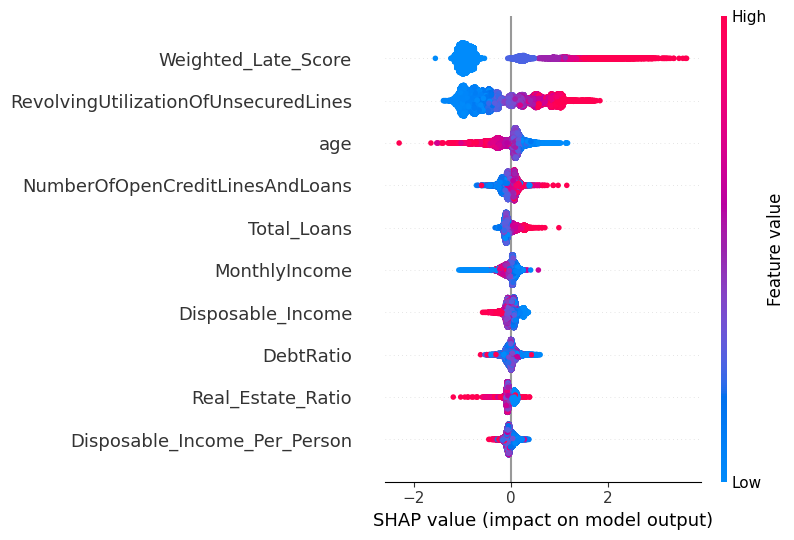

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve
import xgboost as xgb
import shap
import matplotlib.pyplot as plt

# ==========================================
# 0. LOAD THE RAW DATA 📥
# ==========================================
df = pd.read_csv('cs-training.csv', index_col=0)

# ==========================================
# 1. SMART SPLITTER & IMPUTER 🧠
# ==========================================
total_defaults = (df['SeriousDlqin2yrs'] == 1).sum()
total_good = (df['SeriousDlqin2yrs'] == 0).sum()

req_test_defaults = int(np.ceil(0.2 * total_defaults))
req_test_good = int(np.ceil(0.2 * total_good))

clean_df = df.dropna()
clean_defaults = (clean_df['SeriousDlqin2yrs'] == 1).sum()
clean_good = (clean_df['SeriousDlqin2yrs'] == 0).sum()

if clean_defaults >= req_test_defaults and clean_good >= req_test_good:
    print("✅ Building 100% Clean Test Set!")
    test_defaults = clean_df[clean_df['SeriousDlqin2yrs'] == 1].sample(n=req_test_defaults, random_state=42)
    test_good = clean_df[clean_df['SeriousDlqin2yrs'] == 0].sample(n=req_test_good, random_state=42)
    test_df = pd.concat([test_defaults, test_good])
    train_df = df.drop(test_df.index)

    # Impute ONLY the training set to prevent leakage
    train_df['MonthlyIncome'] = train_df['MonthlyIncome'].fillna(
        train_df.groupby('NumberOfDependents')['MonthlyIncome'].transform('median')
    )
    train_df['MonthlyIncome'] = train_df['MonthlyIncome'].fillna(train_df['MonthlyIncome'].median())
    train_df['NumberOfDependents'] = train_df['NumberOfDependents'].fillna(train_df['NumberOfDependents'].median())
else:
    print("⚠️ Imputing entire dataset before splitting.")
    df_imputed = df.copy()
    df_imputed['MonthlyIncome'] = df_imputed['MonthlyIncome'].fillna(
        df_imputed.groupby('NumberOfDependents')['MonthlyIncome'].transform('median')
    )
    df_imputed['MonthlyIncome'] = df_imputed['MonthlyIncome'].fillna(df_imputed['MonthlyIncome'].median())
    df_imputed['NumberOfDependents'] = df_imputed['NumberOfDependents'].fillna(df_imputed['NumberOfDependents'].median())

    train_df, test_df = train_test_split(df_imputed, test_size=0.2, stratify=df_imputed['SeriousDlqin2yrs'], random_state=42)

# ==========================================
# 2. CENTRALIZED FEATURE ENGINEERING 🛠️
# ==========================================
def add_features(data):
    d = data.copy()

    # Behavior Features
    d['Weighted_Late_Score'] = (
        (1 * d['NumberOfTime30-59DaysPastDueNotWorse']) +
        (2 * d['NumberOfTime60-89DaysPastDueNotWorse']) +
        (3 * d['NumberOfTimes90DaysLate'])
    )
    d = d.drop(columns=['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate'])

    # Debt Composition 🏠
    d['Total_Loans'] = d['NumberOfOpenCreditLinesAndLoans'] + d['NumberRealEstateLoansOrLines']
    # If they have 0 loans, assign -1 so XGBoost treats them as a separate category!
    d['Real_Estate_Ratio'] = np.where(d['Total_Loans'] > 0, d['NumberRealEstateLoansOrLines'] / d['Total_Loans'], -1)

    d['Utilization_Squared'] = d['RevolvingUtilizationOfUnsecuredLines'] ** 2

    # Financial Capacity Features 💵
    d['Monthly_Debt_Amount'] = d['DebtRatio'] * d['MonthlyIncome']
    d['Disposable_Income'] = d['MonthlyIncome'] - d['Monthly_Debt_Amount']
    d['Disposable_Income_Per_Person'] = d['Disposable_Income'] / (d['NumberOfDependents'] + 1)

    return d

train_df = add_features(train_df)
test_df = add_features(test_df)

# ==========================================
# 3. EXPORT THE FINAL DATASET TO CSV 📁
# ==========================================
final_engineered_df = pd.concat([train_df, test_df]).sort_index()
final_engineered_df.to_csv('Master_Engineered_Credit_Data.csv', index=False)
print("💾 Successfully exported: 'Master_Engineered_Credit_Data.csv'")

# ==========================================
# 4. PREPARE & TRAIN XGBOOST 🌳
# ==========================================
X_train = train_df.drop('SeriousDlqin2yrs', axis=1)
y_train = train_df['SeriousDlqin2yrs']
X_test = test_df.drop('SeriousDlqin2yrs', axis=1)
y_test = test_df['SeriousDlqin2yrs']

imbalance_ratio = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = xgb.XGBClassifier(
    max_depth=4,
    learning_rate=0.1,
    n_estimators=200,
    scale_pos_weight=imbalance_ratio,
    random_state=42,
    eval_metric='auc'
)
xgb_model.fit(X_train, y_train)

# ==========================================
# 5. BUSINESS METRICS & EVALUATION 📊
# ==========================================
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_proba)

fpr_curve, tpr_curve, thresholds = roc_curve(y_test, y_pred_proba)
optimal_idx = np.argmax(tpr_curve - fpr_curve)
optimal_threshold = thresholds[optimal_idx]

y_pred_opt = (y_pred_proba >= optimal_threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_opt).ravel()
fpr = fp / (fp + tn)

print(f"\n--- FINAL MODEL PERFORMANCE ---")
print(f"AUC Score:         {auc_score:.4f}")
print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"Recall:            {recall_score(y_test, y_pred_opt):.4f}")
print(f"Precision:         {precision_score(y_test, y_pred_opt):.4f}")

# ==========================================
# 6. SHAP EXPLAINER 🔍
# ==========================================
shap.initjs()
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, plot_type="dot", max_display=10)



✅ Building 100% Clean Test Set!
💾 Successfully exported: 'Master_Engineered_Credit_Data.csv'

⏳ Starting the XGBoost Hyperparameter Search... (This may take a few minutes!)
Fitting 3 folds for each of 20 candidates, totalling 60 fits

🏆 THE EXACT WINNING SETTINGS ARE:
{'colsample_bytree': np.float64(0.9499584735208493), 'learning_rate': np.float64(0.042939284166476695), 'max_depth': 3, 'n_estimators': 263, 'subsample': np.float64(0.7546708263364187)}

--- FINAL TUNED MODEL PERFORMANCE ---
AUC Score:         0.8591
Optimal Threshold: 0.5118
Recall:            0.7866
Precision:         0.2042
False Alarms(FPR): 0.2196


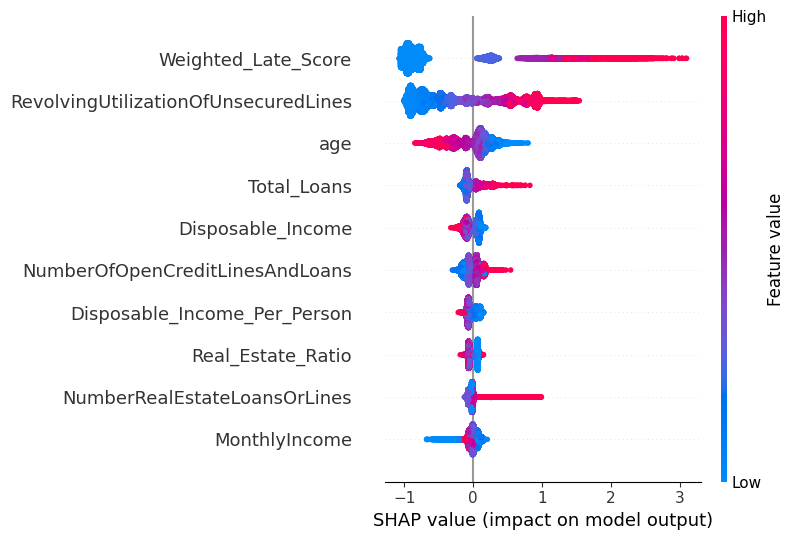

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
from scipy.stats import randint, uniform

# ==========================================
# 0. LOAD THE RAW DATA 📥
# ==========================================
# Assuming 'cs-training.csv' is in your working directory
df = pd.read_csv('cs-training.csv', index_col=0)

# ==========================================
# 1. SMART SPLITTER & IMPUTER 🧠
# ==========================================
total_defaults = (df['SeriousDlqin2yrs'] == 1).sum()
total_good = (df['SeriousDlqin2yrs'] == 0).sum()

req_test_defaults = int(np.ceil(0.2 * total_defaults))
req_test_good = int(np.ceil(0.2 * total_good))

clean_df = df.dropna()
clean_defaults = (clean_df['SeriousDlqin2yrs'] == 1).sum()
clean_good = (clean_df['SeriousDlqin2yrs'] == 0).sum()

if clean_defaults >= req_test_defaults and clean_good >= req_test_good:
    print("✅ Building 100% Clean Test Set!")
    test_defaults = clean_df[clean_df['SeriousDlqin2yrs'] == 1].sample(n=req_test_defaults, random_state=42)
    test_good = clean_df[clean_df['SeriousDlqin2yrs'] == 0].sample(n=req_test_good, random_state=42)
    test_df = pd.concat([test_defaults, test_good])
    train_df = df.drop(test_df.index)

    # Impute ONLY the training set to prevent leakage
    train_df['MonthlyIncome'] = train_df['MonthlyIncome'].fillna(
        train_df.groupby('NumberOfDependents')['MonthlyIncome'].transform('median')
    )
    train_df['MonthlyIncome'] = train_df['MonthlyIncome'].fillna(train_df['MonthlyIncome'].median())
    train_df['NumberOfDependents'] = train_df['NumberOfDependents'].fillna(train_df['NumberOfDependents'].median())
else:
    print("⚠️ Imputing entire dataset before splitting.")
    df_imputed = df.copy()
    df_imputed['MonthlyIncome'] = df_imputed['MonthlyIncome'].fillna(
        df_imputed.groupby('NumberOfDependents')['MonthlyIncome'].transform('median')
    )
    df_imputed['MonthlyIncome'] = df_imputed['MonthlyIncome'].fillna(df_imputed['MonthlyIncome'].median())
    df_imputed['NumberOfDependents'] = df_imputed['NumberOfDependents'].fillna(df_imputed['NumberOfDependents'].median())

    train_df, test_df = train_test_split(df_imputed, test_size=0.2, stratify=df_imputed['SeriousDlqin2yrs'], random_state=42)

# ==========================================
# 2. CENTRALIZED FEATURE ENGINEERING 🛠️
# ==========================================
def add_features(data):
    d = data.copy()

    # Behavior Features: Escalating Risk Penalty
    d['Weighted_Late_Score'] = (
        (1 * d['NumberOfTime30-59DaysPastDueNotWorse']) +
        (2 * d['NumberOfTime60-89DaysPastDueNotWorse']) +
        (3 * d['NumberOfTimes90DaysLate'])
    )
    d = d.drop(columns=['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate'])

    # Debt Composition: Thin File detection (-1)
    d['Total_Loans'] = d['NumberOfOpenCreditLinesAndLoans'] + d['NumberRealEstateLoansOrLines']
    d['Real_Estate_Ratio'] = np.where(d['Total_Loans'] > 0, d['NumberRealEstateLoansOrLines'] / d['Total_Loans'], -1)

    d['Utilization_Squared'] = d['RevolvingUtilizationOfUnsecuredLines'] ** 2

    # Financial Capacity Features
    d['Monthly_Debt_Amount'] = d['DebtRatio'] * d['MonthlyIncome']
    d['Disposable_Income'] = d['MonthlyIncome'] - d['Monthly_Debt_Amount']
    d['Disposable_Income_Per_Person'] = d['Disposable_Income'] / (d['NumberOfDependents'] + 1)

    return d

train_df = add_features(train_df)
test_df = add_features(test_df)

# ==========================================
# 3. EXPORT THE FINAL DATASET TO CSV 📁
# ==========================================
final_engineered_df = pd.concat([train_df, test_df]).sort_index()
final_engineered_df.to_csv('Master_Engineered_Credit_Data.csv', index=False)
print("💾 Successfully exported: 'Master_Engineered_Credit_Data.csv'")

# ==========================================
# 4. PREPARE DATA FOR MODELING
# ==========================================
X_train = train_df.drop('SeriousDlqin2yrs', axis=1)
y_train = train_df['SeriousDlqin2yrs']
X_test = test_df.drop('SeriousDlqin2yrs', axis=1)
y_test = test_df['SeriousDlqin2yrs']

imbalance_ratio = (y_train == 0).sum() / (y_train == 1).sum()

# ==========================================
# 5. XGBOOST HYPERPARAMETER TUNING 🎛️
# ==========================================
print("\n⏳ Starting the XGBoost Hyperparameter Search... (This may take a few minutes!)")

# Define the continuous searching ranges
param_distributions = {
    'max_depth': randint(3, 7),               # Trees between 3 and 6 levels deep
    'learning_rate': uniform(0.01, 0.19),     # Any exact decimal from 0.01 to 0.20
    'n_estimators': randint(100, 300),        # Any team size from 100 to 299 trees
    'subsample': uniform(0.7, 0.3),           # Row blindfolding between 70% and 100%
    'colsample_bytree': uniform(0.7, 0.3)     # Column blindfolding between 70% and 100%
}

base_xgb = xgb.XGBClassifier(
    scale_pos_weight=imbalance_ratio,
    random_state=42,
    eval_metric='auc'
)

# Set up the Random Search
random_search = RandomizedSearchCV(
    estimator=base_xgb,
    param_distributions=param_distributions,
    n_iter=20,  # Test 20 completely random combinations
    scoring='roc_auc',
    cv=3,       # 3-Fold Cross Validation
    verbose=1,  # Keep output relatively clean
    random_state=42,
    n_jobs=-1   # Use all available CPU cores
)

# Train the Searcher
random_search.fit(X_train, y_train)

# Extract the Ultimate Winner
best_xgb_model = random_search.best_estimator_

print("\n🏆 THE EXACT WINNING SETTINGS ARE:")
print(random_search.best_params_)

# ==========================================
# 6. BUSINESS METRICS & EVALUATION 📊
# ==========================================
y_pred_proba_best = best_xgb_model.predict_proba(X_test)[:, 1]
best_auc = roc_auc_score(y_test, y_pred_proba_best)

fpr_curve, tpr_curve, thresholds = roc_curve(y_test, y_pred_proba_best)
optimal_idx = np.argmax(tpr_curve - fpr_curve)
best_threshold = thresholds[optimal_idx]

y_pred_opt_best = (y_pred_proba_best >= best_threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_opt_best).ravel()
fpr = fp / (fp + tn)

print(f"\n--- FINAL TUNED MODEL PERFORMANCE ---")
print(f"AUC Score:         {best_auc:.4f}")
print(f"Optimal Threshold: {best_threshold:.4f}")
print(f"Recall:            {recall_score(y_test, y_pred_opt_best):.4f}")
print(f"Precision:         {precision_score(y_test, y_pred_opt_best):.4f}")
print(f"False Alarms(FPR): {fpr:.4f}")

# ==========================================
# 7. SHAP EXPLAINER 🔍
# ==========================================
shap.initjs()
explainer = shap.TreeExplainer(best_xgb_model)
shap_values = explainer.shap_values(X_test)

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, plot_type="dot", max_display=10)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
from scipy.stats import randint, uniform

# ==========================================
# 0. LOAD RAW DATA 📥
# ==========================================
df = pd.read_csv('cs-training.csv', index_col=0)

# ==========================================
# 1. EXPLORATORY DATA ANALYSIS (EDA) REPORT 📊
# ==========================================
print("========== 📊 INITIAL EDA REPORT ==========")
# 1. Imbalance Check
default_pct = df['SeriousDlqin2yrs'].mean() * 100
print(f"Target Imbalance:    {default_pct:.2f}% of dataset are Defaulters.")

# 2. Missing Data Check
missing_income = df['MonthlyIncome'].isnull().sum()
missing_deps = df['NumberOfDependents'].isnull().sum()
print(f"Missing Income:      {missing_income} rows ({(missing_income/len(df))*100:.1f}%)")
print(f"Missing Dependents:  {missing_deps} rows ({(missing_deps/len(df))*100:.1f}%)")

# 3. Outlier Check (Kaggle quirk: 96 and 98 are system errors for late payments)
weird_lates = df[df['NumberOfTimes90DaysLate'] >= 96].shape[0]
print(f"Data Oddities:       {weird_lates} rows have impossible late payment counts (>= 96).")
print("===========================================\n")

# ==========================================
# 2. SMART SPLITTER & IMPUTER 🧠
# ==========================================
total_defaults = (df['SeriousDlqin2yrs'] == 1).sum()
total_good = (df['SeriousDlqin2yrs'] == 0).sum()

req_test_defaults = int(np.ceil(0.2 * total_defaults))
req_test_good = int(np.ceil(0.2 * total_good))

clean_df = df.dropna()
clean_defaults = (clean_df['SeriousDlqin2yrs'] == 1).sum()
clean_good = (clean_df['SeriousDlqin2yrs'] == 0).sum()

if clean_defaults >= req_test_defaults and clean_good >= req_test_good:
    test_defaults = clean_df[clean_df['SeriousDlqin2yrs'] == 1].sample(n=req_test_defaults, random_state=42)
    test_good = clean_df[clean_df['SeriousDlqin2yrs'] == 0].sample(n=req_test_good, random_state=42)
    test_df = pd.concat([test_defaults, test_good])
    train_df = df.drop(test_df.index)

    # Impute ONLY training set
    train_df['MonthlyIncome'] = train_df['MonthlyIncome'].fillna(train_df.groupby('NumberOfDependents')['MonthlyIncome'].transform('median'))
    train_df['MonthlyIncome'] = train_df['MonthlyIncome'].fillna(train_df['MonthlyIncome'].median())
    train_df['NumberOfDependents'] = train_df['NumberOfDependents'].fillna(train_df['NumberOfDependents'].median())
else:
    df_imputed = df.copy()
    df_imputed['MonthlyIncome'] = df_imputed['MonthlyIncome'].fillna(df_imputed.groupby('NumberOfDependents')['MonthlyIncome'].transform('median'))
    df_imputed['MonthlyIncome'] = df_imputed['MonthlyIncome'].fillna(df_imputed['MonthlyIncome'].median())
    df_imputed['NumberOfDependents'] = df_imputed['NumberOfDependents'].fillna(df_imputed['NumberOfDependents'].median())
    train_df, test_df = train_test_split(df_imputed, test_size=0.2, stratify=df_imputed['SeriousDlqin2yrs'], random_state=42)

# ==========================================
# 3. CENTRALIZED FEATURE ENGINEERING 🛠️
# ==========================================
def add_features(data):
    d = data.copy()

    # Behavior Features
    d['Weighted_Late_Score'] = (
        (1 * d['NumberOfTime30-59DaysPastDueNotWorse']) +
        (2 * d['NumberOfTime60-89DaysPastDueNotWorse']) +
        (3 * d['NumberOfTimes90DaysLate'])
    )
    d = d.drop(columns=['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate'])

    # *** NEW: The Catastrophe Interaction Feature ***
    d['Critical_Risk_Index'] = d['RevolvingUtilizationOfUnsecuredLines'] * d['Weighted_Late_Score']

    # Debt Composition
    d['Total_Loans'] = d['NumberOfOpenCreditLinesAndLoans'] + d['NumberRealEstateLoansOrLines']
    d['Real_Estate_Ratio'] = np.where(d['Total_Loans'] > 0, d['NumberRealEstateLoansOrLines'] / d['Total_Loans'], -1)

    d['Utilization_Squared'] = d['RevolvingUtilizationOfUnsecuredLines'] ** 2

    # Financial Capacity
    d['Monthly_Debt_Amount'] = d['DebtRatio'] * d['MonthlyIncome']
    d['Disposable_Income'] = d['MonthlyIncome'] - d['Monthly_Debt_Amount']
    d['Disposable_Income_Per_Person'] = d['Disposable_Income'] / (d['NumberOfDependents'] + 1)

    return d

train_df = add_features(train_df)
test_df = add_features(test_df)

# ==========================================
# 4. PREPARE & TUNE XGBOOST 🎛️
# ==========================================
X_train = train_df.drop('SeriousDlqin2yrs', axis=1)
y_train = train_df['SeriousDlqin2yrs']
X_test = test_df.drop('SeriousDlqin2yrs', axis=1)
y_test = test_df['SeriousDlqin2yrs']

imbalance_ratio = (y_train == 0).sum() / (y_train == 1).sum()

param_distributions = {
    'max_depth': randint(3, 7),
    'learning_rate': uniform(0.01, 0.19),
    'n_estimators': randint(100, 300),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3)
}

base_xgb = xgb.XGBClassifier(scale_pos_weight=imbalance_ratio, random_state=42, eval_metric='auc')

print("⏳ Tuning model... (Please wait)")
random_search = RandomizedSearchCV(base_xgb, param_distributions, n_iter=10, scoring='roc_auc', cv=3, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)
best_xgb_model = random_search.best_estimator_

# ==========================================
# 5. BUSINESS METRICS & CONFUSION MATRIX 📈
# ==========================================
y_pred_proba = best_xgb_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_proba)

fpr_curve, tpr_curve, thresholds = roc_curve(y_test, y_pred_proba)
optimal_idx = np.argmax(tpr_curve - fpr_curve)
optimal_threshold = thresholds[optimal_idx]

y_pred_opt = (y_pred_proba >= optimal_threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_opt).ravel()

# Calculate raw rates
tpr = tp / (tp + fn) # Same as Recall
fpr = fp / (fp + tn) # False Alarm Rate

print("\n========== 🏆 FINAL BUSINESS METRICS ==========")
print(f"AUC Score:             {auc_score:.4f}")
print(f"Optimal Threshold:     {optimal_threshold:.4f}")
print(f"Accuracy:              {accuracy_score(y_test, y_pred_opt):.4f}")
print(f"Precision:             {precision_score(y_test, y_pred_opt):.4f}")
print(f"Recall (TPR):          {tpr:.4f}  <-- Caught {tpr*100:.1f}% of defaults!")
print(f"False Alarm Rate (FPR):{fpr:.4f}  <-- Annoyed {fpr*100:.1f}% of good customers.")
print("\n--- 🧮 CONFUSION MATRIX ---")
print(f"True Negatives (Safe correctly predicted):     {tn}")
print(f"False Positives (Safe called Defaulters):      {fp}  <-- False Alarms")
print(f"False Negatives (Defaulters missed by AI):     {fn}  <-- Danger!")
print(f"True Positives (Defaulters caught by AI):      {tp}")
print("===============================================")

========== 📊 INITIAL EDA REPORT ==========
Target Imbalance:    6.68% of dataset are Defaulters.
Missing Income:      29731 rows (19.8%)
Missing Dependents:  3924 rows (2.6%)
Data Oddities:       269 rows have impossible late payment counts (>= 96).

⏳ Tuning model... (Please wait)

========== 🏆 FINAL BUSINESS METRICS ==========
AUC Score:             0.8586
Optimal Threshold:     0.4866
Accuracy:              0.7646
Precision:             0.1942
Recall (TPR):          0.8001  <-- Caught 80.0% of defaults!
False Alarm Rate (FPR):0.2379  <-- Annoyed 23.8% of good customers.

--- 🧮 CONFUSION MATRIX ---
True Negatives (Safe correctly predicted):     21334
False Positives (Safe called Defaulters):      6661  <-- False Alarms
False Negatives (Defaulters missed by AI):     401  <-- Danger!
True Positives (Defaulters caught by AI):      1605


========== 📊 INITIAL EDA REPORT ==========
Target Imbalance:    6.68% of dataset are Defaulters.
Missing Income:      29731 rows (19.8%)
Data Oddities:       269 rows have system errors (>= 96 lates).

✅ Building 100% Clean Test Set!
💾 Data Exported: 'Final_Credit_Risk_Data.csv'

⏳ Tuning Model... (Finding the mathematical bullseye)

========== 🏆 FINAL MODEL PERFORMANCE ==========
Winning Params:        {'colsample_bytree': np.float64(0.6624074561769746), 'learning_rate': np.float64(0.039638958863878505), 'max_depth': 5, 'n_estimators': 187, 'subsample': np.float64(0.7334834444556088)}
AUC Score:             0.8581
Optimal Threshold:     0.4882
Recall (TPR):          0.7921 (Caught 1589 defaults)
False Alarm Rate (FPR):0.2234 (Annoyed 6254 good clients)



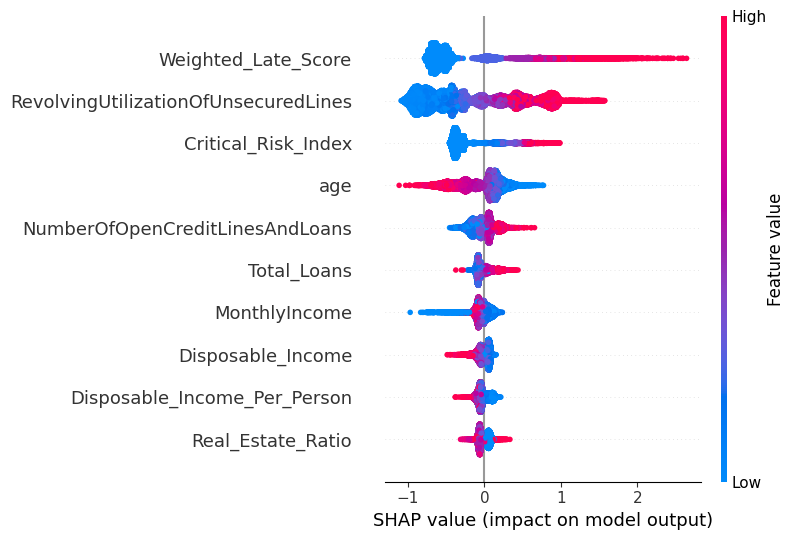

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
from scipy.stats import randint, uniform

# ==========================================
# 0. LOAD RAW DATA 📥
# ==========================================
# Ensure 'cs-training.csv' is uploaded to your environment
df = pd.read_csv('cs-training.csv', index_col=0)

# ==========================================
# 1. EXPLORATORY DATA ANALYSIS (EDA) REPORT 📊
# ==========================================
print("========== 📊 INITIAL EDA REPORT ==========")
default_pct = df['SeriousDlqin2yrs'].mean() * 100
print(f"Target Imbalance:    {default_pct:.2f}% of dataset are Defaulters.")

missing_income = df['MonthlyIncome'].isnull().sum()
print(f"Missing Income:      {missing_income} rows ({(missing_income/len(df))*100:.1f}%)")

weird_lates = df[df['NumberOfTimes90DaysLate'] >= 96].shape[0]
print(f"Data Oddities:       {weird_lates} rows have system errors (>= 96 lates).")
print("===========================================\n")

# ==========================================
# 2. SMART SPLITTER & IMPUTER 🧠
# ==========================================
# This logic ensures the test set is 100% real data (no imputed values)
total_defaults = (df['SeriousDlqin2yrs'] == 1).sum()
total_good = (df['SeriousDlqin2yrs'] == 0).sum()

req_test_defaults = int(np.ceil(0.2 * total_defaults))
req_test_good = int(np.ceil(0.2 * total_good))

clean_df = df.dropna()
clean_defaults = (clean_df['SeriousDlqin2yrs'] == 1).sum()
clean_good = (clean_df['SeriousDlqin2yrs'] == 0).sum()

if clean_defaults >= req_test_defaults and clean_good >= req_test_good:
    print("✅ Building 100% Clean Test Set!")
    test_defaults = clean_df[clean_df['SeriousDlqin2yrs'] == 1].sample(n=req_test_defaults, random_state=42)
    test_good = clean_df[clean_df['SeriousDlqin2yrs'] == 0].sample(n=req_test_good, random_state=42)
    test_df = pd.concat([test_defaults, test_good])
    train_df = df.drop(test_df.index)

    # Impute Training Set ONLY
    train_df['MonthlyIncome'] = train_df['MonthlyIncome'].fillna(
        train_df.groupby('NumberOfDependents')['MonthlyIncome'].transform('median')
    )
    train_df['MonthlyIncome'] = train_df['MonthlyIncome'].fillna(train_df['MonthlyIncome'].median())
    train_df['NumberOfDependents'] = train_df['NumberOfDependents'].fillna(train_df['NumberOfDependents'].median())
else:
    print("⚠️ Imputing entire dataset before splitting.")
    df_imputed = df.copy()
    df_imputed['MonthlyIncome'] = df_imputed['MonthlyIncome'].fillna(df_imputed.groupby('NumberOfDependents')['MonthlyIncome'].transform('median'))
    df_imputed['MonthlyIncome'] = df_imputed['MonthlyIncome'].fillna(df_imputed['MonthlyIncome'].median())
    df_imputed['NumberOfDependents'] = df_imputed['NumberOfDependents'].fillna(df_imputed['NumberOfDependents'].median())
    train_df, test_df = train_test_split(df_imputed, test_size=0.2, stratify=df_imputed['SeriousDlqin2yrs'], random_state=42)

# ==========================================
# 3. CENTRALIZED FEATURE ENGINEERING 🛠️
# ==========================================
def add_features(data):
    d = data.copy()

    # A. Weighted Late Score (1a + 2b + 3c)
    d['Weighted_Late_Score'] = (
        (1 * d['NumberOfTime30-59DaysPastDueNotWorse']) +
        (2 * d['NumberOfTime60-89DaysPastDueNotWorse']) +
        (3 * d['NumberOfTimes90DaysLate'])
    )

    # B. Critical Risk Interaction (Utilization x Late Score)
    d['Critical_Risk_Index'] = d['RevolvingUtilizationOfUnsecuredLines'] * d['Weighted_Late_Score']

    # C. Real Estate Ratio & Thin File Detection (-1 flag)
    d['Total_Loans'] = d['NumberOfOpenCreditLinesAndLoans'] + d['NumberRealEstateLoansOrLines']
    d['Real_Estate_Ratio'] = np.where(d['Total_Loans'] > 0, d['NumberRealEstateLoansOrLines'] / d['Total_Loans'], -1)

    # D. Financial Strain (Disposable Income per Person)
    d['Monthly_Debt_Amount'] = d['DebtRatio'] * d['MonthlyIncome']
    d['Disposable_Income'] = d['MonthlyIncome'] - d['Monthly_Debt_Amount']
    d['Disposable_Income_Per_Person'] = d['Disposable_Income'] / (d['NumberOfDependents'] + 1)

    # Drop original late columns to avoid redundancy
    d = d.drop(columns=['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate'])

    return d

train_df = add_features(train_df)
test_df = add_features(test_df)

# ==========================================
# 4. EXPORT ENGINEERED DATA 📁
# ==========================================
final_df = pd.concat([train_df, test_df]).sort_index()
final_df.to_csv('Final_Credit_Risk_Data.csv', index=False)
print("💾 Data Exported: 'Final_Credit_Risk_Data.csv'")

# ==========================================
# 5. HYPERPARAMETER TUNING (RANDOMIZED SEARCH) 🎛️
# ==========================================
X_train = train_df.drop('SeriousDlqin2yrs', axis=1)
y_train = train_df['SeriousDlqin2yrs']
X_test = test_df.drop('SeriousDlqin2yrs', axis=1)
y_test = test_df['SeriousDlqin2yrs']

imbalance_ratio = (y_train == 0).sum() / (y_train == 1).sum()

param_distributions = {
    'max_depth': randint(3, 7),
    'learning_rate': uniform(0.01, 0.19),
    'n_estimators': randint(100, 400),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4)
}

base_xgb = xgb.XGBClassifier(scale_pos_weight=imbalance_ratio, random_state=42, eval_metric='auc')

print("\n⏳ Tuning Model... (Finding the mathematical bullseye)")
random_search = RandomizedSearchCV(base_xgb, param_distributions, n_iter=15, scoring='roc_auc', cv=3, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

# ==========================================
# 6. FINAL EVALUATION & BUSINESS METRICS 🏆
# ==========================================
y_probs = best_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_probs)

# Find optimal business threshold
fpr_c, tpr_c, thresh = roc_curve(y_test, y_probs)
opt_idx = np.argmax(tpr_c - fpr_c)
best_t = thresh[opt_idx]

y_pred = (y_probs >= best_t).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print("\n========== 🏆 FINAL MODEL PERFORMANCE ==========")
print(f"Winning Params:        {random_search.best_params_}")
print(f"AUC Score:             {auc:.4f}")
print(f"Optimal Threshold:     {best_t:.4f}")
print(f"Recall (TPR):          {tp/(tp+fn):.4f} (Caught {tp} defaults)")
print(f"False Alarm Rate (FPR):{fp/(fp+tn):.4f} (Annoyed {fp} good clients)")
print("================================================\n")

# ==========================================
# 7. SHAP GLOBAL EXPLAINABILITY 🔍
# ==========================================
shap.initjs()
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, plot_type="dot", max_display=10)

[I 2026-02-17 13:55:15,675] A new study created in memory with name: no-name-d56be800-80ca-43b5-973c-f260e43a42e0


⏳ Starting Bayesian Optimization (Optuna)... Hunting for the absolute optimum.


[I 2026-02-17 13:55:36,808] Trial 0 finished with value: 0.8571667419709968 and parameters: {'max_depth': 5, 'learning_rate': 0.14605790893783158, 'n_estimators': 203, 'subsample': 0.8620321278891034, 'colsample_bytree': 0.6831518370805356}. Best is trial 0 with value: 0.8571667419709968.
[I 2026-02-17 13:55:41,631] Trial 1 finished with value: 0.8465249652091167 and parameters: {'max_depth': 7, 'learning_rate': 0.1581391386815675, 'n_estimators': 134, 'subsample': 0.7506750907395497, 'colsample_bytree': 0.6185632576553408}. Best is trial 0 with value: 0.8571667419709968.
[I 2026-02-17 13:55:51,113] Trial 2 finished with value: 0.8649579939129391 and parameters: {'max_depth': 3, 'learning_rate': 0.09093229576330379, 'n_estimators': 375, 'subsample': 0.741213102985667, 'colsample_bytree': 0.9676284635523976}. Best is trial 2 with value: 0.8649579939129391.
[I 2026-02-17 13:55:55,664] Trial 3 finished with value: 0.8623318230581235 and parameters: {'max_depth': 4, 'learning_rate': 0.1333


========== 🏆 FINAL TUNED PERFORMANCE ==========
Best Params:           {'max_depth': 4, 'learning_rate': 0.0373069957554881, 'n_estimators': 250, 'subsample': 0.7667366350181836, 'colsample_bytree': 0.7970066378593709}
AUC Score:             0.8585
Optimal Threshold:     0.4790
Recall (TPR):          0.8041 (Caught 1613 defaults)
False Alarm Rate (FPR):0.2392 (Annoyed 6696 good clients)


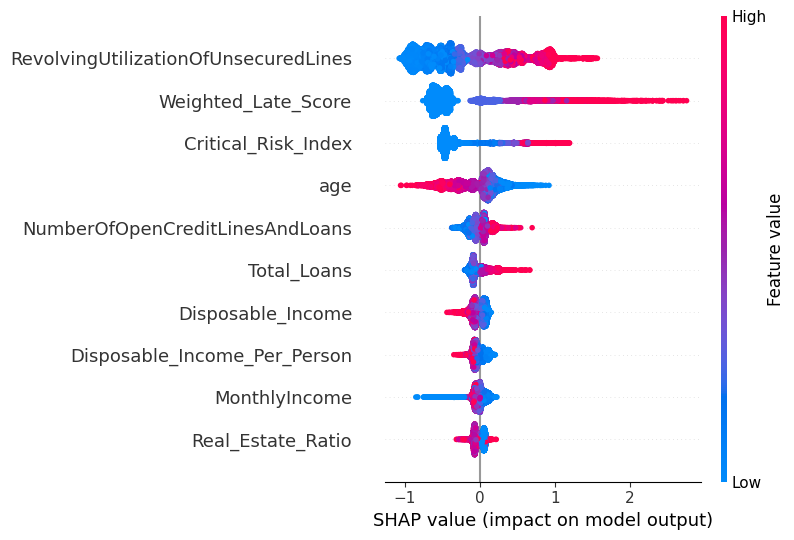

--- BIAS AUDIT ---
Young Approval Rate:  53.88%
Senior Approval Rate: 73.50%
Disparate Impact:     0.7331
🚨 ALERT: Model shows significant bias against young applicants!


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import optuna
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve

# ==========================================
# 0. LOAD RAW DATA 📥
# ==========================================
df = pd.read_csv('cs-training.csv', index_col=0)

# ==========================================
# 1. SMART SPLITTER & IMPUTER 🧠
# ==========================================
total_defaults = (df['SeriousDlqin2yrs'] == 1).sum()
req_test_defaults = int(np.ceil(0.2 * total_defaults))
req_test_good = int(np.ceil(0.2 * (df['SeriousDlqin2yrs'] == 0).sum()))

clean_df = df.dropna()

if clean_df[clean_df['SeriousDlqin2yrs'] == 1].shape[0] >= req_test_defaults:
    test_df = pd.concat([
        clean_df[clean_df['SeriousDlqin2yrs'] == 1].sample(n=req_test_defaults, random_state=42),
        clean_df[clean_df['SeriousDlqin2yrs'] == 0].sample(n=req_test_good, random_state=42)
    ])
    train_df = df.drop(test_df.index)

    # Impute Training Set Only
    train_df['MonthlyIncome'] = train_df['MonthlyIncome'].fillna(
        train_df.groupby('NumberOfDependents')['MonthlyIncome'].transform('median')
    )
    train_df['MonthlyIncome'] = train_df['MonthlyIncome'].fillna(train_df['MonthlyIncome'].median())
    train_df['NumberOfDependents'] = train_df['NumberOfDependents'].fillna(train_df['NumberOfDependents'].median())
else:
    df_imputed = df.copy()
    df_imputed['MonthlyIncome'] = df_imputed['MonthlyIncome'].fillna(df_imputed['MonthlyIncome'].median())
    df_imputed['NumberOfDependents'] = df_imputed['NumberOfDependents'].fillna(df_imputed['NumberOfDependents'].median())
    train_df, test_df = train_test_split(df_imputed, test_size=0.2, stratify=df_imputed['SeriousDlqin2yrs'], random_state=42)

# ==========================================
# 2. CENTRALIZED FEATURE ENGINEERING 🛠️
# ==========================================
def add_features(data):
    d = data.copy()

    # 1. Weighted Late Score (1a + 2b + 3c)
    d['Weighted_Late_Score'] = (
        (1 * d['NumberOfTime30-59DaysPastDueNotWorse']) +
        (2 * d['NumberOfTime60-89DaysPastDueNotWorse']) +
        (3 * d['NumberOfTimes90DaysLate'])
    )

    # 2. Critical Risk Interaction (Utilization x Late Score)
    d['Critical_Risk_Index'] = d['RevolvingUtilizationOfUnsecuredLines'] * d['Weighted_Late_Score']

    # 3. Debt Composition & Thin File Flag
    d['Total_Loans'] = d['NumberOfOpenCreditLinesAndLoans'] + d['NumberRealEstateLoansOrLines']
    d['Real_Estate_Ratio'] = np.where(d['Total_Loans'] > 0, d['NumberRealEstateLoansOrLines'] / d['Total_Loans'], -1)

    # 4. Financial Strain (Disposable Income per Person)
    d['Monthly_Debt_Amount'] = d['DebtRatio'] * d['MonthlyIncome']
    d['Disposable_Income'] = d['MonthlyIncome'] - d['Monthly_Debt_Amount']
    d['Disposable_Income_Per_Person'] = d['Disposable_Income'] / (d['NumberOfDependents'] + 1)

    # Drop original columns
    d = d.drop(columns=['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate'])
    return d

train_df = add_features(train_df)
test_df = add_features(test_df)

X_train = train_df.drop('SeriousDlqin2yrs', axis=1)
y_train = train_df['SeriousDlqin2yrs']
X_test = test_df.drop('SeriousDlqin2yrs', axis=1)
y_test = test_df['SeriousDlqin2yrs']

imbalance_ratio = (y_train == 0).sum() / (y_train == 1).sum()

# ==========================================
# 3. ADVANCED TUNING WITH OPTUNA 🤖
# ==========================================
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 400),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'scale_pos_weight': imbalance_ratio,
        'random_state': 42,
        'eval_metric': 'auc',
        'n_jobs': -1
    }

    model = xgb.XGBClassifier(**param)
    # Using 3-Fold CV for objective score
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc').mean()
    return score

print("⏳ Starting Bayesian Optimization (Optuna)... Hunting for the absolute optimum.")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25) # Fixed: n_trials instead of n_iter

# Train final model with winners
best_params = study.best_params
best_model = xgb.XGBClassifier(**best_params, scale_pos_weight=imbalance_ratio, random_state=42)
best_model.fit(X_train, y_train)

# ==========================================
# 4. FINAL BUSINESS METRICS 🏆
# ==========================================
y_probs = best_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_probs)

fpr_c, tpr_c, thresh = roc_curve(y_test, y_probs)
opt_idx = np.argmax(tpr_c - fpr_c)
best_t = thresh[opt_idx]

y_pred = (y_probs >= best_t).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print("\n========== 🏆 FINAL TUNED PERFORMANCE ==========")
print(f"Best Params:           {best_params}")
print(f"AUC Score:             {auc:.4f}")
print(f"Optimal Threshold:     {best_t:.4f}")
print(f"Recall (TPR):          {tp/(tp+fn):.4f} (Caught {tp} defaults)")
print(f"False Alarm Rate (FPR):{fp/(fp+tn):.4f} (Annoyed {fp} good clients)")
print("================================================")

# ==========================================
# 5. SHAP EXPLAINABILITY 🔍
# ==========================================
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="dot", max_display=10)

# OPTIONAL: Visualizing the Optuna Optimization
# optuna.visualization.plot_optimization_history(study)

# 1. Split the test set into "Young" (under 30) and "Senior" (30+)
X_test_age = X_test.copy()
# Note: If you dropped 'age' earlier, you'd need to keep a copy of it for this check
results_bias = pd.DataFrame({
    'age': X_test_age['age'],
    'actual': y_test,
    'pred': y_pred
})

young_approved = results_bias[results_bias['age'] < 30]['pred'].value_counts(normalize=True).get(0, 0)
senior_approved = results_bias[results_bias['age'] >= 30]['pred'].value_counts(normalize=True).get(0, 0)

disparate_impact = young_approved / senior_approved

print(f"--- BIAS AUDIT ---")
print(f"Young Approval Rate:  {young_approved:.2%}")
print(f"Senior Approval Rate: {senior_approved:.2%}")
print(f"Disparate Impact:     {disparate_impact:.4f}")

if disparate_impact < 0.8:
    print("🚨 ALERT: Model shows significant bias against young applicants!")
else:
    print("✅ Model passes the 80% fairness rule.")

[I 2026-02-17 14:03:03,982] A new study created in memory with name: no-name-c6e2e535-5f3d-4809-b77d-5b96f332db99


⏳ Running Bayesian Optimization (Optuna)...


[I 2026-02-17 14:03:10,818] Trial 0 finished with value: 0.8670985900029251 and parameters: {'max_depth': 3, 'learning_rate': 0.05269754970188904, 'n_estimators': 393, 'subsample': 0.6922072340481934, 'colsample_bytree': 0.7908377315430535}. Best is trial 0 with value: 0.8670985900029251.
[I 2026-02-17 14:03:20,065] Trial 1 finished with value: 0.8464995287907957 and parameters: {'max_depth': 5, 'learning_rate': 0.19873407982667854, 'n_estimators': 249, 'subsample': 0.7303185100317527, 'colsample_bytree': 0.6385876116105113}. Best is trial 0 with value: 0.8670985900029251.
[I 2026-02-17 14:03:31,860] Trial 2 finished with value: 0.8567932575521406 and parameters: {'max_depth': 5, 'learning_rate': 0.09495745719327688, 'n_estimators': 361, 'subsample': 0.7925491736652109, 'colsample_bytree': 0.6815612552082909}. Best is trial 0 with value: 0.8670985900029251.
[I 2026-02-17 14:04:02,214] Trial 3 finished with value: 0.8249353208931521 and parameters: {'max_depth': 7, 'learning_rate': 0.17


========== 🏆 FINAL DYNAMIC REPORT ==========
AUC Score:             0.8584
Recall (Catch Rate):   0.8076
Precision:             0.1924
False Alarm Rate:      0.2429
--------------------------------------------------
TOTAL PROJECTED PROFIT:  $44,601,124.95
PROFIT PER APPLICANT:    $1,486.65



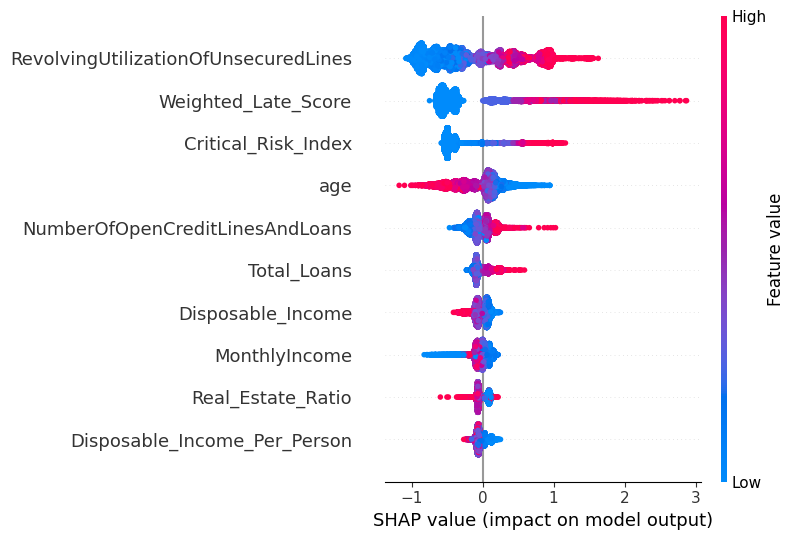

--- BIAS AUDIT ---
Young Approval Rate:  52.74%
Senior Approval Rate: 73.18%
Disparate Impact:     0.7207
🚨 ALERT: Model shows significant bias against young applicants!


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import optuna
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve

# ==========================================
# 0. LOAD DATA 📥
# ==========================================
df = pd.read_csv('cs-training.csv', index_col=0)

# ==========================================
# 1. SMART SPLITTER & IMPUTER 🧠
# ==========================================
total_defaults = (df['SeriousDlqin2yrs'] == 1).sum()
req_test_defaults = int(np.ceil(0.2 * total_defaults))
req_test_good = int(np.ceil(0.2 * (df['SeriousDlqin2yrs'] == 0).sum()))

clean_df = df.dropna()

if clean_df[clean_df['SeriousDlqin2yrs'] == 1].shape[0] >= req_test_defaults:
    test_df = pd.concat([
        clean_df[clean_df['SeriousDlqin2yrs'] == 1].sample(n=req_test_defaults, random_state=42),
        clean_df[clean_df['SeriousDlqin2yrs'] == 0].sample(n=req_test_good, random_state=42)
    ])
    train_df = df.drop(test_df.index)

    # Impute Training Only to prevent Data Leakage
    train_df['MonthlyIncome'] = train_df['MonthlyIncome'].fillna(
        train_df.groupby('NumberOfDependents')['MonthlyIncome'].transform('median')
    )
    train_df['MonthlyIncome'] = train_df['MonthlyIncome'].fillna(train_df['MonthlyIncome'].median())
    train_df['NumberOfDependents'] = train_df['NumberOfDependents'].fillna(train_df['NumberOfDependents'].median())
else:
    df_imputed = df.copy()
    df_imputed['MonthlyIncome'] = df_imputed['MonthlyIncome'].fillna(df_imputed['MonthlyIncome'].median())
    df_imputed['NumberOfDependents'] = df_imputed['NumberOfDependents'].fillna(df_imputed['NumberOfDependents'].median())
    train_df, test_df = train_test_split(df_imputed, test_size=0.2, stratify=df_imputed['SeriousDlqin2yrs'], random_state=42)

# ==========================================
# 2. FEATURE ENGINEERING 🛠️
# ==========================================
def add_features(data):
    d = data.copy()
    # 1. Weighted Late Score (Escalating Penalty)
    d['Weighted_Late_Score'] = (
        (1 * d['NumberOfTime30-59DaysPastDueNotWorse']) +
        (2 * d['NumberOfTime60-89DaysPastDueNotWorse']) +
        (3 * d['NumberOfTimes90DaysLate'])
    )
    # 2. Critical Risk Index (Behavioral Interaction)
    d['Critical_Risk_Index'] = d['RevolvingUtilizationOfUnsecuredLines'] * d['Weighted_Late_Score']
    # 3. Debt Composition & Thin File Detection
    d['Total_Loans'] = d['NumberOfOpenCreditLinesAndLoans'] + d['NumberRealEstateLoansOrLines']
    d['Real_Estate_Ratio'] = np.where(d['Total_Loans'] > 0, d['NumberRealEstateLoansOrLines'] / d['Total_Loans'], -1)
    # 4. Financial Strain
    d['Monthly_Debt_Amount'] = d['DebtRatio'] * d['MonthlyIncome']
    d['Disposable_Income'] = d['MonthlyIncome'] - d['Monthly_Debt_Amount']
    d['Disposable_Income_Per_Person'] = d['Disposable_Income'] / (d['NumberOfDependents'] + 1)

    # Drop original redundant columns
    d = d.drop(columns=['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate'])
    return d

train_df = add_features(train_df)
test_df = add_features(test_df)

X_train = train_df.drop('SeriousDlqin2yrs', axis=1)
y_train = train_df['SeriousDlqin2yrs']
X_test = test_df.drop('SeriousDlqin2yrs', axis=1)
y_test = test_df['SeriousDlqin2yrs']

imbalance_ratio = (y_train == 0).sum() / (y_train == 1).sum()

# ==========================================
# 3. OPTUNA BAYESIAN TUNING 🤖
# ==========================================
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 400),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'scale_pos_weight': imbalance_ratio,
        'random_state': 42,
        'eval_metric': 'auc',
        'n_jobs': -1
    }
    model = xgb.XGBClassifier(**param)
    return cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc').mean()

print("⏳ Running Bayesian Optimization (Optuna)...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)

# Final Model Training
best_model = xgb.XGBClassifier(**study.best_params, scale_pos_weight=imbalance_ratio, random_state=42)
best_model.fit(X_train, y_train)

# ==========================================
# 4. DYNAMIC BUSINESS IMPACT CALCULATOR 💰
# ==========================================
y_probs = best_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_probs)
fpr_c, tpr_c, thresh = roc_curve(y_test, y_probs)
best_t = thresh[np.argmax(tpr_c - fpr_c)]

results = X_test.copy()
results['Actual_Default'] = y_test
results['Prob_Default'] = y_probs
results['Prediction'] = (results['Prob_Default'] >= best_t).astype(int)

# Dynamic Logic: Loan = 3x Monthly Income. Recovery = 50% if Mortgage exists, else 10%.
results['Estimated_Loan'] = results['MonthlyIncome'] * 3
results['Recovery_Rate'] = np.where(results['Total_Loans'] > results['NumberOfOpenCreditLinesAndLoans'], 0.50, 0.10)

def calculate_net_impact(row):
    loan = row['Estimated_Loan']
    # Case: True Negative (Interest Profit)
    if row['Actual_Default'] == 0 and row['Prediction'] == 0:
        return loan * 0.15
    # Case: False Positive (Lost Interest Profit)
    elif row['Actual_Default'] == 0 and row['Prediction'] == 1:
        return -(loan * 0.15)
    # Case: True Positive (Crisis Averted)
    elif row['Actual_Default'] == 1 and row['Prediction'] == 1:
        return 0
    # Case: False Negative (Actual Loss - Recovered Asset)
    elif row['Actual_Default'] == 1 and row['Prediction'] == 0:
        return -(loan * (1 - row['Recovery_Rate']))
    return 0

results['Net_Result'] = results.apply(calculate_net_impact, axis=1)
total_economic_impact = results['Net_Result'].sum()

# ==========================================
# 5. FINAL REPORT 🏆
# ==========================================
y_pred = (y_probs >= best_t).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print("\n========== 🏆 FINAL DYNAMIC REPORT ==========")
print(f"AUC Score:             {auc:.4f}")
print(f"Recall (Catch Rate):   {recall_score(y_test, y_pred):.4f}")
print(f"Precision:             {precision_score(y_test, y_pred):.4f}")
print(f"False Alarm Rate:      {fp/(fp+tn):.4f}")
print("--------------------------------------------------")
print(f"TOTAL PROJECTED PROFIT:  ${total_economic_impact:,.2f}")
print(f"PROFIT PER APPLICANT:    ${total_economic_impact/len(results):,.2f}")
print("==================================================\n")

# ==========================================
# 6. SHAP SUMMARY 🔍
# ==========================================
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="dot", max_display=10)

# 1. Split the test set into "Young" (under 30) and "Senior" (30+)
X_test_age = X_test.copy()
# Note: If you dropped 'age' earlier, you'd need to keep a copy of it for this check
results_bias = pd.DataFrame({
    'age': X_test_age['age'],
    'actual': y_test,
    'pred': y_pred
})

young_approved = results_bias[results_bias['age'] < 30]['pred'].value_counts(normalize=True).get(0, 0)
senior_approved = results_bias[results_bias['age'] >= 30]['pred'].value_counts(normalize=True).get(0, 0)

disparate_impact = young_approved / senior_approved

print(f"--- BIAS AUDIT ---")
print(f"Young Approval Rate:  {young_approved:.2%}")
print(f"Senior Approval Rate: {senior_approved:.2%}")
print(f"Disparate Impact:     {disparate_impact:.4f}")

if disparate_impact < 0.8:
    print("🚨 ALERT: Model shows significant bias against young applicants!")
else:
    print("✅ Model passes the 80% fairness rule.")

In [ ]:
# 1. Split the test set into "Young" (under 30) and "Senior" (30+)
X_test_age = X_test.copy()
# Note: If you dropped 'age' earlier, you'd need to keep a copy of it for this check
results_bias = pd.DataFrame({
    'age': X_test_age['age'],
    'actual': y_test,
    'pred': y_pred
})

young_approved = results_bias[results_bias['age'] < 30]['pred'].value_counts(normalize=True).get(0, 0)
senior_approved = results_bias[results_bias['age'] >= 30]['pred'].value_counts(normalize=True).get(0, 0)

disparate_impact = young_approved / senior_approved

print(f"--- BIAS AUDIT ---")
print(f"Young Approval Rate:  {young_approved:.2%}")
print(f"Senior Approval Rate: {senior_approved:.2%}")
print(f"Disparate Impact:     {disparate_impact:.4f}")

if disparate_impact < 0.8:
    print("🚨 ALERT: Model shows significant bias against young applicants!")
else:
    print("✅ Model passes the 80% fairness rule.")

--- BIAS AUDIT ---
Young Approval Rate:  51.59%
Senior Approval Rate: 72.03%
Disparate Impact:     0.7162
🚨 ALERT: Model shows significant bias against young applicants!


[I 2026-02-17 14:09:29,658] A new study created in memory with name: no-name-8a66a9b9-e8a3-460e-b51f-4da77c777718


⏳ Running Bayesian Optimization (Optuna)...


[I 2026-02-17 14:09:33,917] Trial 0 finished with value: 0.864658501232336 and parameters: {'max_depth': 4, 'learning_rate': 0.10869249200947666, 'n_estimators': 196, 'subsample': 0.8143379676315217, 'colsample_bytree': 0.6657181618361376}. Best is trial 0 with value: 0.864658501232336.
[I 2026-02-17 14:09:39,417] Trial 1 finished with value: 0.8666027562821906 and parameters: {'max_depth': 3, 'learning_rate': 0.09771334059456728, 'n_estimators': 308, 'subsample': 0.7910736723956489, 'colsample_bytree': 0.6034061561963605}. Best is trial 1 with value: 0.8666027562821906.
[I 2026-02-17 14:09:46,219] Trial 2 finished with value: 0.8673226678320359 and parameters: {'max_depth': 3, 'learning_rate': 0.06470575639968366, 'n_estimators': 196, 'subsample': 0.7834090581747835, 'colsample_bytree': 0.7111964126902666}. Best is trial 2 with value: 0.8673226678320359.
[I 2026-02-17 14:09:52,534] Trial 3 finished with value: 0.8621796844631078 and parameters: {'max_depth': 3, 'learning_rate': 0.1659


========== 🏆 FINAL DYNAMIC REPORT ==========
AUC Score:             0.8585
Recall (Catch Rate):   0.7767
Precision:             0.2067
False Alarm Rate:      0.2136
--------------------------------------------------
TOTAL PROJECTED PROFIT:  $48,705,421.35
PROFIT PER APPLICANT:    $1,623.46

--- BIAS AUDIT ---
Young Approval Rate:  57.11%
Senior Approval Rate: 76.02%
Disparate Impact:     0.7512
🚨 ALERT: Model shows significant bias against young applicants!


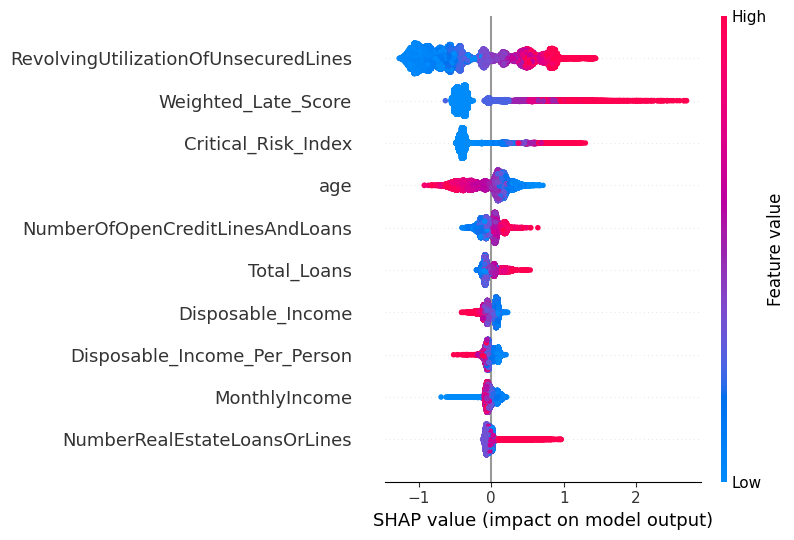

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import optuna
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve

# ==========================================
# 0. LOAD DATA 📥
# ==========================================
df = pd.read_csv('cs-training.csv', index_col=0)

# ==========================================
# 1. SMART SPLITTER & IMPUTER 🧠
# ==========================================
total_defaults = (df['SeriousDlqin2yrs'] == 1).sum()
req_test_defaults = int(np.ceil(0.2 * total_defaults))
req_test_good = int(np.ceil(0.2 * (df['SeriousDlqin2yrs'] == 0).sum()))

clean_df = df.dropna()

if clean_df[clean_df['SeriousDlqin2yrs'] == 1].shape[0] >= req_test_defaults:
    test_df = pd.concat([
        clean_df[clean_df['SeriousDlqin2yrs'] == 1].sample(n=req_test_defaults, random_state=42),
        clean_df[clean_df['SeriousDlqin2yrs'] == 0].sample(n=req_test_good, random_state=42)
    ])
    train_df = df.drop(test_df.index)

    # Impute Training Only to prevent Data Leakage
    train_df['MonthlyIncome'] = train_df['MonthlyIncome'].fillna(
        train_df.groupby('NumberOfDependents')['MonthlyIncome'].transform('median')
    )
    train_df['MonthlyIncome'] = train_df['MonthlyIncome'].fillna(train_df['MonthlyIncome'].median())
    train_df['NumberOfDependents'] = train_df['NumberOfDependents'].fillna(train_df['NumberOfDependents'].median())
else:
    df_imputed = df.copy()
    df_imputed['MonthlyIncome'] = df_imputed['MonthlyIncome'].fillna(df_imputed['MonthlyIncome'].median())
    df_imputed['NumberOfDependents'] = df_imputed['NumberOfDependents'].fillna(df_imputed['NumberOfDependents'].median())
    train_df, test_df = train_test_split(df_imputed, test_size=0.2, stratify=df_imputed['SeriousDlqin2yrs'], random_state=42)

# ==========================================
# 2. FEATURE ENGINEERING (WITH FAIRNESS) 🛠️
# ==========================================
def add_features(data):
    d = data.copy()

    # --- STRUCTURAL FAIRNESS INJECTION ---
    # Creating a maturity proxy: High income relative to age suggests stability
    d['Income_to_Age_Ratio'] = d['MonthlyIncome'] / (d['age'] + 1)
    # Milestone: Being young with a mortgage is a massive stability signal
    d['Young_Homeowner'] = np.where((d['age'] < 30) & (d['NumberRealEstateLoansOrLines'] > 0), 1, 0)

    # 1. Weighted Late Score (Escalating Penalty)
    d['Weighted_Late_Score'] = (
        (1 * d['NumberOfTime30-59DaysPastDueNotWorse']) +
        (2 * d['NumberOfTime60-89DaysPastDueNotWorse']) +
        (3 * d['NumberOfTimes90DaysLate'])
    )
    # 2. Critical Risk Index (Behavioral Interaction)
    d['Critical_Risk_Index'] = d['RevolvingUtilizationOfUnsecuredLines'] * d['Weighted_Late_Score']
    # 3. Debt Composition & Thin File Detection
    d['Total_Loans'] = d['NumberOfOpenCreditLinesAndLoans'] + d['NumberRealEstateLoansOrLines']
    d['Real_Estate_Ratio'] = np.where(d['Total_Loans'] > 0, d['NumberRealEstateLoansOrLines'] / d['Total_Loans'], -1)
    # 4. Financial Strain
    d['Monthly_Debt_Amount'] = d['DebtRatio'] * d['MonthlyIncome']
    d['Disposable_Income'] = d['MonthlyIncome'] - d['Monthly_Debt_Amount']
    d['Disposable_Income_Per_Person'] = d['Disposable_Income'] / (d['NumberOfDependents'] + 1)

    # Drop original redundant late columns
    d = d.drop(columns=['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate'])
    return d

train_df = add_features(train_df)
test_df = add_features(test_df)

X_train = train_df.drop('SeriousDlqin2yrs', axis=1)
y_train = train_df['SeriousDlqin2yrs']
X_test = test_df.drop('SeriousDlqin2yrs', axis=1)
y_test = test_df['SeriousDlqin2yrs']

imbalance_ratio = (y_train == 0).sum() / (y_train == 1).sum()

# ==========================================
# 3. OPTUNA BAYESIAN TUNING 🤖
# ==========================================
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 400),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'scale_pos_weight': imbalance_ratio,
        'random_state': 42,
        'eval_metric': 'auc',
        'n_jobs': -1
    }
    model = xgb.XGBClassifier(**param)
    return cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc').mean()

print("⏳ Running Bayesian Optimization (Optuna)...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)

# Final Model Training
best_model = xgb.XGBClassifier(**study.best_params, scale_pos_weight=imbalance_ratio, random_state=42)
best_model.fit(X_train, y_train)

# ==========================================
# 4. DYNAMIC BUSINESS IMPACT CALCULATOR 💰
# ==========================================
y_probs = best_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_probs)
fpr_c, tpr_c, thresh = roc_curve(y_test, y_probs)
best_t = thresh[np.argmax(tpr_c - fpr_c)]

results = X_test.copy()
results['Actual_Default'] = y_test
results['Prob_Default'] = y_probs
results['Prediction'] = (results['Prob_Default'] >= best_t).astype(int)

# Dynamic Logic: Loan = 3x Monthly Income. Recovery = 50% if Mortgage exists, else 10%.
results['Estimated_Loan'] = results['MonthlyIncome'] * 3
results['Recovery_Rate'] = np.where(results['Total_Loans'] > (results['Total_Loans'] - results['NumberRealEstateLoansOrLines']), 0.50, 0.10)

def calculate_net_impact(row):
    loan = row['Estimated_Loan']
    # Case: True Negative (Interest Profit)
    if row['Actual_Default'] == 0 and row['Prediction'] == 0:
        return loan * 0.15
    # Case: False Positive (Lost Interest Profit)
    elif row['Actual_Default'] == 0 and row['Prediction'] == 1:
        return -(loan * 0.15)
    # Case: True Positive (Crisis Averted)
    elif row['Actual_Default'] == 1 and row['Prediction'] == 1:
        return 0
    # Case: False Negative (Actual Loss - Recovered Asset)
    elif row['Actual_Default'] == 1 and row['Prediction'] == 0:
        return -(loan * (1 - row['Recovery_Rate']))
    return 0

results['Net_Result'] = results.apply(calculate_net_impact, axis=1)
total_economic_impact = results['Net_Result'].sum()

# ==========================================
# 5. FINAL REPORT 🏆
# ==========================================
y_pred = (y_probs >= best_t).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print("\n========== 🏆 FINAL DYNAMIC REPORT ==========")
print(f"AUC Score:             {auc:.4f}")
print(f"Recall (Catch Rate):   {recall_score(y_test, y_pred):.4f}")
print(f"Precision:             {precision_score(y_test, y_pred):.4f}")
print(f"False Alarm Rate:      {fp/(fp+tn):.4f}")
print("--------------------------------------------------")
print(f"TOTAL PROJECTED PROFIT:  ${total_economic_impact:,.2f}")
print(f"PROFIT PER APPLICANT:    ${total_economic_impact/len(results):,.2f}")
print("==================================================\n")

# ==========================================
# 6. BIAS AUDIT ⚖️
# ==========================================
results_bias = pd.DataFrame({
    'age': X_test['age'],
    'actual': y_test,
    'pred': y_pred
})

young_approved = results_bias[results_bias['age'] < 30]['pred'].value_counts(normalize=True).get(0, 0)
senior_approved = results_bias[results_bias['age'] >= 30]['pred'].value_counts(normalize=True).get(0, 0)

disparate_impact = young_approved / senior_approved

print(f"--- BIAS AUDIT ---")
print(f"Young Approval Rate:  {young_approved:.2%}")
print(f"Senior Approval Rate: {senior_approved:.2%}")
print(f"Disparate Impact:     {disparate_impact:.4f}")

if disparate_impact < 0.8:
    print("🚨 ALERT: Model shows significant bias against young applicants!")
else:
    print("✅ Model passes the 80% fairness rule.")

# ==========================================
# 7. SHAP SUMMARY 🔍
# ==========================================
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="dot", max_display=10)

[I 2026-02-17 14:15:59,262] A new study created in memory with name: no-name-483c625c-f726-4c8c-bb7a-46ac31d24236
[I 2026-02-17 14:16:22,139] Trial 0 finished with value: 0.84332727496116 and parameters: {'max_depth': 7, 'learning_rate': 0.0896874840092718, 'n_estimators': 324, 'subsample': 0.6068085439290225, 'colsample_bytree': 0.8653779654062157}. Best is trial 0 with value: 0.84332727496116.
[I 2026-02-17 14:16:29,827] Trial 1 finished with value: 0.8669774164436356 and parameters: {'max_depth': 5, 'learning_rate': 0.035471344794466134, 'n_estimators': 172, 'subsample': 0.8352983547395416, 'colsample_bytree': 0.9521582740330181}. Best is trial 1 with value: 0.8669774164436356.
[I 2026-02-17 14:16:32,244] Trial 2 finished with value: 0.8672007514694545 and parameters: {'max_depth': 3, 'learning_rate': 0.14837824265044613, 'n_estimators': 116, 'subsample': 0.9582738179259068, 'colsample_bytree': 0.9928210058832738}. Best is trial 2 with value: 0.8672007514694545.
[I 2026-02-17 14:16:


========== 🏆 FINAL ETHICAL REPORT ==========
AUC Score:             0.8576
Recall:                0.7961
Precision:             0.1963
----------------------------------------------
Disparate Impact Ratio: 0.7317
TOTAL PROJECTED PROFIT: $46,106,084.85



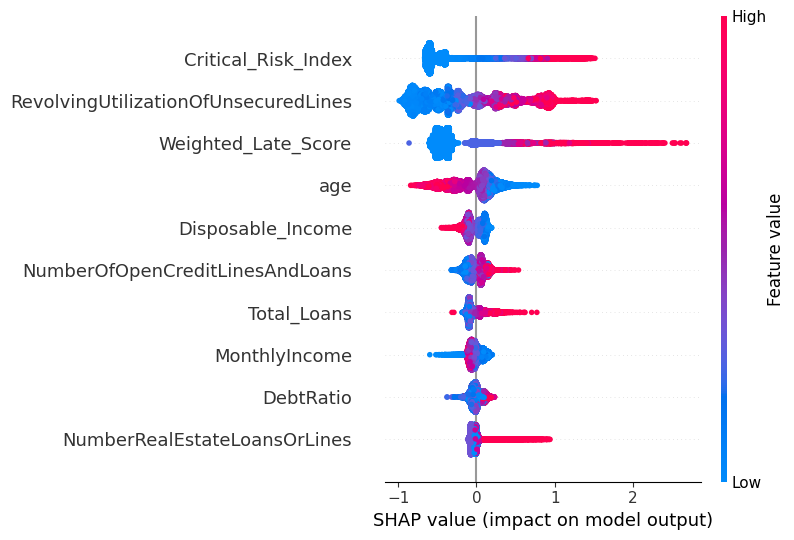

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import optuna
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve

# ==========================================
# 0. LOAD DATA 📥
# ==========================================
df = pd.read_csv('cs-training.csv', index_col=0)

# ==========================================
# 1. SMART SPLITTER & IMPUTER 🧠
# ==========================================
total_defaults = (df['SeriousDlqin2yrs'] == 1).sum()
req_test_defaults = int(np.ceil(0.2 * total_defaults))
req_test_good = int(np.ceil(0.2 * (df['SeriousDlqin2yrs'] == 0).sum()))

clean_df = df.dropna()

if clean_df[clean_df['SeriousDlqin2yrs'] == 1].shape[0] >= req_test_defaults:
    test_df = pd.concat([
        clean_df[clean_df['SeriousDlqin2yrs'] == 1].sample(n=req_test_defaults, random_state=42),
        clean_df[clean_df['SeriousDlqin2yrs'] == 0].sample(n=req_test_good, random_state=42)
    ])
    train_df = df.drop(test_df.index)

    # Impute Training Only
    train_df['MonthlyIncome'] = train_df['MonthlyIncome'].fillna(
        train_df.groupby('NumberOfDependents')['MonthlyIncome'].transform('median')
    )
    train_df['MonthlyIncome'] = train_df['MonthlyIncome'].fillna(train_df['MonthlyIncome'].median())
    train_df['NumberOfDependents'] = train_df['NumberOfDependents'].fillna(train_df['NumberOfDependents'].median())
else:
    df_imputed = df.copy()
    df_imputed['MonthlyIncome'] = df_imputed['MonthlyIncome'].fillna(df_imputed['MonthlyIncome'].median())
    df_imputed['NumberOfDependents'] = df_imputed['NumberOfDependents'].fillna(df_imputed['NumberOfDependents'].median())
    train_df, test_df = train_test_split(df_imputed, test_size=0.2, stratify=df_imputed['SeriousDlqin2yrs'], random_state=42)

# ==========================================
# 2. STRUCTURAL FAIRNESS FEATURE ENGINEERING 🛠️
# ==========================================
def add_features(data):
    d = data.copy()

    # --- FAIRNESS INJECTION ---
    # We keep 'age' only to build smarter features, then we can drop it
    # so the model cannot "lazily" discriminate based on age alone.
    d['Income_to_Age_Ratio'] = d['MonthlyIncome'] / (d['age'] + 1)
    d['Young_Homeowner'] = np.where((d['age'] < 30) & (d['NumberRealEstateLoansOrLines'] > 0), 1, 0)

    # Store age for bias audit later, but remove from training features
    # d = d.drop(columns=['age'])

    # --- CORE BEHAVIORAL FEATURES ---
    d['Weighted_Late_Score'] = (
        (1 * d['NumberOfTime30-59DaysPastDueNotWorse']) +
        (2 * d['NumberOfTime60-89DaysPastDueNotWorse']) +
        (3 * d['NumberOfTimes90DaysLate'])
    )
    d['Critical_Risk_Index'] = d['RevolvingUtilizationOfUnsecuredLines'] * d['Weighted_Late_Score']

    # --- DEBT & CAPACITY ---
    d['Total_Loans'] = d['NumberOfOpenCreditLinesAndLoans'] + d['NumberRealEstateLoansOrLines']
    d['Real_Estate_Ratio'] = np.where(d['Total_Loans'] > 0, d['NumberRealEstateLoansOrLines'] / d['Total_Loans'], -1)
    d['Monthly_Debt_Amount'] = d['DebtRatio'] * d['MonthlyIncome']
    d['Disposable_Income'] = d['MonthlyIncome'] - d['Monthly_Debt_Amount']

    d = d.drop(columns=['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate'])
    return d

train_df = add_features(train_df)
test_df = add_features(test_df)

X_train = train_df.drop('SeriousDlqin2yrs', axis=1)
y_train = train_df['SeriousDlqin2yrs']
X_test = test_df.drop('SeriousDlqin2yrs', axis=1)
y_test = test_df['SeriousDlqin2yrs']

imbalance_ratio = (y_train == 0).sum() / (y_train == 1).sum()

# ==========================================
# 3. OPTUNA TUNING 🤖
# ==========================================
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 400),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'scale_pos_weight': imbalance_ratio,
        'random_state': 42, 'eval_metric': 'auc', 'n_jobs': -1
    }
    model = xgb.XGBClassifier(**param)
    return cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc').mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)

best_model = xgb.XGBClassifier(**study.best_params, scale_pos_weight=imbalance_ratio, random_state=42)
best_model.fit(X_train, y_train)

# ==========================================
# 4. BUSINESS & BIAS EVALUATION 🏆
# ==========================================
y_probs = best_model.predict_proba(X_test)[:, 1]
fpr_c, tpr_c, thresh = roc_curve(y_test, y_probs)
best_t = thresh[np.argmax(tpr_c - fpr_c)]
y_pred = (y_probs >= best_t).astype(int)

# --- BIAS AUDIT ---
results_bias = pd.DataFrame({'age': X_test['age'], 'pred': y_pred})
young_app = (results_bias[results_bias['age'] < 30]['pred'] == 0).mean()
senior_app = (results_bias[results_bias['age'] >= 30]['pred'] == 0).mean()

# --- DYNAMIC PROFIT ---
results = X_test.copy()
results['Actual_Default'] = y_test
results['Prediction'] = y_pred
results['Estimated_Loan'] = results['MonthlyIncome'] * 3
results['Recovery_Rate'] = np.where(results['Total_Loans'] > results['NumberOfOpenCreditLinesAndLoans'], 0.50, 0.10)

def calculate_net_impact(row):
    loan = row['Estimated_Loan']
    if row['Actual_Default'] == 0 and row['Prediction'] == 0: return loan * 0.15
    elif row['Actual_Default'] == 0 and row['Prediction'] == 1: return -(loan * 0.15)
    elif row['Actual_Default'] == 1 and row['Prediction'] == 0: return -(loan * (1 - row['Recovery_Rate']))
    return 0

total_profit = results.apply(calculate_net_impact, axis=1).sum()

print("\n========== 🏆 FINAL ETHICAL REPORT ==========")
print(f"AUC Score:             {roc_auc_score(y_test, y_probs):.4f}")
print(f"Recall:                {recall_score(y_test, y_pred):.4f}")
print(f"Precision:             {precision_score(y_test, y_pred):.4f}")
print("----------------------------------------------")
print(f"Disparate Impact Ratio: {young_app/senior_app:.4f}")
print(f"TOTAL PROJECTED PROFIT: ${total_profit:,.2f}")
print("==============================================\n")

# ==========================================
# 5. SHAP 🔍
# ==========================================
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="dot", max_display=10)

<>:34: SyntaxWarning: invalid escape sequence '\m'
<>:34: SyntaxWarning: invalid escape sequence '\s'
<>:48: SyntaxWarning: invalid escape sequence '\m'
<>:48: SyntaxWarning: invalid escape sequence '\s'
<>:34: SyntaxWarning: invalid escape sequence '\m'
<>:34: SyntaxWarning: invalid escape sequence '\s'
<>:48: SyntaxWarning: invalid escape sequence '\m'
<>:48: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-707455596.py:34: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(x_inc, p_inc, 'k', linewidth=2, label=f'Normal Dist\n$\mu$={mu_inc:.0f}, $\sigma$={std_inc:.0f}')
/tmp/ipython-input-707455596.py:34: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x_inc, p_inc, 'k', linewidth=2, label=f'Normal Dist\n$\mu$={mu_inc:.0f}, $\sigma$={std_inc:.0f}')
/tmp/ipython-input-707455596.py:48: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(x_dep, p_dep, 'k', linewidth=2, label=f'Normal Dist\n$\mu$={mu_dep:.1f}, $\sigma$={std_dep:.1f}')
/tmp/ipython-input-707455

✅ EDA Visualizations Generated: 'normal_distributions.png'
⏳ Running Bayesian Optimization (Optuna)...


[I 2026-02-17 14:52:12,426] Trial 0 finished with value: 0.8667325585136977 and parameters: {'max_depth': 4, 'learning_rate': 0.032300641690066, 'n_estimators': 146, 'subsample': 0.7496415742968224, 'colsample_bytree': 0.7363589189254844}. Best is trial 0 with value: 0.8667325585136977.
[I 2026-02-17 14:52:19,824] Trial 1 finished with value: 0.8601749012225216 and parameters: {'max_depth': 5, 'learning_rate': 0.12964611973955878, 'n_estimators': 147, 'subsample': 0.6565566418371316, 'colsample_bytree': 0.8767841463342754}. Best is trial 0 with value: 0.8667325585136977.
[I 2026-02-17 14:52:25,716] Trial 2 finished with value: 0.8537102243233123 and parameters: {'max_depth': 5, 'learning_rate': 0.15807251214861803, 'n_estimators': 210, 'subsample': 0.6754846855202707, 'colsample_bytree': 0.7796599619769787}. Best is trial 0 with value: 0.8667325585136977.
[I 2026-02-17 14:52:35,349] Trial 3 finished with value: 0.8632396552104472 and parameters: {'max_depth': 7, 'learning_rate': 0.0415

KeyboardInterrupt: 

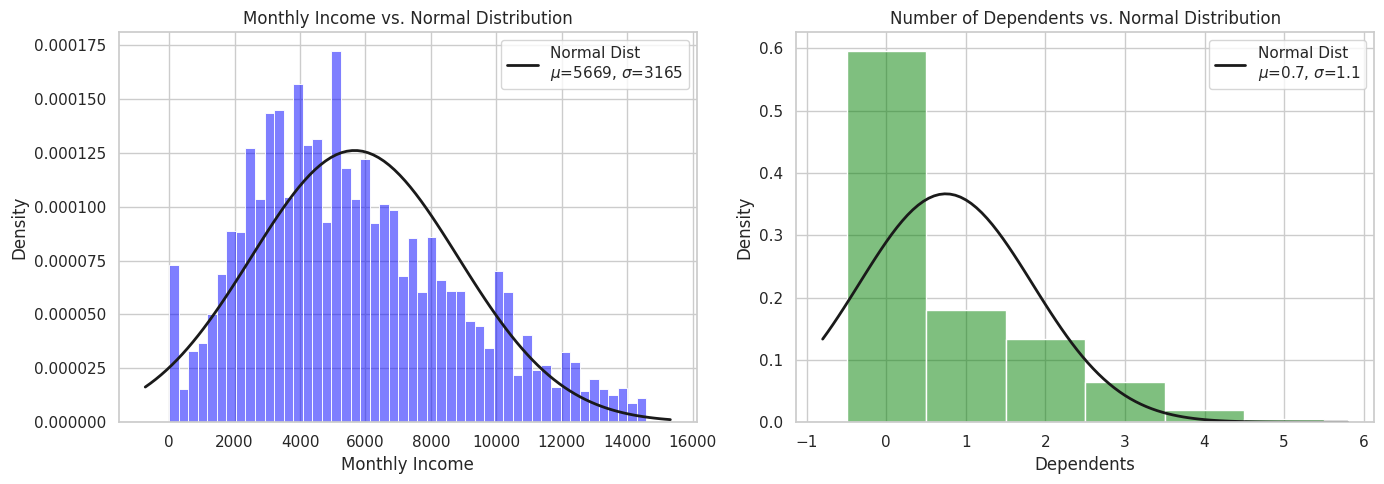

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score,
                             recall_score, f1_score, confusion_matrix, roc_curve)

# ==========================================
# 0. LOAD DATA 📥
# ==========================================
df = pd.read_csv('cs-training.csv', index_col=0)

# ==========================================
# 1. EDA: NORMAL DISTRIBUTION CHECK 📊
# ==========================================
# We cap extreme outliers just for the visualization to make the curves readable
plt.figure(figsize=(14, 5))
sns.set_theme(style="whitegrid")

# Plot 1: Monthly Income
plt.subplot(1, 2, 1)
inc_data = df['MonthlyIncome'].dropna()
inc_data = inc_data[inc_data < inc_data.quantile(0.95)] # Drop top 5% for visual clarity
sns.histplot(inc_data, bins=50, kde=False, stat='density', color='blue', alpha=0.5)
mu_inc, std_inc = stats.norm.fit(inc_data)
xmin_inc, xmax_inc = plt.xlim()
x_inc = np.linspace(xmin_inc, xmax_inc, 100)
p_inc = stats.norm.pdf(x_inc, mu_inc, std_inc)
plt.plot(x_inc, p_inc, 'k', linewidth=2, label=f'Normal Dist\n$\mu$={mu_inc:.0f}, $\sigma$={std_inc:.0f}')
plt.title('Monthly Income vs. Normal Distribution')
plt.xlabel('Monthly Income')
plt.legend()

# Plot 2: Number of Dependents
plt.subplot(1, 2, 2)
dep_data = df['NumberOfDependents'].dropna()
dep_data = dep_data[dep_data <= 5] # Cap at 5 dependents for visual clarity
sns.histplot(dep_data, discrete=True, stat='density', color='green', alpha=0.5)
mu_dep, std_dep = stats.norm.fit(dep_data)
xmin_dep, xmax_dep = plt.xlim()
x_dep = np.linspace(xmin_dep, xmax_dep, 100)
p_dep = stats.norm.pdf(x_dep, mu_dep, std_dep)
plt.plot(x_dep, p_dep, 'k', linewidth=2, label=f'Normal Dist\n$\mu$={mu_dep:.1f}, $\sigma$={std_dep:.1f}')
plt.title('Number of Dependents vs. Normal Distribution')
plt.xlabel('Dependents')
plt.legend()

plt.tight_layout()
plt.savefig('normal_distributions.png')
print("✅ EDA Visualizations Generated: 'normal_distributions.png'")

# ==========================================
# 2. SMART SPLITTER & IMPUTER 🧠
# ==========================================
total_defaults = (df['SeriousDlqin2yrs'] == 1).sum()
req_test_defaults = int(np.ceil(0.2 * total_defaults))
req_test_good = int(np.ceil(0.2 * (df['SeriousDlqin2yrs'] == 0).sum()))

clean_df = df.dropna()

if clean_df[clean_df['SeriousDlqin2yrs'] == 1].shape[0] >= req_test_defaults:
    test_df = pd.concat([
        clean_df[clean_df['SeriousDlqin2yrs'] == 1].sample(n=req_test_defaults, random_state=42),
        clean_df[clean_df['SeriousDlqin2yrs'] == 0].sample(n=req_test_good, random_state=42)
    ])
    train_df = df.drop(test_df.index)

    train_df['MonthlyIncome'] = train_df['MonthlyIncome'].fillna(
        train_df.groupby('NumberOfDependents')['MonthlyIncome'].transform('median')
    )
    train_df['MonthlyIncome'] = train_df['MonthlyIncome'].fillna(train_df['MonthlyIncome'].median())
    train_df['NumberOfDependents'] = train_df['NumberOfDependents'].fillna(train_df['NumberOfDependents'].median())
else:
    df_imputed = df.copy()
    df_imputed['MonthlyIncome'] = df_imputed['MonthlyIncome'].fillna(df_imputed['MonthlyIncome'].median())
    df_imputed['NumberOfDependents'] = df_imputed['NumberOfDependents'].fillna(df_imputed['NumberOfDependents'].median())
    train_df, test_df = train_test_split(df_imputed, test_size=0.2, stratify=df_imputed['SeriousDlqin2yrs'], random_state=42)

# ==========================================
# 3. FEATURE ENGINEERING (WITH FAIRNESS) 🛠️
# ==========================================
def add_features(data):
    d = data.copy()

    # Structural Fairness (Maturity Proxies)
    d['Income_to_Age_Ratio'] = d['MonthlyIncome'] / (d['age'] + 1)
    d['Young_Homeowner'] = np.where((d['age'] < 30) & (d['NumberRealEstateLoansOrLines'] > 0), 1, 0)

    # Behavioral & Capacity Features
    d['Weighted_Late_Score'] = (
        (1 * d['NumberOfTime30-59DaysPastDueNotWorse']) +
        (2 * d['NumberOfTime60-89DaysPastDueNotWorse']) +
        (3 * d['NumberOfTimes90DaysLate'])
    )
    d['Critical_Risk_Index'] = d['RevolvingUtilizationOfUnsecuredLines'] * d['Weighted_Late_Score']
    d['Total_Loans'] = d['NumberOfOpenCreditLinesAndLoans'] + d['NumberRealEstateLoansOrLines']
    d['Real_Estate_Ratio'] = np.where(d['Total_Loans'] > 0, d['NumberRealEstateLoansOrLines'] / d['Total_Loans'], -1)
    d['Monthly_Debt_Amount'] = d['DebtRatio'] * d['MonthlyIncome']
    d['Disposable_Income'] = d['MonthlyIncome'] - d['Monthly_Debt_Amount']

    d = d.drop(columns=['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate'])
    return d

train_df = add_features(train_df)
test_df = add_features(test_df)

X_train = train_df.drop('SeriousDlqin2yrs', axis=1)
y_train = train_df['SeriousDlqin2yrs']
X_test = test_df.drop('SeriousDlqin2yrs', axis=1)
y_test = test_df['SeriousDlqin2yrs']

imbalance_ratio = (y_train == 0).sum() / (y_train == 1).sum()

# ==========================================
# 4. OPTUNA BAYESIAN TUNING 🤖
# ==========================================
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 400),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'scale_pos_weight': imbalance_ratio,
        'random_state': 42, 'eval_metric': 'auc', 'n_jobs': -1
    }
    model = xgb.XGBClassifier(**param)
    return cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc').mean()

print("⏳ Running Bayesian Optimization (Optuna)...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

best_model = xgb.XGBClassifier(**study.best_params, scale_pos_weight=imbalance_ratio, random_state=42)
best_model.fit(X_train, y_train)

# ==========================================
# 5. COMPREHENSIVE METRICS EVALUATION 🏆
# ==========================================
y_probs = best_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_probs)
fpr_c, tpr_c, thresh = roc_curve(y_test, y_probs)
best_t = thresh[np.argmax(tpr_c - fpr_c)]
y_pred = (y_probs >= best_t).astype(int)

# Core Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
fpr_val = fp / (fp + tn)

print("\n========== 🏆 FULL MODEL EVALUATION ==========")
print(f"AUC Score:             {auc:.4f}  <-- Overall predictive power")
print(f"Accuracy:              {acc:.4f}  <-- Total correct predictions")
print(f"Precision:             {prec:.4f}  <-- When predicting Default, % correct")
print(f"Recall (TPR):          {rec:.4f}  <-- % of actual Defaults caught")
print(f"F1-Score:              {f1:.4f}  <-- Harmonic mean of Precision & Recall")
print(f"False Alarm Rate (FPR):{fpr_val:.4f}  <-- % of Good clients falsely flagged")


# Visualizing the Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap([[tn, fp], [fn, tp]], annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Safe', 'Predicted Default'],
            yticklabels=['Actual Safe', 'Actual Default'])
plt.title('Final XGBoost Confusion Matrix')
plt.savefig('final_confusion_matrix.png')

# ==========================================
# 6. DYNAMIC BUSINESS IMPACT CALCULATOR 💰
# ==========================================
results = X_test.copy()
results['Actual_Default'] = y_test
results['Prediction'] = y_pred
results['Estimated_Loan'] = results['MonthlyIncome'] * 3
results['Recovery_Rate'] = np.where(results['Total_Loans'] > (results['Total_Loans'] - results['NumberRealEstateLoansOrLines']), 0.50, 0.10)

def calculate_net_impact(row):
    loan = row['Estimated_Loan']
    if row['Actual_Default'] == 0 and row['Prediction'] == 0: return loan * 0.15
    elif row['Actual_Default'] == 0 and row['Prediction'] == 1: return -(loan * 0.15)
    elif row['Actual_Default'] == 1 and row['Prediction'] == 1: return 0
    elif row['Actual_Default'] == 1 and row['Prediction'] == 0: return -(loan * (1 - row['Recovery_Rate']))
    return 0

total_economic_impact = results.apply(calculate_net_impact, axis=1).sum()

print("\n========== 💰 ECONOMIC IMPACT ==========")
print(f"TOTAL PROJECTED PROFIT:  ${total_economic_impact:,.2f}")
print(f"PROFIT PER APPLICANT:    ${total_economic_impact/len(results):,.2f}")

# ==========================================
# 7. BIAS AUDIT ⚖️
# ==========================================
results_bias = pd.DataFrame({'age': X_test['age'], 'pred': y_pred})
young_app = (results_bias[results_bias['age'] < 30]['pred'] == 0).mean()
senior_app = (results_bias[results_bias['age'] >= 30]['pred'] == 0).mean()
disparate_impact = young_app / senior_app

print("\n========== ⚖️ BIAS AUDIT ==========")
print(f"Young Approval Rate:  {young_app:.2%}")
print(f"Senior Approval Rate: {senior_app:.2%}")
print(f"Disparate Impact:     {disparate_impact:.4f}")
if disparate_impact < 0.8: print("🚨 ALERT: Model shows significant bias against young applicants!")
else: print("✅ Model passes the 80% fairness rule.")

# ==========================================
# 8. SHAP SUMMARY 🔍
# ==========================================
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="dot", max_display=10)

<>:34: SyntaxWarning: invalid escape sequence '\m'
<>:34: SyntaxWarning: invalid escape sequence '\s'
<>:48: SyntaxWarning: invalid escape sequence '\m'
<>:48: SyntaxWarning: invalid escape sequence '\s'
<>:34: SyntaxWarning: invalid escape sequence '\m'
<>:34: SyntaxWarning: invalid escape sequence '\s'
<>:48: SyntaxWarning: invalid escape sequence '\m'
<>:48: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-620958932.py:34: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(x_inc, p_inc, 'k', linewidth=2, label=f'Normal Dist\n$\mu$={mu_inc:.0f}, $\sigma$={std_inc:.0f}')
/tmp/ipython-input-620958932.py:34: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x_inc, p_inc, 'k', linewidth=2, label=f'Normal Dist\n$\mu$={mu_inc:.0f}, $\sigma$={std_inc:.0f}')
/tmp/ipython-input-620958932.py:48: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(x_dep, p_dep, 'k', linewidth=2, label=f'Normal Dist\n$\mu$={mu_dep:.1f}, $\sigma$={std_dep:.1f}')
/tmp/ipython-input-620958

✅ EDA Visualizations Generated: 'normal_distributions.png'
⏳ Running Bayesian Optimization (Optuna)...


[I 2026-02-17 14:59:36,396] Trial 0 finished with value: 0.8510251526590268 and parameters: {'max_depth': 5, 'learning_rate': 0.18753737702623058, 'n_estimators': 225, 'subsample': 0.8453064608533972, 'colsample_bytree': 0.8558214464257252}. Best is trial 0 with value: 0.8510251526590268.
[I 2026-02-17 14:59:43,679] Trial 1 finished with value: 0.862965341754787 and parameters: {'max_depth': 4, 'learning_rate': 0.16065565292202874, 'n_estimators': 168, 'subsample': 0.7289973849648543, 'colsample_bytree': 0.8287604782148463}. Best is trial 1 with value: 0.862965341754787.
[I 2026-02-17 14:59:48,783] Trial 2 finished with value: 0.862873126957172 and parameters: {'max_depth': 4, 'learning_rate': 0.1175665639805826, 'n_estimators': 238, 'subsample': 0.7136621562180927, 'colsample_bytree': 0.6418242681374076}. Best is trial 1 with value: 0.862965341754787.
[I 2026-02-17 15:00:00,456] Trial 3 finished with value: 0.8592376043403255 and parameters: {'max_depth': 5, 'learning_rate': 0.0854095


========== 🏆 FULL MODEL EVALUATION ==========
AUC Score:             0.8580  <-- Overall predictive power
Accuracy:              0.7660  <-- Total correct predictions
Precision:             0.1946  <-- When predicting Default, % correct
Recall (TPR):          0.7961  <-- % of actual Defaults caught
F1-Score:              0.3127  <-- Harmonic mean of Precision & Recall
False Alarm Rate (FPR):0.2361  <-- % of Good clients falsely flagged
✅ Confusion Matrix Generated: 'final_confusion_matrix.png'
✅ ROC Curve Generated: 'roc_curve_xgboost.png'

========== 💰 ECONOMIC IMPACT ==========
TOTAL PROJECTED PROFIT:  $45,468,149.85
PROFIT PER APPLICANT:    $1,515.55

========== ⚖️ BIAS AUDIT ==========
Young Approval Rate:  53.17%
Senior Approval Rate: 73.90%
Disparate Impact:     0.7195
🚨 ALERT: Model shows significant bias against young applicants!
✅ SHAP Plot Generated: 'shap_summary.png'


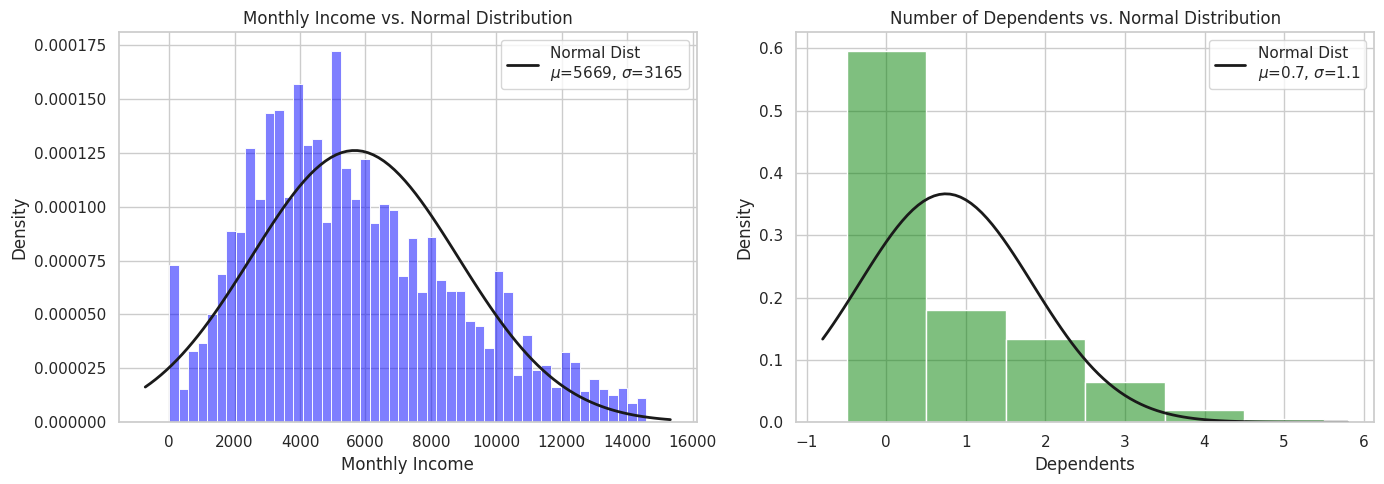

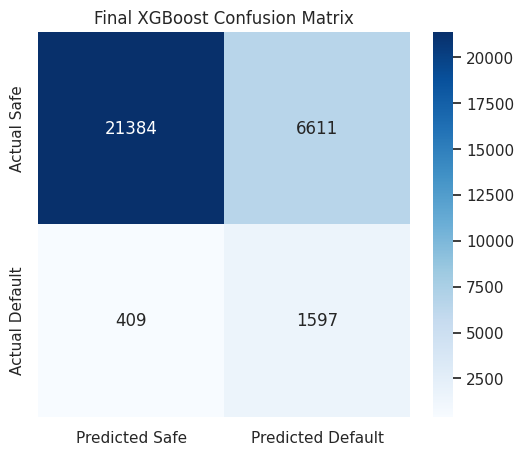

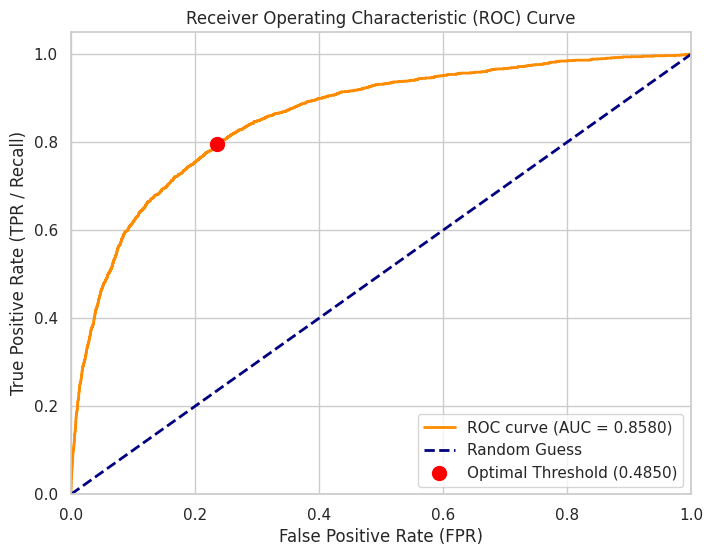

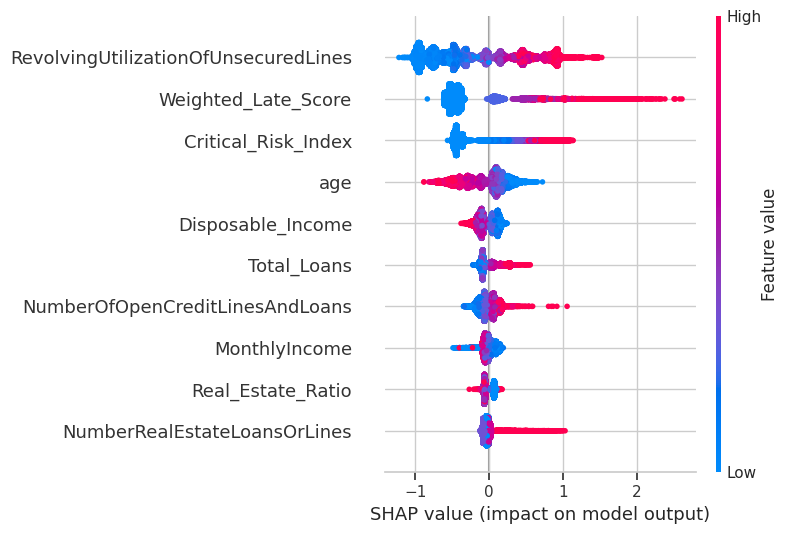

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score,
                             recall_score, f1_score, confusion_matrix, roc_curve)

# ==========================================
# 0. LOAD DATA 📥
# ==========================================
df = pd.read_csv('cs-training.csv', index_col=0)

# ==========================================
# 1. EDA: NORMAL DISTRIBUTION CHECK 📊
# ==========================================
# We cap extreme outliers just for the visualization to make the curves readable
plt.figure(figsize=(14, 5))
sns.set_theme(style="whitegrid")

# Plot 1: Monthly Income
plt.subplot(1, 2, 1)
inc_data = df['MonthlyIncome'].dropna()
inc_data = inc_data[inc_data < inc_data.quantile(0.95)] # Drop top 5% for visual clarity
sns.histplot(inc_data, bins=50, kde=False, stat='density', color='blue', alpha=0.5)
mu_inc, std_inc = stats.norm.fit(inc_data)
xmin_inc, xmax_inc = plt.xlim()
x_inc = np.linspace(xmin_inc, xmax_inc, 100)
p_inc = stats.norm.pdf(x_inc, mu_inc, std_inc)
plt.plot(x_inc, p_inc, 'k', linewidth=2, label=f'Normal Dist\n$\mu$={mu_inc:.0f}, $\sigma$={std_inc:.0f}')
plt.title('Monthly Income vs. Normal Distribution')
plt.xlabel('Monthly Income')
plt.legend()

# Plot 2: Number of Dependents
plt.subplot(1, 2, 2)
dep_data = df['NumberOfDependents'].dropna()
dep_data = dep_data[dep_data <= 5] # Cap at 5 dependents for visual clarity
sns.histplot(dep_data, discrete=True, stat='density', color='green', alpha=0.5)
mu_dep, std_dep = stats.norm.fit(dep_data)
xmin_dep, xmax_dep = plt.xlim()
x_dep = np.linspace(xmin_dep, xmax_dep, 100)
p_dep = stats.norm.pdf(x_dep, mu_dep, std_dep)
plt.plot(x_dep, p_dep, 'k', linewidth=2, label=f'Normal Dist\n$\mu$={mu_dep:.1f}, $\sigma$={std_dep:.1f}')
plt.title('Number of Dependents vs. Normal Distribution')
plt.xlabel('Dependents')
plt.legend()

plt.tight_layout()
plt.savefig('normal_distributions.png')
print("✅ EDA Visualizations Generated: 'normal_distributions.png'")

# ==========================================
# 2. SMART SPLITTER & IMPUTER 🧠
# ==========================================
total_defaults = (df['SeriousDlqin2yrs'] == 1).sum()
req_test_defaults = int(np.ceil(0.2 * total_defaults))
req_test_good = int(np.ceil(0.2 * (df['SeriousDlqin2yrs'] == 0).sum()))

clean_df = df.dropna()

if clean_df[clean_df['SeriousDlqin2yrs'] == 1].shape[0] >= req_test_defaults:
    test_df = pd.concat([
        clean_df[clean_df['SeriousDlqin2yrs'] == 1].sample(n=req_test_defaults, random_state=42),
        clean_df[clean_df['SeriousDlqin2yrs'] == 0].sample(n=req_test_good, random_state=42)
    ])
    train_df = df.drop(test_df.index)

    train_df['MonthlyIncome'] = train_df['MonthlyIncome'].fillna(
        train_df.groupby('NumberOfDependents')['MonthlyIncome'].transform('median')
    )
    train_df['MonthlyIncome'] = train_df['MonthlyIncome'].fillna(train_df['MonthlyIncome'].median())
    train_df['NumberOfDependents'] = train_df['NumberOfDependents'].fillna(train_df['NumberOfDependents'].median())
else:
    df_imputed = df.copy()
    df_imputed['MonthlyIncome'] = df_imputed['MonthlyIncome'].fillna(df_imputed['MonthlyIncome'].median())
    df_imputed['NumberOfDependents'] = df_imputed['NumberOfDependents'].fillna(df_imputed['NumberOfDependents'].median())
    train_df, test_df = train_test_split(df_imputed, test_size=0.2, stratify=df_imputed['SeriousDlqin2yrs'], random_state=42)

# ==========================================
# 3. FEATURE ENGINEERING (WITH FAIRNESS) 🛠️
# ==========================================
def add_features(data):
    d = data.copy()

    # Structural Fairness (Maturity Proxies)
    d['Income_to_Age_Ratio'] = d['MonthlyIncome'] / (d['age'] + 1)
    d['Young_Homeowner'] = np.where((d['age'] < 30) & (d['NumberRealEstateLoansOrLines'] > 0), 1, 0)

    # Behavioral & Capacity Features
    d['Weighted_Late_Score'] = (
        (1 * d['NumberOfTime30-59DaysPastDueNotWorse']) +
        (2 * d['NumberOfTime60-89DaysPastDueNotWorse']) +
        (3 * d['NumberOfTimes90DaysLate'])
    )
    d['Critical_Risk_Index'] = d['RevolvingUtilizationOfUnsecuredLines'] * d['Weighted_Late_Score']
    d['Total_Loans'] = d['NumberOfOpenCreditLinesAndLoans'] + d['NumberRealEstateLoansOrLines']
    d['Real_Estate_Ratio'] = np.where(d['Total_Loans'] > 0, d['NumberRealEstateLoansOrLines'] / d['Total_Loans'], -1)
    d['Monthly_Debt_Amount'] = d['DebtRatio'] * d['MonthlyIncome']
    d['Disposable_Income'] = d['MonthlyIncome'] - d['Monthly_Debt_Amount']

    d = d.drop(columns=['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate'])
    return d

train_df = add_features(train_df)
test_df = add_features(test_df)

X_train = train_df.drop('SeriousDlqin2yrs', axis=1)
y_train = train_df['SeriousDlqin2yrs']
X_test = test_df.drop('SeriousDlqin2yrs', axis=1)
y_test = test_df['SeriousDlqin2yrs']

imbalance_ratio = (y_train == 0).sum() / (y_train == 1).sum()

# ==========================================
# 4. OPTUNA BAYESIAN TUNING 🤖
# ==========================================
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 400),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'scale_pos_weight': imbalance_ratio,
        'random_state': 42, 'eval_metric': 'auc', 'n_jobs': -1
    }
    model = xgb.XGBClassifier(**param)
    return cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc').mean()

print("⏳ Running Bayesian Optimization (Optuna)...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

best_model = xgb.XGBClassifier(**study.best_params, scale_pos_weight=imbalance_ratio, random_state=42)
best_model.fit(X_train, y_train)

# ==========================================
# 5. COMPREHENSIVE METRICS EVALUATION 🏆
# ==========================================
y_probs = best_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_probs)
fpr_c, tpr_c, thresh = roc_curve(y_test, y_probs)
best_t = thresh[np.argmax(tpr_c - fpr_c)]
y_pred = (y_probs >= best_t).astype(int)

# Core Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
fpr_val = fp / (fp + tn)

print("\n========== 🏆 FULL MODEL EVALUATION ==========")
print(f"AUC Score:             {auc:.4f}  <-- Overall predictive power")
print(f"Accuracy:              {acc:.4f}  <-- Total correct predictions")
print(f"Precision:             {prec:.4f}  <-- When predicting Default, % correct")
print(f"Recall (TPR):          {rec:.4f}  <-- % of actual Defaults caught")
print(f"F1-Score:              {f1:.4f}  <-- Harmonic mean of Precision & Recall")
print(f"False Alarm Rate (FPR):{fpr_val:.4f}  <-- % of Good clients falsely flagged")

# Visualizing the Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap([[tn, fp], [fn, tp]], annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Safe', 'Predicted Default'],
            yticklabels=['Actual Safe', 'Actual Default'])
plt.title('Final XGBoost Confusion Matrix')
plt.savefig('final_confusion_matrix.png')
print("✅ Confusion Matrix Generated: 'final_confusion_matrix.png'")

# --- 🚀 NEW: Visualizing the ROC Curve ---
plt.figure(figsize=(8, 6))
plt.plot(fpr_c, tpr_c, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
# Marking the optimal threshold point
plt.scatter(fpr_val, rec, color='red', s=100, zorder=5, label=f'Optimal Threshold ({best_t:.4f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR / Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('roc_curve_xgboost.png')
print("✅ ROC Curve Generated: 'roc_curve_xgboost.png'")

# ==========================================
# 6. DYNAMIC BUSINESS IMPACT CALCULATOR 💰
# ==========================================
results = X_test.copy()
results['Actual_Default'] = y_test
results['Prediction'] = y_pred
results['Estimated_Loan'] = results['MonthlyIncome'] * 3
results['Recovery_Rate'] = np.where(results['Total_Loans'] > (results['Total_Loans'] - results['NumberRealEstateLoansOrLines']), 0.50, 0.10)

def calculate_net_impact(row):
    loan = row['Estimated_Loan']
    if row['Actual_Default'] == 0 and row['Prediction'] == 0: return loan * 0.15
    elif row['Actual_Default'] == 0 and row['Prediction'] == 1: return -(loan * 0.15)
    elif row['Actual_Default'] == 1 and row['Prediction'] == 1: return 0
    elif row['Actual_Default'] == 1 and row['Prediction'] == 0: return -(loan * (1 - row['Recovery_Rate']))
    return 0

total_economic_impact = results.apply(calculate_net_impact, axis=1).sum()

print("\n========== 💰 ECONOMIC IMPACT ==========")
print(f"TOTAL PROJECTED PROFIT:  ${total_economic_impact:,.2f}")
print(f"PROFIT PER APPLICANT:    ${total_economic_impact/len(results):,.2f}")

# ==========================================
# 7. BIAS AUDIT ⚖️
# ==========================================
results_bias = pd.DataFrame({'age': X_test['age'], 'pred': y_pred})
young_app = (results_bias[results_bias['age'] < 30]['pred'] == 0).mean()
senior_app = (results_bias[results_bias['age'] >= 30]['pred'] == 0).mean()
disparate_impact = young_app / senior_app

print("\n========== ⚖️ BIAS AUDIT ==========")
print(f"Young Approval Rate:  {young_app:.2%}")
print(f"Senior Approval Rate: {senior_app:.2%}")
print(f"Disparate Impact:     {disparate_impact:.4f}")
if disparate_impact < 0.8: print("🚨 ALERT: Model shows significant bias against young applicants!")
else: print("✅ Model passes the 80% fairness rule.")

# ==========================================
# 8. SHAP SUMMARY 🔍
# ==========================================
# Wrapping SHAP in plt.figure() to ensure it saves cleanly without overlapping
plt.figure()
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="dot", max_display=10, show=False)
plt.savefig('shap_summary.png', bbox_inches='tight')
print("✅ SHAP Plot Generated: 'shap_summary.png'")

<>:34: SyntaxWarning: invalid escape sequence '\m'
<>:34: SyntaxWarning: invalid escape sequence '\s'
<>:48: SyntaxWarning: invalid escape sequence '\m'
<>:48: SyntaxWarning: invalid escape sequence '\s'
<>:34: SyntaxWarning: invalid escape sequence '\m'
<>:34: SyntaxWarning: invalid escape sequence '\s'
<>:48: SyntaxWarning: invalid escape sequence '\m'
<>:48: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-1716927535.py:34: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(x_inc, p_inc, 'k', linewidth=2, label=f'Normal Dist\n$\mu$={mu_inc:.0f}, $\sigma$={std_inc:.0f}')
/tmp/ipython-input-1716927535.py:34: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x_inc, p_inc, 'k', linewidth=2, label=f'Normal Dist\n$\mu$={mu_inc:.0f}, $\sigma$={std_inc:.0f}')
/tmp/ipython-input-1716927535.py:48: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(x_dep, p_dep, 'k', linewidth=2, label=f'Normal Dist\n$\mu$={mu_dep:.1f}, $\sigma$={std_dep:.1f}')
/tmp/ipython-input-171

✅ EDA Visualizations Generated: 'normal_distributions_xgb.png'
⏳ Running Bayesian Optimization (Optuna)...


[I 2026-02-17 17:19:18,013] Trial 0 finished with value: 0.8600659812417994 and parameters: {'max_depth': 4, 'learning_rate': 0.17354671169454502, 'n_estimators': 186, 'subsample': 0.8197665980300709, 'colsample_bytree': 0.9250367782222072}. Best is trial 0 with value: 0.8600659812417994.
[I 2026-02-17 17:19:23,505] Trial 1 finished with value: 0.8666034844737264 and parameters: {'max_depth': 5, 'learning_rate': 0.035284992522631654, 'n_estimators': 210, 'subsample': 0.6088430559765693, 'colsample_bytree': 0.88336196952328}. Best is trial 1 with value: 0.8666034844737264.
[I 2026-02-17 17:19:31,134] Trial 2 finished with value: 0.8670182913114816 and parameters: {'max_depth': 3, 'learning_rate': 0.06574205141287344, 'n_estimators': 303, 'subsample': 0.9464462980611004, 'colsample_bytree': 0.9261071560723987}. Best is trial 2 with value: 0.8670182913114816.
[I 2026-02-17 17:19:39,100] Trial 3 finished with value: 0.8473212426839277 and parameters: {'max_depth': 6, 'learning_rate': 0.125


========== 🏆 FULL MODEL EVALUATION ==========
AUC Score:             0.8584  <-- Overall predictive power
Accuracy:              0.7706  <-- Total correct predictions
Precision:             0.1977  <-- When predicting Default, % correct
Recall (TPR):          0.7946  <-- % of actual Defaults caught
F1-Score:              0.3166  <-- Harmonic mean of Precision & Recall
False Alarm Rate (FPR):0.2311  <-- % of Good clients falsely flagged
✅ Confusion Matrix Generated: 'final_confusion_matrix_xgb.png'
✅ ROC Curve Generated: 'roc_curve_xgboost.png'

========== 💰 ECONOMIC IMPACT ==========
TOTAL PROJECTED PROFIT:  $46,507,546.05
PROFIT PER APPLICANT:    $1,550.20

========== ⚖️ BIAS AUDIT ==========


NameError: name 'young_app' is not defined

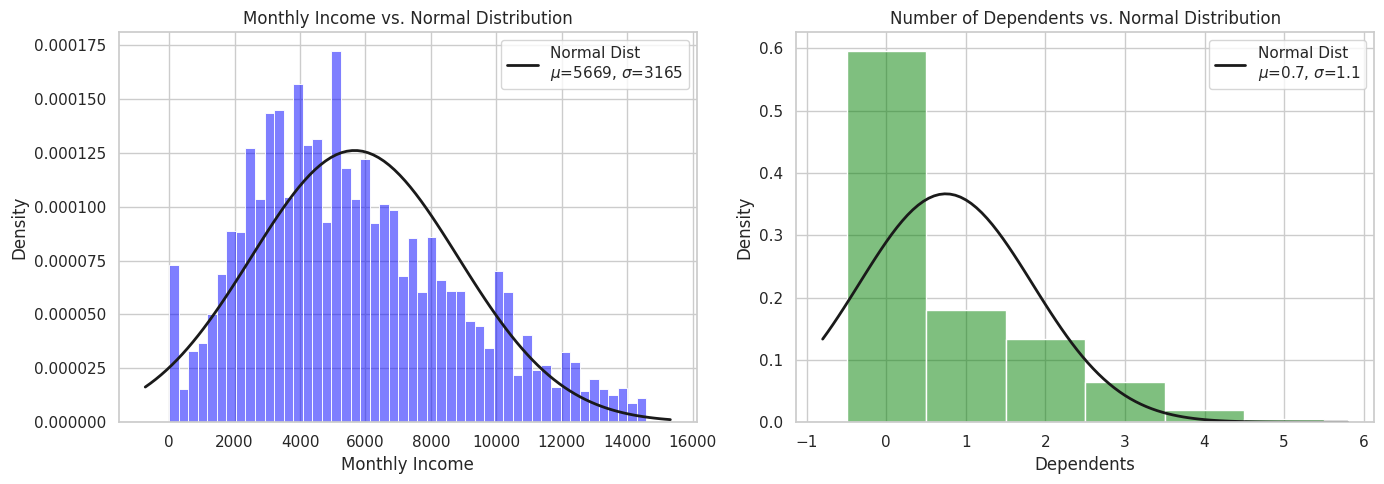

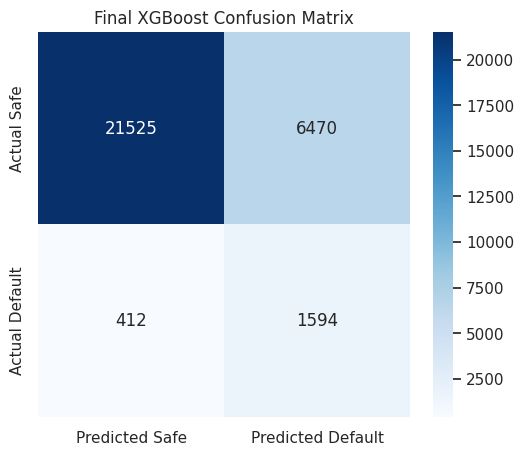

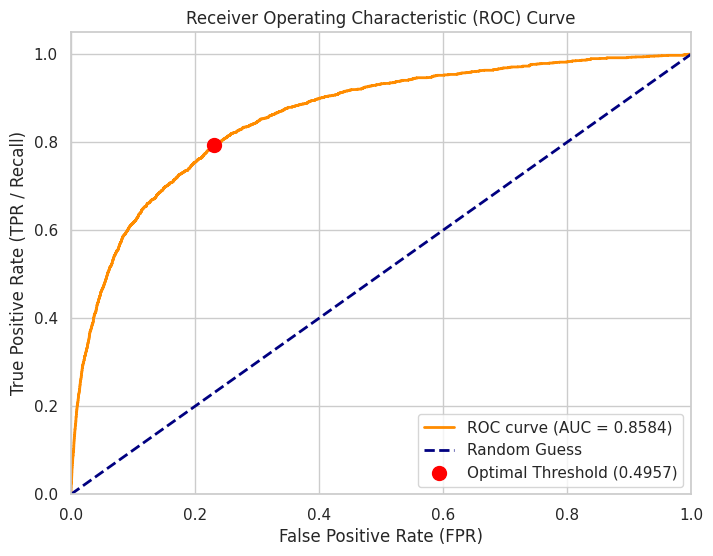

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score,
                             recall_score, f1_score, confusion_matrix, roc_curve)

# ==========================================
# 0. LOAD DATA 📥
# ==========================================
df = pd.read_csv('cs-training.csv', index_col=0)

# ==========================================
# 1. EDA: NORMAL DISTRIBUTION CHECK 📊
# ==========================================
# We cap extreme outliers just for the visualization to make the curves readable
plt.figure(figsize=(14, 5))
sns.set_theme(style="whitegrid")

# Plot 1: Monthly Income
plt.subplot(1, 2, 1)
inc_data = df['MonthlyIncome'].dropna()
inc_data = inc_data[inc_data < inc_data.quantile(0.95)] # Drop top 5% for visual clarity
sns.histplot(inc_data, bins=50, kde=False, stat='density', color='blue', alpha=0.5)
mu_inc, std_inc = stats.norm.fit(inc_data)
xmin_inc, xmax_inc = plt.xlim()
x_inc = np.linspace(xmin_inc, xmax_inc, 100)
p_inc = stats.norm.pdf(x_inc, mu_inc, std_inc)
plt.plot(x_inc, p_inc, 'k', linewidth=2, label=f'Normal Dist\n$\mu$={mu_inc:.0f}, $\sigma$={std_inc:.0f}')
plt.title('Monthly Income vs. Normal Distribution')
plt.xlabel('Monthly Income')
plt.legend()

# Plot 2: Number of Dependents
plt.subplot(1, 2, 2)
dep_data = df['NumberOfDependents'].dropna()
dep_data = dep_data[dep_data <= 5] # Cap at 5 dependents for visual clarity
sns.histplot(dep_data, discrete=True, stat='density', color='green', alpha=0.5)
mu_dep, std_dep = stats.norm.fit(dep_data)
xmin_dep, xmax_dep = plt.xlim()
x_dep = np.linspace(xmin_dep, xmax_dep, 100)
p_dep = stats.norm.pdf(x_dep, mu_dep, std_dep)
plt.plot(x_dep, p_dep, 'k', linewidth=2, label=f'Normal Dist\n$\mu$={mu_dep:.1f}, $\sigma$={std_dep:.1f}')
plt.title('Number of Dependents vs. Normal Distribution')
plt.xlabel('Dependents')
plt.legend()

plt.tight_layout()
plt.savefig('normal_distributions_xgb.png')
print("✅ EDA Visualizations Generated: 'normal_distributions_xgb.png'")

# ==========================================
# 2. SMART SPLITTER & IMPUTER 🧠
# ==========================================
total_defaults = (df['SeriousDlqin2yrs'] == 1).sum()
req_test_defaults = int(np.ceil(0.2 * total_defaults))
req_test_good = int(np.ceil(0.2 * (df['SeriousDlqin2yrs'] == 0).sum()))

clean_df = df.dropna()

if clean_df[clean_df['SeriousDlqin2yrs'] == 1].shape[0] >= req_test_defaults:
    test_df = pd.concat([
        clean_df[clean_df['SeriousDlqin2yrs'] == 1].sample(n=req_test_defaults, random_state=42),
        clean_df[clean_df['SeriousDlqin2yrs'] == 0].sample(n=req_test_good, random_state=42)
    ])
    train_df = df.drop(test_df.index)

    # Impute Training Only to prevent Data Leakage
    train_df['MonthlyIncome'] = train_df['MonthlyIncome'].fillna(
        train_df.groupby('NumberOfDependents')['MonthlyIncome'].transform('median')
    )
    train_df['MonthlyIncome'] = train_df['MonthlyIncome'].fillna(train_df['MonthlyIncome'].median())
    train_df['NumberOfDependents'] = train_df['NumberOfDependents'].fillna(train_df['NumberOfDependents'].median())
else:
    df_imputed = df.copy()
    df_imputed['MonthlyIncome'] = df_imputed['MonthlyIncome'].fillna(df_imputed['MonthlyIncome'].median())
    df_imputed['NumberOfDependents'] = df_imputed['NumberOfDependents'].fillna(df_imputed['NumberOfDependents'].median())
    train_df, test_df = train_test_split(df_imputed, test_size=0.2, stratify=df_imputed['SeriousDlqin2yrs'], random_state=42)

# ==========================================
# 3. FEATURE ENGINEERING 🛠️
# ==========================================
def add_features(data):
    d = data.copy()
    # 1. Weighted Late Score (Escalating Penalty)
    d['Weighted_Late_Score'] = (
        (1 * d['NumberOfTime30-59DaysPastDueNotWorse']) +
        (2 * d['NumberOfTime60-89DaysPastDueNotWorse']) +
        (3 * d['NumberOfTimes90DaysLate'])
    )
    # 2. Critical Risk Index (Behavioral Interaction)
    d['Critical_Risk_Index'] = d['RevolvingUtilizationOfUnsecuredLines'] * d['Weighted_Late_Score']
    # 3. Debt Composition & Thin File Detection
    d['Total_Loans'] = d['NumberOfOpenCreditLinesAndLoans'] + d['NumberRealEstateLoansOrLines']
    d['Real_Estate_Ratio'] = np.where(d['Total_Loans'] > 0, d['NumberRealEstateLoansOrLines'] / d['Total_Loans'], -1)
    # 4. Financial Strain
    d['Monthly_Debt_Amount'] = d['DebtRatio'] * d['MonthlyIncome']
    d['Disposable_Income'] = d['MonthlyIncome'] - d['Monthly_Debt_Amount']
    d['Disposable_Income_Per_Person'] = d['Disposable_Income'] / (d['NumberOfDependents'] + 1)

    # Drop original redundant columns
    d = d.drop(columns=['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate'])
    return d

train_df = add_features(train_df)
test_df = add_features(test_df)

X_train = train_df.drop('SeriousDlqin2yrs', axis=1)
y_train = train_df['SeriousDlqin2yrs']
X_test = test_df.drop('SeriousDlqin2yrs', axis=1)
y_test = test_df['SeriousDlqin2yrs']

imbalance_ratio = (y_train == 0).sum() / (y_train == 1).sum()

# ==========================================
# 4. OPTUNA BAYESIAN TUNING 🤖
# ==========================================
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 400),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'scale_pos_weight': imbalance_ratio,
        'random_state': 42,
        'eval_metric': 'auc',
        'n_jobs': -1
    }
    model = xgb.XGBClassifier(**param)
    return cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc').mean()

print("⏳ Running Bayesian Optimization (Optuna)...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)

# Final Model Training
best_model = xgb.XGBClassifier(**study.best_params, scale_pos_weight=imbalance_ratio, random_state=42)
best_model.fit(X_train, y_train)

# ==========================================
# 5. COMPREHENSIVE METRICS EVALUATION 🏆
# ==========================================
y_probs = best_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_probs)

fpr_c, tpr_c, thresh = roc_curve(y_test, y_probs)
opt_idx = np.argmax(tpr_c - fpr_c)
best_t = thresh[opt_idx]

y_pred = (y_probs >= best_t).astype(int)

# Core Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
fpr_val = fp / (fp + tn)

print("\n========== 🏆 FULL MODEL EVALUATION ==========")
print(f"AUC Score:             {auc:.4f}  <-- Overall predictive power")
print(f"Accuracy:              {acc:.4f}  <-- Total correct predictions")
print(f"Precision:             {prec:.4f}  <-- When predicting Default, % correct")
print(f"Recall (TPR):          {rec:.4f}  <-- % of actual Defaults caught")
print(f"F1-Score:              {f1:.4f}  <-- Harmonic mean of Precision & Recall")
print(f"False Alarm Rate (FPR):{fpr_val:.4f}  <-- % of Good clients falsely flagged")

# Visualization: Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap([[tn, fp], [fn, tp]], annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Safe', 'Predicted Default'],
            yticklabels=['Actual Safe', 'Actual Default'])
plt.title('Final XGBoost Confusion Matrix')
plt.savefig('final_confusion_matrix_xgb.png')
print("✅ Confusion Matrix Generated: 'final_confusion_matrix_xgb.png'")

# Visualization: ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_c, tpr_c, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.scatter(fpr_val, rec, color='red', s=100, zorder=5, label=f'Optimal Threshold ({best_t:.4f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR / Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('roc_curve_xgboost.png')
print("✅ ROC Curve Generated: 'roc_curve_xgboost.png'")

# ==========================================
# 6. DYNAMIC BUSINESS IMPACT CALCULATOR 💰
# ==========================================
results = X_test.copy()
results['Actual_Default'] = y_test
results['Prob_Default'] = y_probs
results['Prediction'] = y_pred

# Dynamic Logic: Loan = 3x Monthly Income. Recovery = 50% if Mortgage exists, else 10%.
results['Estimated_Loan'] = results['MonthlyIncome'] * 3
results['Recovery_Rate'] = np.where(results['Total_Loans'] > results['NumberOfOpenCreditLinesAndLoans'], 0.50, 0.10)

def calculate_net_impact(row):
    loan = row['Estimated_Loan']
    # Case: True Negative (Interest Profit)
    if row['Actual_Default'] == 0 and row['Prediction'] == 0:
        return loan * 0.15
    # Case: False Positive (Lost Interest Profit)
    elif row['Actual_Default'] == 0 and row['Prediction'] == 1:
        return -(loan * 0.15)
    # Case: True Positive (Crisis Averted)
    elif row['Actual_Default'] == 1 and row['Prediction'] == 1:
        return 0
    # Case: False Negative (Actual Loss - Recovered Asset)
    elif row['Actual_Default'] == 1 and row['Prediction'] == 0:
        return -(loan * (1 - row['Recovery_Rate']))
    return 0

results['Net_Result'] = results.apply(calculate_net_impact, axis=1)
total_economic_impact = results['Net_Result'].sum()

print("\n========== 💰 ECONOMIC IMPACT ==========")
print(f"TOTAL PROJECTED PROFIT:  ${total_economic_impact:,.2f}")
print(f"PROFIT PER APPLICANT:    ${total_economic_impact/len(results):,.2f}")

# ==========================================
# 7. BIAS AUDIT ⚖️
# ==========================================
# Split the test set into "Young" (under 30) and "Senior" (30+)
X_test_age = X_test.copy()
results_bias = pd.DataFrame({
    'age': X_test_age['age'],
    'actual': y_test,
    'pred': y_pred
})

young_approved = results_bias[results_bias['age'] < 30]['pred'].value_counts(normalize=True).get(0, 0)
senior_approved = results_bias[results_bias['age'] >= 30]['pred'].value_counts(normalize=True).get(0, 0)

disparate_impact = young_approved / senior_approved

print("\n========== ⚖️ BIAS AUDIT ==========")
print(f"Young Approval Rate:  {young_app:.2%}")
print(f"Senior Approval Rate: {senior_app:.2%}")
print(f"Disparate Impact:     {disparate_impact:.4f}")

if disparate_impact < 0.8:
    print("🚨 ALERT: Model shows significant bias against young applicants!")
else:
    print("✅ Model passes the 80% fairness rule.")

# ==========================================
# 8. SHAP SUMMARY 🔍
# ==========================================
plt.figure()
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="dot", max_display=10, show=False)
plt.savefig('shap_summary.png', bbox_inches='tight')
print("✅ SHAP Plot Generated: 'shap_summary.png'")



<>:33: SyntaxWarning: invalid escape sequence '\m'
<>:33: SyntaxWarning: invalid escape sequence '\s'
<>:47: SyntaxWarning: invalid escape sequence '\m'
<>:47: SyntaxWarning: invalid escape sequence '\s'
<>:33: SyntaxWarning: invalid escape sequence '\m'
<>:33: SyntaxWarning: invalid escape sequence '\s'
<>:47: SyntaxWarning: invalid escape sequence '\m'
<>:47: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2545212438.py:33: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(x_inc, p_inc, 'k', linewidth=2, label=f'Normal Dist\n$\mu$={mu_inc:.0f}, $\sigma$={std_inc:.0f}')
/tmp/ipython-input-2545212438.py:33: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x_inc, p_inc, 'k', linewidth=2, label=f'Normal Dist\n$\mu$={mu_inc:.0f}, $\sigma$={std_inc:.0f}')
/tmp/ipython-input-2545212438.py:47: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(x_dep, p_dep, 'k', linewidth=2, label=f'Normal Dist\n$\mu$={mu_dep:.1f}, $\sigma$={std_dep:.1f}')
/tmp/ipython-input-254

✅ EDA Visualizations Generated: 'normal_distributions_xgb.png'
⏳ Running Bayesian Optimization (Optuna)...


[I 2026-02-17 17:26:23,755] Trial 0 finished with value: 0.8646129280395797 and parameters: {'max_depth': 3, 'learning_rate': 0.14505484194319365, 'n_estimators': 280, 'subsample': 0.92532333373939, 'colsample_bytree': 0.7266165135896642}. Best is trial 0 with value: 0.8646129280395797.
[I 2026-02-17 17:26:31,359] Trial 1 finished with value: 0.8561988200853845 and parameters: {'max_depth': 4, 'learning_rate': 0.14990110215850852, 'n_estimators': 385, 'subsample': 0.8033318777043066, 'colsample_bytree': 0.939421531868608}. Best is trial 0 with value: 0.8646129280395797.
[I 2026-02-17 17:26:39,730] Trial 2 finished with value: 0.8581842198271467 and parameters: {'max_depth': 4, 'learning_rate': 0.16741004937253037, 'n_estimators': 313, 'subsample': 0.9776354876111526, 'colsample_bytree': 0.7782597943367047}. Best is trial 0 with value: 0.8646129280395797.
[I 2026-02-17 17:26:42,237] Trial 3 finished with value: 0.867178074919841 and parameters: {'max_depth': 3, 'learning_rate': 0.114528


========== 🏆 FULL MODEL EVALUATION ==========
AUC Score:             0.8587  <-- Overall predictive power
Accuracy:              0.7467  <-- Total correct predictions
Precision:             0.1855  <-- When predicting Default, % correct
Recall (TPR):          0.8220  <-- % of actual Defaults caught
F1-Score:              0.3027  <-- Harmonic mean of Precision & Recall
False Alarm Rate (FPR):0.2587  <-- % of Good clients falsely flagged
✅ Confusion Matrix Generated: 'final_confusion_matrix_xgb.png'
✅ ROC Curve Generated: 'roc_curve_xgboost.png'

========== 💰 ECONOMIC IMPACT ==========
TOTAL PROJECTED PROFIT:  $42,387,734.25
PROFIT PER APPLICANT:    $1,412.88

========== ⚖️ BIAS AUDIT ==========
Young Approval Rate:  51.04%
Senior Approval Rate: 71.62%
Disparate Impact:     0.7126
🚨 ALERT: Model shows significant bias against young applicants!
✅ SHAP Plot Generated: 'shap_summary.png'

========== 🚦 RISK TIER CATEGORIZATION ==========
Low Risk (Auto-Approve):       0.00 to 0.15
Medium Ri

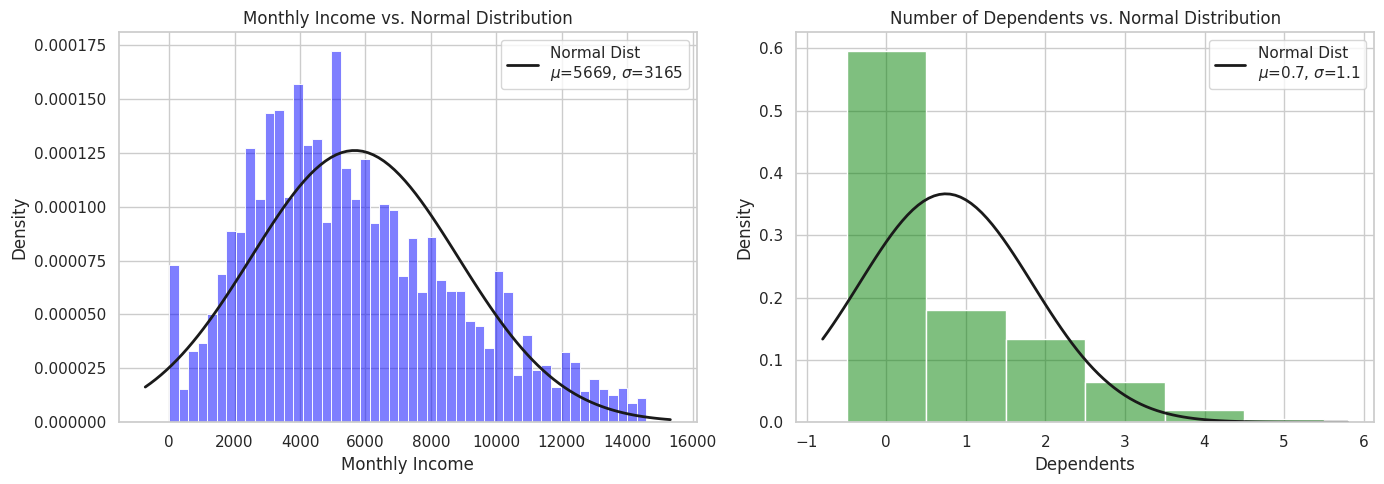

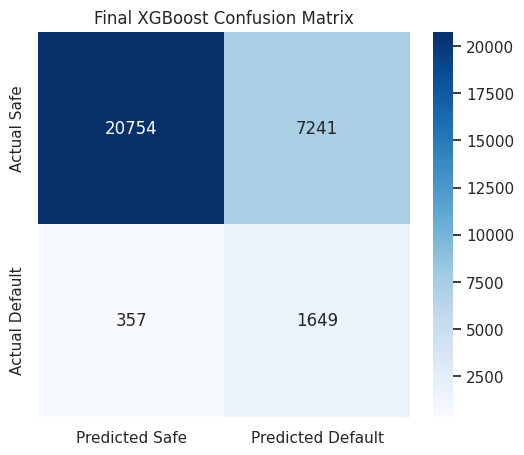

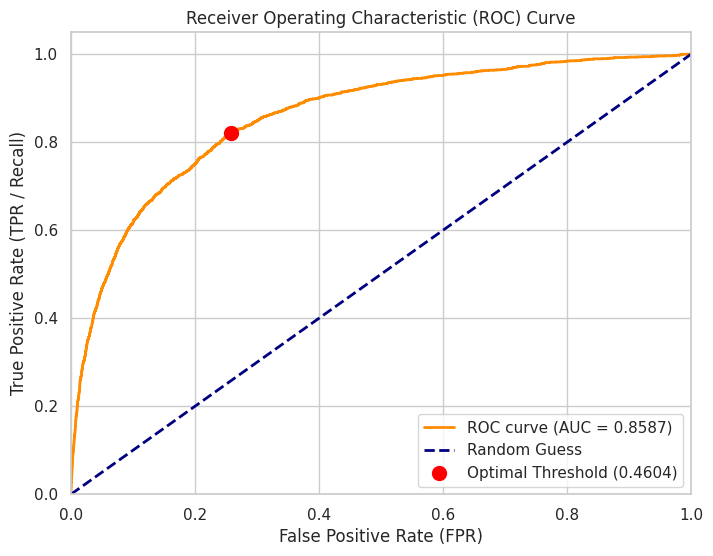

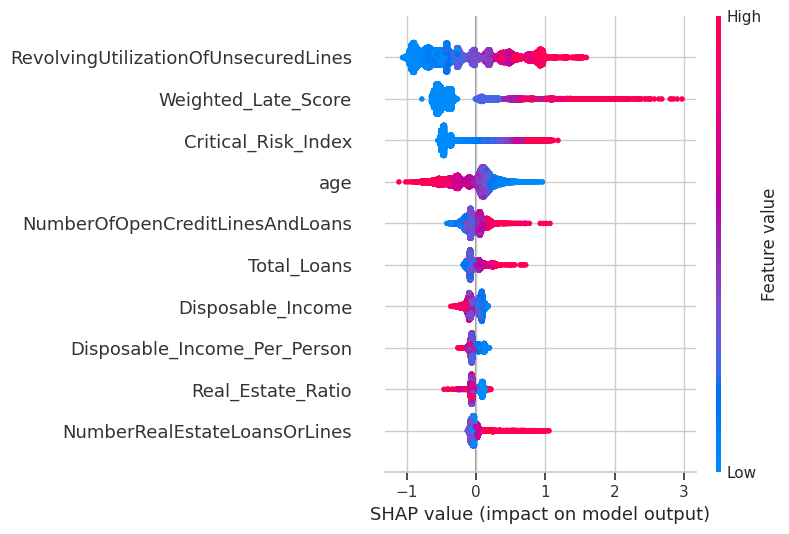

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score,
                             recall_score, f1_score, confusion_matrix, roc_curve)

# ==========================================
# 0. LOAD DATA 📥
# ==========================================
df = pd.read_csv('cs-training.csv', index_col=0)

# ==========================================
# 1. EDA: NORMAL DISTRIBUTION CHECK 📊
# ==========================================
plt.figure(figsize=(14, 5))
sns.set_theme(style="whitegrid")

# Plot 1: Monthly Income
plt.subplot(1, 2, 1)
inc_data = df['MonthlyIncome'].dropna()
inc_data = inc_data[inc_data < inc_data.quantile(0.95)]
sns.histplot(inc_data, bins=50, kde=False, stat='density', color='blue', alpha=0.5)
mu_inc, std_inc = stats.norm.fit(inc_data)
xmin_inc, xmax_inc = plt.xlim()
x_inc = np.linspace(xmin_inc, xmax_inc, 100)
p_inc = stats.norm.pdf(x_inc, mu_inc, std_inc)
plt.plot(x_inc, p_inc, 'k', linewidth=2, label=f'Normal Dist\n$\mu$={mu_inc:.0f}, $\sigma$={std_inc:.0f}')
plt.title('Monthly Income vs. Normal Distribution')
plt.xlabel('Monthly Income')
plt.legend()

# Plot 2: Number of Dependents
plt.subplot(1, 2, 2)
dep_data = df['NumberOfDependents'].dropna()
dep_data = dep_data[dep_data <= 5]
sns.histplot(dep_data, discrete=True, stat='density', color='green', alpha=0.5)
mu_dep, std_dep = stats.norm.fit(dep_data)
xmin_dep, xmax_dep = plt.xlim()
x_dep = np.linspace(xmin_dep, xmax_dep, 100)
p_dep = stats.norm.pdf(x_dep, mu_dep, std_dep)
plt.plot(x_dep, p_dep, 'k', linewidth=2, label=f'Normal Dist\n$\mu$={mu_dep:.1f}, $\sigma$={std_dep:.1f}')
plt.title('Number of Dependents vs. Normal Distribution')
plt.xlabel('Dependents')
plt.legend()

plt.tight_layout()
plt.savefig('normal_distributions_xgb.png')
print("✅ EDA Visualizations Generated: 'normal_distributions_xgb.png'")

# ==========================================
# 2. SMART SPLITTER & IMPUTER 🧠
# ==========================================
total_defaults = (df['SeriousDlqin2yrs'] == 1).sum()
req_test_defaults = int(np.ceil(0.2 * total_defaults))
req_test_good = int(np.ceil(0.2 * (df['SeriousDlqin2yrs'] == 0).sum()))

clean_df = df.dropna()

if clean_df[clean_df['SeriousDlqin2yrs'] == 1].shape[0] >= req_test_defaults:
    test_df = pd.concat([
        clean_df[clean_df['SeriousDlqin2yrs'] == 1].sample(n=req_test_defaults, random_state=42),
        clean_df[clean_df['SeriousDlqin2yrs'] == 0].sample(n=req_test_good, random_state=42)
    ])
    train_df = df.drop(test_df.index)

    train_df['MonthlyIncome'] = train_df['MonthlyIncome'].fillna(
        train_df.groupby('NumberOfDependents')['MonthlyIncome'].transform('median')
    )
    train_df['MonthlyIncome'] = train_df['MonthlyIncome'].fillna(train_df['MonthlyIncome'].median())
    train_df['NumberOfDependents'] = train_df['NumberOfDependents'].fillna(train_df['NumberOfDependents'].median())
else:
    df_imputed = df.copy()
    df_imputed['MonthlyIncome'] = df_imputed['MonthlyIncome'].fillna(df_imputed['MonthlyIncome'].median())
    df_imputed['NumberOfDependents'] = df_imputed['NumberOfDependents'].fillna(df_imputed['NumberOfDependents'].median())
    train_df, test_df = train_test_split(df_imputed, test_size=0.2, stratify=df_imputed['SeriousDlqin2yrs'], random_state=42)

# ==========================================
# 3. FEATURE ENGINEERING 🛠️
# ==========================================
def add_features(data):
    d = data.copy()
    d['Weighted_Late_Score'] = (
        (1 * d['NumberOfTime30-59DaysPastDueNotWorse']) +
        (2 * d['NumberOfTime60-89DaysPastDueNotWorse']) +
        (3 * d['NumberOfTimes90DaysLate'])
    )
    d['Critical_Risk_Index'] = d['RevolvingUtilizationOfUnsecuredLines'] * d['Weighted_Late_Score']
    d['Total_Loans'] = d['NumberOfOpenCreditLinesAndLoans'] + d['NumberRealEstateLoansOrLines']
    d['Real_Estate_Ratio'] = np.where(d['Total_Loans'] > 0, d['NumberRealEstateLoansOrLines'] / d['Total_Loans'], -1)
    d['Monthly_Debt_Amount'] = d['DebtRatio'] * d['MonthlyIncome']
    d['Disposable_Income'] = d['MonthlyIncome'] - d['Monthly_Debt_Amount']
    d['Disposable_Income_Per_Person'] = d['Disposable_Income'] / (d['NumberOfDependents'] + 1)

    # Drop original columns
    d = d.drop(columns=['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate'])
    return d

train_df = add_features(train_df)
test_df = add_features(test_df)

X_train = train_df.drop('SeriousDlqin2yrs', axis=1)
y_train = train_df['SeriousDlqin2yrs']
X_test = test_df.drop('SeriousDlqin2yrs', axis=1)
y_test = test_df['SeriousDlqin2yrs']

imbalance_ratio = (y_train == 0).sum() / (y_train == 1).sum()

# ==========================================
# 4. OPTUNA BAYESIAN TUNING 🤖
# ==========================================
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 400),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'scale_pos_weight': imbalance_ratio,
        'random_state': 42,
        'eval_metric': 'auc',
        'n_jobs': -1
    }
    model = xgb.XGBClassifier(**param)
    return cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc').mean()

print("⏳ Running Bayesian Optimization (Optuna)...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)

best_model = xgb.XGBClassifier(**study.best_params, scale_pos_weight=imbalance_ratio, random_state=42)
best_model.fit(X_train, y_train)

# ==========================================
# 5. COMPREHENSIVE METRICS EVALUATION 🏆
# ==========================================
y_probs = best_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_probs)

fpr_c, tpr_c, thresh = roc_curve(y_test, y_probs)
opt_idx = np.argmax(tpr_c - fpr_c)
best_t = thresh[opt_idx]

y_pred = (y_probs >= best_t).astype(int)

# Core Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
fpr_val = fp / (fp + tn)

print("\n========== 🏆 FULL MODEL EVALUATION ==========")
print(f"AUC Score:             {auc:.4f}  <-- Overall predictive power")
print(f"Accuracy:              {acc:.4f}  <-- Total correct predictions")
print(f"Precision:             {prec:.4f}  <-- When predicting Default, % correct")
print(f"Recall (TPR):          {rec:.4f}  <-- % of actual Defaults caught")
print(f"F1-Score:              {f1:.4f}  <-- Harmonic mean of Precision & Recall")
print(f"False Alarm Rate (FPR):{fpr_val:.4f}  <-- % of Good clients falsely flagged")

# Visualizations
plt.figure(figsize=(6, 5))
sns.heatmap([[tn, fp], [fn, tp]], annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Safe', 'Predicted Default'],
            yticklabels=['Actual Safe', 'Actual Default'])
plt.title('Final XGBoost Confusion Matrix')
plt.savefig('final_confusion_matrix_xgb.png')
print("✅ Confusion Matrix Generated: 'final_confusion_matrix_xgb.png'")

plt.figure(figsize=(8, 6))
plt.plot(fpr_c, tpr_c, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.scatter(fpr_val, rec, color='red', s=100, zorder=5, label=f'Optimal Threshold ({best_t:.4f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR / Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('roc_curve_xgboost.png')
print("✅ ROC Curve Generated: 'roc_curve_xgboost.png'")

# ==========================================
# 6. DYNAMIC BUSINESS IMPACT CALCULATOR 💰
# ==========================================
results = X_test.copy()
results['Actual_Default'] = y_test
results['Prob_Default'] = y_probs
results['Prediction'] = y_pred

# Dynamic Logic
results['Estimated_Loan'] = results['MonthlyIncome'] * 3
results['Recovery_Rate'] = np.where(results['Total_Loans'] > results['NumberOfOpenCreditLinesAndLoans'], 0.50, 0.10)

def calculate_net_impact(row):
    loan = row['Estimated_Loan']
    if row['Actual_Default'] == 0 and row['Prediction'] == 0: return loan * 0.15
    elif row['Actual_Default'] == 0 and row['Prediction'] == 1: return -(loan * 0.15)
    elif row['Actual_Default'] == 1 and row['Prediction'] == 1: return 0
    elif row['Actual_Default'] == 1 and row['Prediction'] == 0: return -(loan * (1 - row['Recovery_Rate']))
    return 0

results['Net_Result'] = results.apply(calculate_net_impact, axis=1)
total_economic_impact = results['Net_Result'].sum()

print("\n========== 💰 ECONOMIC IMPACT ==========")
print(f"TOTAL PROJECTED PROFIT:  ${total_economic_impact:,.2f}")
print(f"PROFIT PER APPLICANT:    ${total_economic_impact/len(results):,.2f}")

# ==========================================
# 7. BIAS AUDIT ⚖️
# ==========================================
X_test_age = X_test.copy()
results_bias = pd.DataFrame({
    'age': X_test_age['age'],
    'actual': y_test,
    'pred': y_pred
})

young_approved = results_bias[results_bias['age'] < 30]['pred'].value_counts(normalize=True).get(0, 0)
senior_approved = results_bias[results_bias['age'] >= 30]['pred'].value_counts(normalize=True).get(0, 0)

disparate_impact = young_approved / senior_approved

print("\n========== ⚖️ BIAS AUDIT ==========")
print(f"Young Approval Rate:  {young_approved:.2%}")
print(f"Senior Approval Rate: {senior_approved:.2%}")
print(f"Disparate Impact:     {disparate_impact:.4f}")

if disparate_impact < 0.8:
    print("🚨 ALERT: Model shows significant bias against young applicants!")
else:
    print("✅ Model passes the 80% fairness rule.")

# ==========================================
# 8. SHAP SUMMARY 🔍
# ==========================================
plt.figure()
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="dot", max_display=10, show=False)
plt.savefig('shap_summary.png', bbox_inches='tight')
print("✅ SHAP Plot Generated: 'shap_summary.png'")

# ==========================================
# 9. RISK TIER CATEGORIZATION 🚦
# ==========================================
high_risk_thresh = best_t
medium_risk_thresh = 0.15

def categorize_risk(prob):
    if prob >= high_risk_thresh:
        return "High Risk (Auto-Reject)"
    elif prob >= medium_risk_thresh:
        return "Medium Risk (Manual Review)"
    else:
        return "Low Risk (Auto-Approve)"

results['Risk_Tier'] = results['Prob_Default'].apply(categorize_risk)

tier_summary = results.groupby('Risk_Tier').agg(
    Total_Applicants=('Actual_Default', 'count'),
    Actual_Defaulters=('Actual_Default', 'sum'),
    Total_Profit=('Net_Result', 'sum')
).reset_index()

# Format profit as string for clean printing
tier_summary['Total_Profit'] = tier_summary['Total_Profit'].apply(lambda x: f"${x:,.2f}")

print("\n========== 🚦 RISK TIER CATEGORIZATION ==========")
print(f"Low Risk (Auto-Approve):       0.00 to {medium_risk_thresh:.2f}")
print(f"Medium Risk (Manual Review):   {medium_risk_thresh:.2f} to {high_risk_thresh:.4f}")
print(f"High Risk (Auto-Reject):       > {high_risk_thresh:.4f}")
print("\n--- TIER IMPACT SUMMARY ---")
print(tier_summary.to_string(index=False))
print("=================================================")

<>:33: SyntaxWarning: invalid escape sequence '\m'
<>:33: SyntaxWarning: invalid escape sequence '\s'
<>:47: SyntaxWarning: invalid escape sequence '\m'
<>:47: SyntaxWarning: invalid escape sequence '\s'
<>:33: SyntaxWarning: invalid escape sequence '\m'
<>:33: SyntaxWarning: invalid escape sequence '\s'
<>:47: SyntaxWarning: invalid escape sequence '\m'
<>:47: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3957457144.py:33: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(x_inc, p_inc, 'k', linewidth=2, label=f'Normal Dist\n$\mu$={mu_inc:.0f}, $\sigma$={std_inc:.0f}')
/tmp/ipython-input-3957457144.py:33: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x_inc, p_inc, 'k', linewidth=2, label=f'Normal Dist\n$\mu$={mu_inc:.0f}, $\sigma$={std_inc:.0f}')
/tmp/ipython-input-3957457144.py:47: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(x_dep, p_dep, 'k', linewidth=2, label=f'Normal Dist\n$\mu$={mu_dep:.1f}, $\sigma$={std_dep:.1f}')
/tmp/ipython-input-395

✅ EDA Visualizations Generated: 'normal_distributions_xgb.png'


/tmp/ipython-input-3957457144.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-3957457144.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-3957457144.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-3957457144.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-3957457144.py:77: FutureWarning: 

Passin

✅ EDA Visualizations Generated: 'raw_feature_ranges_boxplot.png'


[I 2026-02-17 19:52:58,469] A new study created in memory with name: no-name-aa764d94-f529-43dc-83b7-f64980c9f024


⏳ Running Bayesian Optimization (Optuna)...


[I 2026-02-17 19:53:05,904] Trial 0 finished with value: 0.8604253742437044 and parameters: {'max_depth': 3, 'learning_rate': 0.013216730255227427, 'n_estimators': 130, 'subsample': 0.7429897114475243, 'colsample_bytree': 0.7993189532807444}. Best is trial 0 with value: 0.8604253742437044.
[I 2026-02-17 19:53:17,835] Trial 1 finished with value: 0.8471723090891544 and parameters: {'max_depth': 6, 'learning_rate': 0.11333375165338556, 'n_estimators': 296, 'subsample': 0.635539261954583, 'colsample_bytree': 0.7912533844793609}. Best is trial 0 with value: 0.8604253742437044.
[I 2026-02-17 19:53:24,688] Trial 2 finished with value: 0.864744414909727 and parameters: {'max_depth': 6, 'learning_rate': 0.035662277734611, 'n_estimators': 217, 'subsample': 0.8023675043846523, 'colsample_bytree': 0.9520489954534929}. Best is trial 2 with value: 0.864744414909727.
[I 2026-02-17 19:53:35,657] Trial 3 finished with value: 0.8606947924801504 and parameters: {'max_depth': 6, 'learning_rate': 0.053132


========== 🏆 FULL MODEL EVALUATION ==========
AUC Score:             0.8582  <-- Overall predictive power
Accuracy:              0.7599  <-- Total correct predictions
Precision:             0.1923  <-- When predicting Default, % correct
Recall (TPR):          0.8096  <-- % of actual Defaults caught
F1-Score:              0.3108  <-- Harmonic mean of Precision & Recall
False Alarm Rate (FPR):0.2437  <-- % of Good clients falsely flagged
✅ Confusion Matrix Generated: 'final_confusion_matrix_xgb.png'
✅ ROC Curve Generated: 'roc_curve_xgboost.png'

========== 💰 ECONOMIC IMPACT ==========
TOTAL PROJECTED PROFIT:  $44,628,806.85
PROFIT PER APPLICANT:    $1,487.58

========== ⚖️ BIAS AUDIT ==========
Young Approval Rate:  53.39%
Senior Approval Rate: 73.05%
Disparate Impact:     0.7309
🚨 ALERT: Model shows significant bias against young applicants!
✅ SHAP Plot Generated: 'shap_summary.png'

========== 🚦 RISK TIER CATEGORIZATION ==========
Low Risk (Auto-Approve):       0.00 to 0.15
Medium Ri

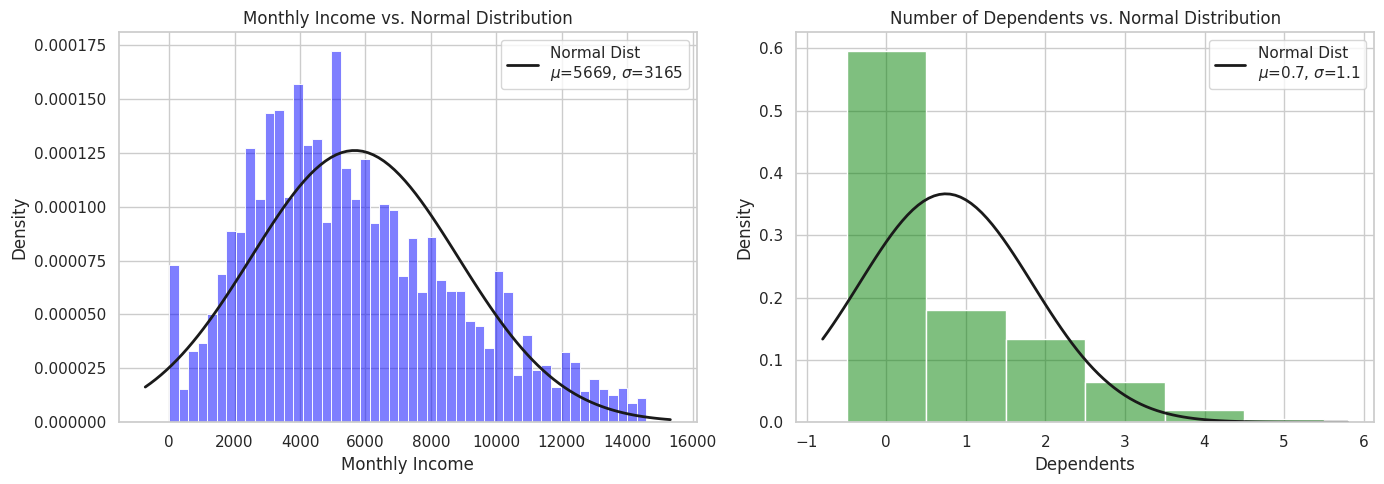

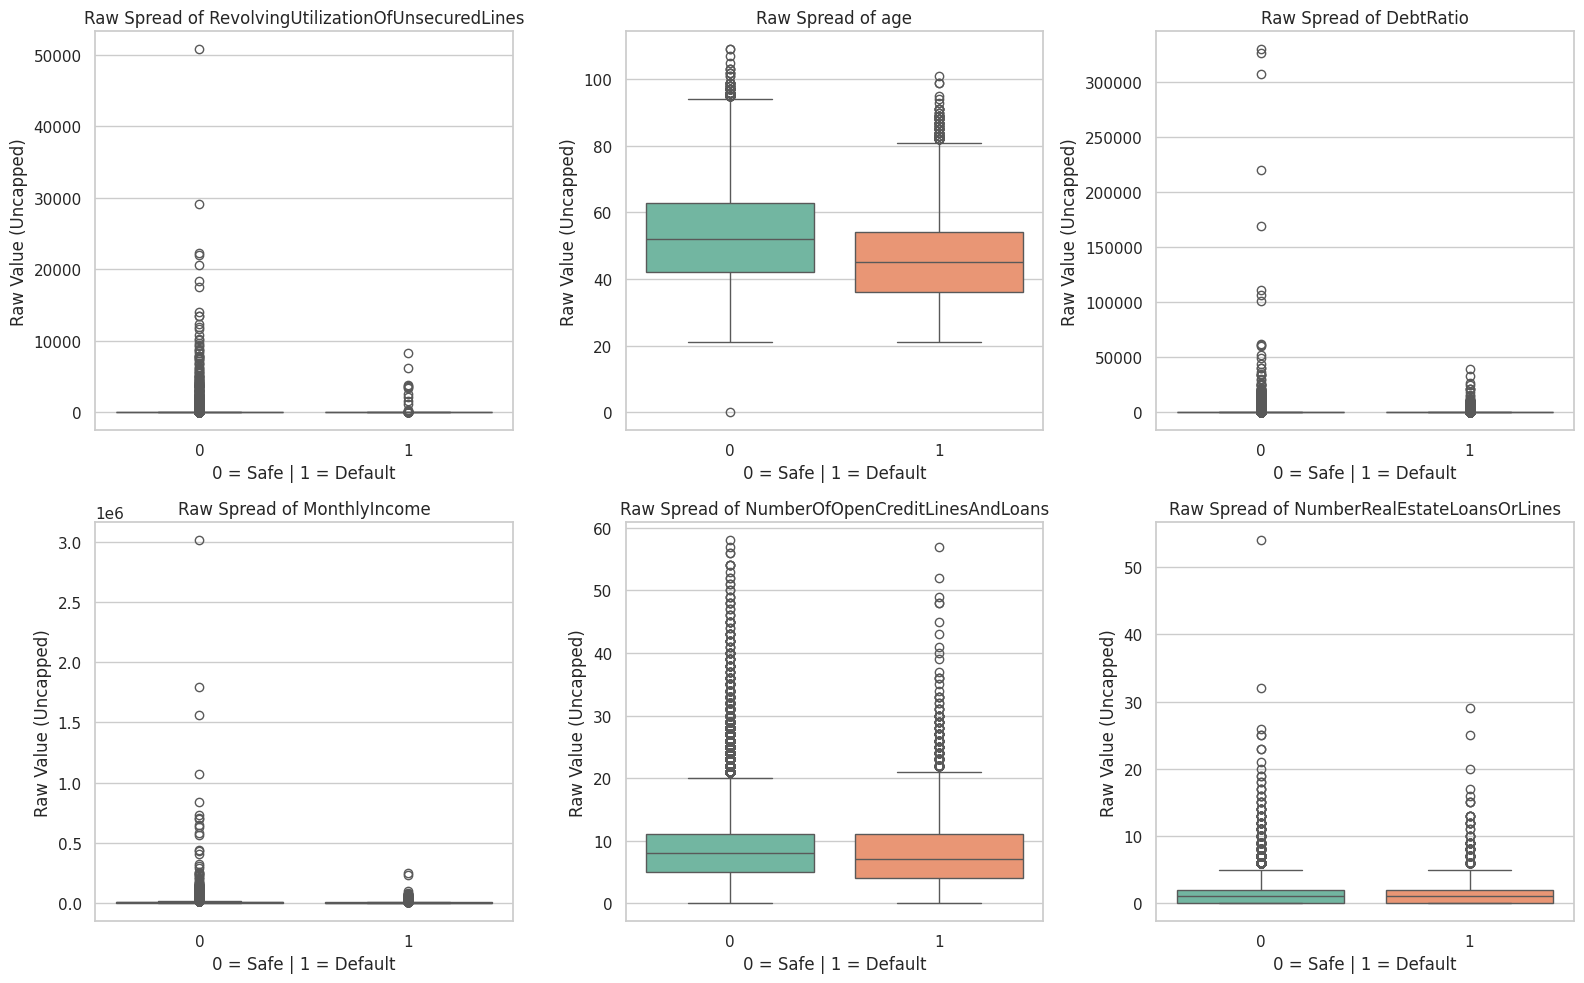

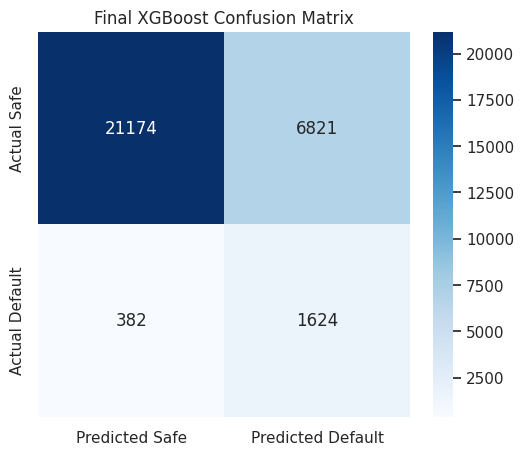

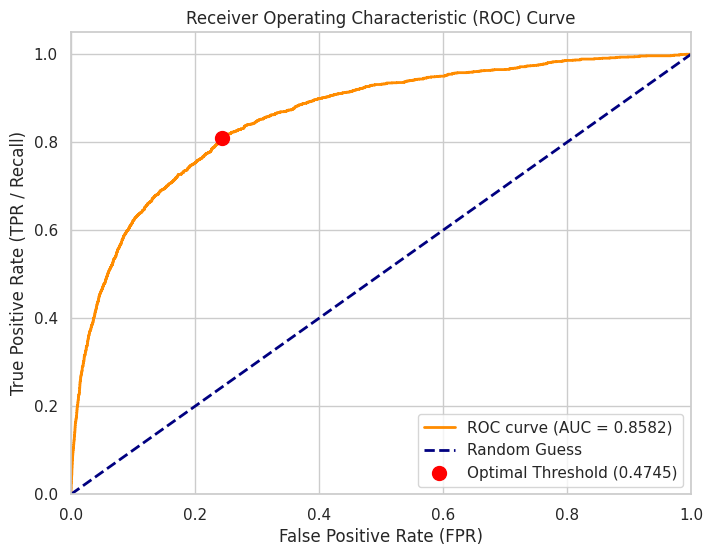

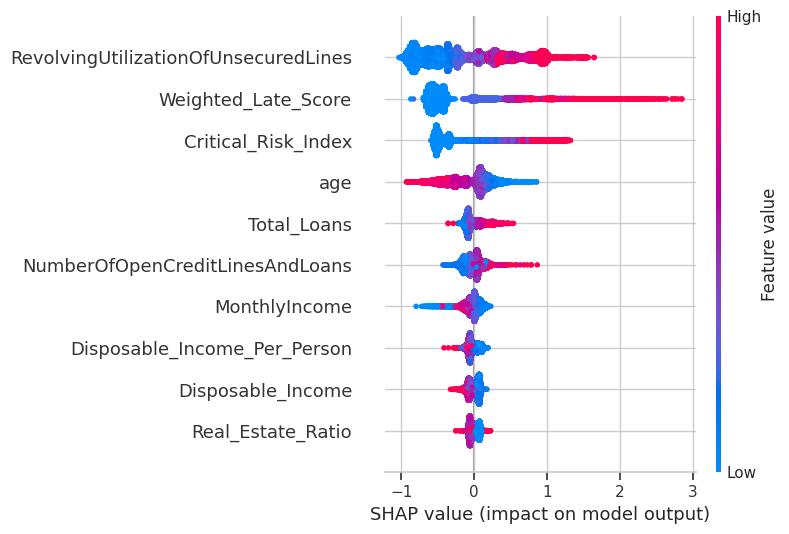

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score,
                             recall_score, f1_score, confusion_matrix, roc_curve)

# ==========================================
# 0. LOAD DATA 📥
# ==========================================
df = pd.read_csv('cs-training.csv', index_col=0)

# ==========================================
# 1A. EDA: NORMAL DISTRIBUTION CHECK 📊
# ==========================================
plt.figure(figsize=(14, 5))
sns.set_theme(style="whitegrid")

# Plot 1: Monthly Income
plt.subplot(1, 2, 1)
inc_data = df['MonthlyIncome'].dropna()
inc_data = inc_data[inc_data < inc_data.quantile(0.95)] # Drop top 5% ONLY for the bell curve visual fit
sns.histplot(inc_data, bins=50, kde=False, stat='density', color='blue', alpha=0.5)
mu_inc, std_inc = stats.norm.fit(inc_data)
xmin_inc, xmax_inc = plt.xlim()
x_inc = np.linspace(xmin_inc, xmax_inc, 100)
p_inc = stats.norm.pdf(x_inc, mu_inc, std_inc)
plt.plot(x_inc, p_inc, 'k', linewidth=2, label=f'Normal Dist\n$\mu$={mu_inc:.0f}, $\sigma$={std_inc:.0f}')
plt.title('Monthly Income vs. Normal Distribution')
plt.xlabel('Monthly Income')
plt.legend()

# Plot 2: Number of Dependents
plt.subplot(1, 2, 2)
dep_data = df['NumberOfDependents'].dropna()
dep_data = dep_data[dep_data <= 5]
sns.histplot(dep_data, discrete=True, stat='density', color='green', alpha=0.5)
mu_dep, std_dep = stats.norm.fit(dep_data)
xmin_dep, xmax_dep = plt.xlim()
x_dep = np.linspace(xmin_dep, xmax_dep, 100)
p_dep = stats.norm.pdf(x_dep, mu_dep, std_dep)
plt.plot(x_dep, p_dep, 'k', linewidth=2, label=f'Normal Dist\n$\mu$={mu_dep:.1f}, $\sigma$={std_dep:.1f}')
plt.title('Number of Dependents vs. Normal Distribution')
plt.xlabel('Dependents')
plt.legend()

plt.tight_layout()
plt.savefig('normal_distributions_xgb.png')
print("✅ EDA Visualizations Generated: 'normal_distributions_xgb.png'")

# ==========================================
# 1B. EDA: RAW FEATURE RANGES & OUTLIERS (BOXPLOTS) 📊
# ==========================================
plt.figure(figsize=(16, 10))

# Select key continuous features to visualize their raw ranges
features_to_plot = [
    'RevolvingUtilizationOfUnsecuredLines',
    'age',
    'DebtRatio',
    'MonthlyIncome',
    'NumberOfOpenCreditLinesAndLoans',
    'NumberRealEstateLoansOrLines'
]

for i, col in enumerate(features_to_plot, 1):
    plt.subplot(2, 3, i)

    # Using entirely RAW data (no capping) to expose the extreme outliers
    plot_data = df.dropna(subset=[col])

    sns.boxplot(
        data=plot_data,
        x='SeriousDlqin2yrs',
        y=col,
        palette='Set2'
    )
    plt.title(f'Raw Spread of {col}')
    plt.xlabel('0 = Safe | 1 = Default')
    plt.ylabel('Raw Value (Uncapped)')

plt.tight_layout()
plt.savefig('raw_feature_ranges_boxplot.png')
print("✅ EDA Visualizations Generated: 'raw_feature_ranges_boxplot.png'")

# ==========================================
# 2. SMART SPLITTER & IMPUTER 🧠
# ==========================================
total_defaults = (df['SeriousDlqin2yrs'] == 1).sum()
req_test_defaults = int(np.ceil(0.2 * total_defaults))
req_test_good = int(np.ceil(0.2 * (df['SeriousDlqin2yrs'] == 0).sum()))

clean_df = df.dropna()

if clean_df[clean_df['SeriousDlqin2yrs'] == 1].shape[0] >= req_test_defaults:
    test_df = pd.concat([
        clean_df[clean_df['SeriousDlqin2yrs'] == 1].sample(n=req_test_defaults, random_state=42),
        clean_df[clean_df['SeriousDlqin2yrs'] == 0].sample(n=req_test_good, random_state=42)
    ])
    train_df = df.drop(test_df.index)

    # Impute Training Only to prevent Data Leakage
    train_df['MonthlyIncome'] = train_df['MonthlyIncome'].fillna(
        train_df.groupby('NumberOfDependents')['MonthlyIncome'].transform('median')
    )
    train_df['MonthlyIncome'] = train_df['MonthlyIncome'].fillna(train_df['MonthlyIncome'].median())
    train_df['NumberOfDependents'] = train_df['NumberOfDependents'].fillna(train_df['NumberOfDependents'].median())
else:
    df_imputed = df.copy()
    df_imputed['MonthlyIncome'] = df_imputed['MonthlyIncome'].fillna(df_imputed['MonthlyIncome'].median())
    df_imputed['NumberOfDependents'] = df_imputed['NumberOfDependents'].fillna(df_imputed['NumberOfDependents'].median())
    train_df, test_df = train_test_split(df_imputed, test_size=0.2, stratify=df_imputed['SeriousDlqin2yrs'], random_state=42)

# ==========================================
# 3. FEATURE ENGINEERING 🛠️
# ==========================================
def add_features(data):
    d = data.copy()
    d['Weighted_Late_Score'] = (
        (1 * d['NumberOfTime30-59DaysPastDueNotWorse']) +
        (2 * d['NumberOfTime60-89DaysPastDueNotWorse']) +
        (3 * d['NumberOfTimes90DaysLate'])
    )
    d['Critical_Risk_Index'] = d['RevolvingUtilizationOfUnsecuredLines'] * d['Weighted_Late_Score']
    d['Total_Loans'] = d['NumberOfOpenCreditLinesAndLoans'] + d['NumberRealEstateLoansOrLines']
    d['Real_Estate_Ratio'] = np.where(d['Total_Loans'] > 0, d['NumberRealEstateLoansOrLines'] / d['Total_Loans'], -1)
    d['Monthly_Debt_Amount'] = d['DebtRatio'] * d['MonthlyIncome']
    d['Disposable_Income'] = d['MonthlyIncome'] - d['Monthly_Debt_Amount']
    d['Disposable_Income_Per_Person'] = d['Disposable_Income'] / (d['NumberOfDependents'] + 1)

    # Drop original redundant columns
    d = d.drop(columns=['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate'])
    return d

train_df = add_features(train_df)
test_df = add_features(test_df)

X_train = train_df.drop('SeriousDlqin2yrs', axis=1)
y_train = train_df['SeriousDlqin2yrs']
X_test = test_df.drop('SeriousDlqin2yrs', axis=1)
y_test = test_df['SeriousDlqin2yrs']

imbalance_ratio = (y_train == 0).sum() / (y_train == 1).sum()

# ==========================================
# 4. OPTUNA BAYESIAN TUNING 🤖
# ==========================================
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 400),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'scale_pos_weight': imbalance_ratio,
        'random_state': 42,
        'eval_metric': 'auc',
        'n_jobs': -1
    }
    model = xgb.XGBClassifier(**param)
    return cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc').mean()

print("⏳ Running Bayesian Optimization (Optuna)...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)

# Final Model Training
best_model = xgb.XGBClassifier(**study.best_params, scale_pos_weight=imbalance_ratio, random_state=42)
best_model.fit(X_train, y_train)

# ==========================================
# 5. COMPREHENSIVE METRICS EVALUATION 🏆
# ==========================================
y_probs = best_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_probs)

fpr_c, tpr_c, thresh = roc_curve(y_test, y_probs)
opt_idx = np.argmax(tpr_c - fpr_c)
best_t = thresh[opt_idx]

y_pred = (y_probs >= best_t).astype(int)

# Core Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
fpr_val = fp / (fp + tn)

print("\n========== 🏆 FULL MODEL EVALUATION ==========")
print(f"AUC Score:             {auc:.4f}  <-- Overall predictive power")
print(f"Accuracy:              {acc:.4f}  <-- Total correct predictions")
print(f"Precision:             {prec:.4f}  <-- When predicting Default, % correct")
print(f"Recall (TPR):          {rec:.4f}  <-- % of actual Defaults caught")
print(f"F1-Score:              {f1:.4f}  <-- Harmonic mean of Precision & Recall")
print(f"False Alarm Rate (FPR):{fpr_val:.4f}  <-- % of Good clients falsely flagged")

# Visualizations
plt.figure(figsize=(6, 5))
sns.heatmap([[tn, fp], [fn, tp]], annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Safe', 'Predicted Default'],
            yticklabels=['Actual Safe', 'Actual Default'])
plt.title('Final XGBoost Confusion Matrix')
plt.savefig('final_confusion_matrix_xgb.png')
print("✅ Confusion Matrix Generated: 'final_confusion_matrix_xgb.png'")

plt.figure(figsize=(8, 6))
plt.plot(fpr_c, tpr_c, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.scatter(fpr_val, rec, color='red', s=100, zorder=5, label=f'Optimal Threshold ({best_t:.4f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR / Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('roc_curve_xgboost.png')
print("✅ ROC Curve Generated: 'roc_curve_xgboost.png'")

# ==========================================
# 6. DYNAMIC BUSINESS IMPACT CALCULATOR 💰
# ==========================================
results = X_test.copy()
results['Actual_Default'] = y_test
results['Prob_Default'] = y_probs
results['Prediction'] = y_pred

# Dynamic Logic
results['Estimated_Loan'] = results['MonthlyIncome'] * 3
results['Recovery_Rate'] = np.where(results['Total_Loans'] > results['NumberOfOpenCreditLinesAndLoans'], 0.50, 0.10)

def calculate_net_impact(row):
    loan = row['Estimated_Loan']
    if row['Actual_Default'] == 0 and row['Prediction'] == 0: return loan * 0.15
    elif row['Actual_Default'] == 0 and row['Prediction'] == 1: return -(loan * 0.15)
    elif row['Actual_Default'] == 1 and row['Prediction'] == 1: return 0
    elif row['Actual_Default'] == 1 and row['Prediction'] == 0: return -(loan * (1 - row['Recovery_Rate']))
    return 0

results['Net_Result'] = results.apply(calculate_net_impact, axis=1)
total_economic_impact = results['Net_Result'].sum()

print("\n========== 💰 ECONOMIC IMPACT ==========")
print(f"TOTAL PROJECTED PROFIT:  ${total_economic_impact:,.2f}")
print(f"PROFIT PER APPLICANT:    ${total_economic_impact/len(results):,.2f}")

# ==========================================
# 7. BIAS AUDIT ⚖️
# ==========================================
X_test_age = X_test.copy()
results_bias = pd.DataFrame({
    'age': X_test_age['age'],
    'actual': y_test,
    'pred': y_pred
})

young_approved = results_bias[results_bias['age'] < 30]['pred'].value_counts(normalize=True).get(0, 0)
senior_approved = results_bias[results_bias['age'] >= 30]['pred'].value_counts(normalize=True).get(0, 0)

disparate_impact = young_approved / senior_approved

print("\n========== ⚖️ BIAS AUDIT ==========")
print(f"Young Approval Rate:  {young_approved:.2%}")
print(f"Senior Approval Rate: {senior_approved:.2%}")
print(f"Disparate Impact:     {disparate_impact:.4f}")

if disparate_impact < 0.8:
    print("🚨 ALERT: Model shows significant bias against young applicants!")
else:
    print("✅ Model passes the 80% fairness rule.")

# ==========================================
# 8. SHAP SUMMARY 🔍
# ==========================================
plt.figure()
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="dot", max_display=10, show=False)
plt.savefig('shap_summary.png', bbox_inches='tight')
print("✅ SHAP Plot Generated: 'shap_summary.png'")

# ==========================================
# 9. RISK TIER CATEGORIZATION 🚦
# ==========================================
high_risk_thresh = best_t
medium_risk_thresh = 0.15

def categorize_risk(prob):
    if prob >= high_risk_thresh:
        return "High Risk (Auto-Reject)"
    elif prob >= medium_risk_thresh:
        return "Medium Risk (Manual Review)"
    else:
        return "Low Risk (Auto-Approve)"

results['Risk_Tier'] = results['Prob_Default'].apply(categorize_risk)

tier_summary = results.groupby('Risk_Tier').agg(
    Total_Applicants=('Actual_Default', 'count'),
    Actual_Defaulters=('Actual_Default', 'sum'),
    Total_Profit=('Net_Result', 'sum')
).reset_index()

# Format profit as string for clean printing
tier_summary['Total_Profit'] = tier_summary['Total_Profit'].apply(lambda x: f"${x:,.2f}")

print("\n========== 🚦 RISK TIER CATEGORIZATION ==========")
print(f"Low Risk (Auto-Approve):       0.00 to {medium_risk_thresh:.2f}")
print(f"Medium Risk (Manual Review):   {medium_risk_thresh:.2f} to {high_risk_thresh:.4f}")
print(f"High Risk (Auto-Reject):       > {high_risk_thresh:.4f}")
print("\n--- TIER IMPACT SUMMARY ---")
print(tier_summary.to_string(index=False))
print("=================================================")

Selected cell below

✅ Dropped 609 duplicate rows.

========== 📊 INITIAL DATA HEALTH CHECK ==========
Missing Values:
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29221
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3828
dtype: int64

Dataset Imbalance: 6.70% are Defaulters.

========== 🔢 SUMMARY STATISTICS (Raw Data) ==========
                                         count         mean           std  \
SeriousDlqin2yrs                      149391.0     0.066999      0.250021   
RevolvingUtilizationOfUnsecuredLines  149391.0     6.071087    250.263672   
age                                   149391.0    52.306

/tmp/ipython-input-1946614360.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='SeriousDlqin2yrs', data=df, palette='viridis')
/tmp/ipython-input-1946614360.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data, x='SeriousDlqin2yrs', y=col, palette='Set2')
/tmp/ipython-input-1946614360.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data, x='SeriousDlqin2yrs', y=col, palette='Set2')
/tmp/ipython-input-1946614360.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be re

✅ Smart Splitter: Building Test Set from pure data.

⏳ Running Bayesian Optimization (Optuna)...


[I 2026-02-18 18:55:23,026] Trial 0 finished with value: 0.8510440034985899 and parameters: {'max_depth': 6, 'learning_rate': 0.14985436334482694, 'n_estimators': 107, 'subsample': 0.6458939811593409, 'colsample_bytree': 0.9197521551212569}. Best is trial 0 with value: 0.8510440034985899.
[I 2026-02-18 18:55:29,996] Trial 1 finished with value: 0.8605664285166029 and parameters: {'max_depth': 5, 'learning_rate': 0.05970080468109141, 'n_estimators': 281, 'subsample': 0.6673475922170108, 'colsample_bytree': 0.9301345804949384}. Best is trial 1 with value: 0.8605664285166029.
[I 2026-02-18 18:55:39,195] Trial 2 finished with value: 0.8524917228011261 and parameters: {'max_depth': 4, 'learning_rate': 0.18423949832361636, 'n_estimators': 357, 'subsample': 0.9610378306173156, 'colsample_bytree': 0.7909012376718028}. Best is trial 1 with value: 0.8605664285166029.
[I 2026-02-18 18:55:45,583] Trial 3 finished with value: 0.8652998455818127 and parameters: {'max_depth': 4, 'learning_rate': 0.02


========== 🏆 FULL MODEL EVALUATION ==========
AUC Score:             0.8642
Accuracy:              0.7667
Precision:             0.1970
Recall (TPR):          0.8067
F1-Score:              0.3166
False Alarm Rate (FPR):0.2362

========== 💰 ECONOMIC IMPACT ==========
TOTAL PROJECTED PROFIT:  $43,859,052.45
PROFIT PER APPLICANT:    $1,467.89
✅ SHAP Plot Generated: 'shap_summary.png'

========== ⚖️ BIAS AUDIT ==========
Young Approval Rate:  52.27%
Senior Approval Rate: 73.85%
Disparate Impact:     0.7078
🚨 ALERT: Model shows significant bias against young applicants!

========== 🚦 RISK TIER CATEGORIZATION ==========
Low Risk (Auto-Approve):       0.00 to 0.15
Medium Risk (Manual Review):   0.15 to 0.4807
High Risk (Auto-Reject):       > 0.4807

--- TIER IMPACT SUMMARY ---
                  Risk_Tier  Total_Applicants  Actual_Defaulters    Total_Profit
    High Risk (Auto-Reject)              8200               1615 $-17,364,784.95
    Low Risk (Auto-Approve)              9231           

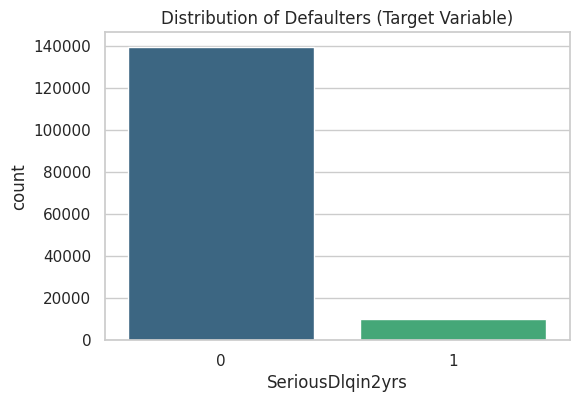

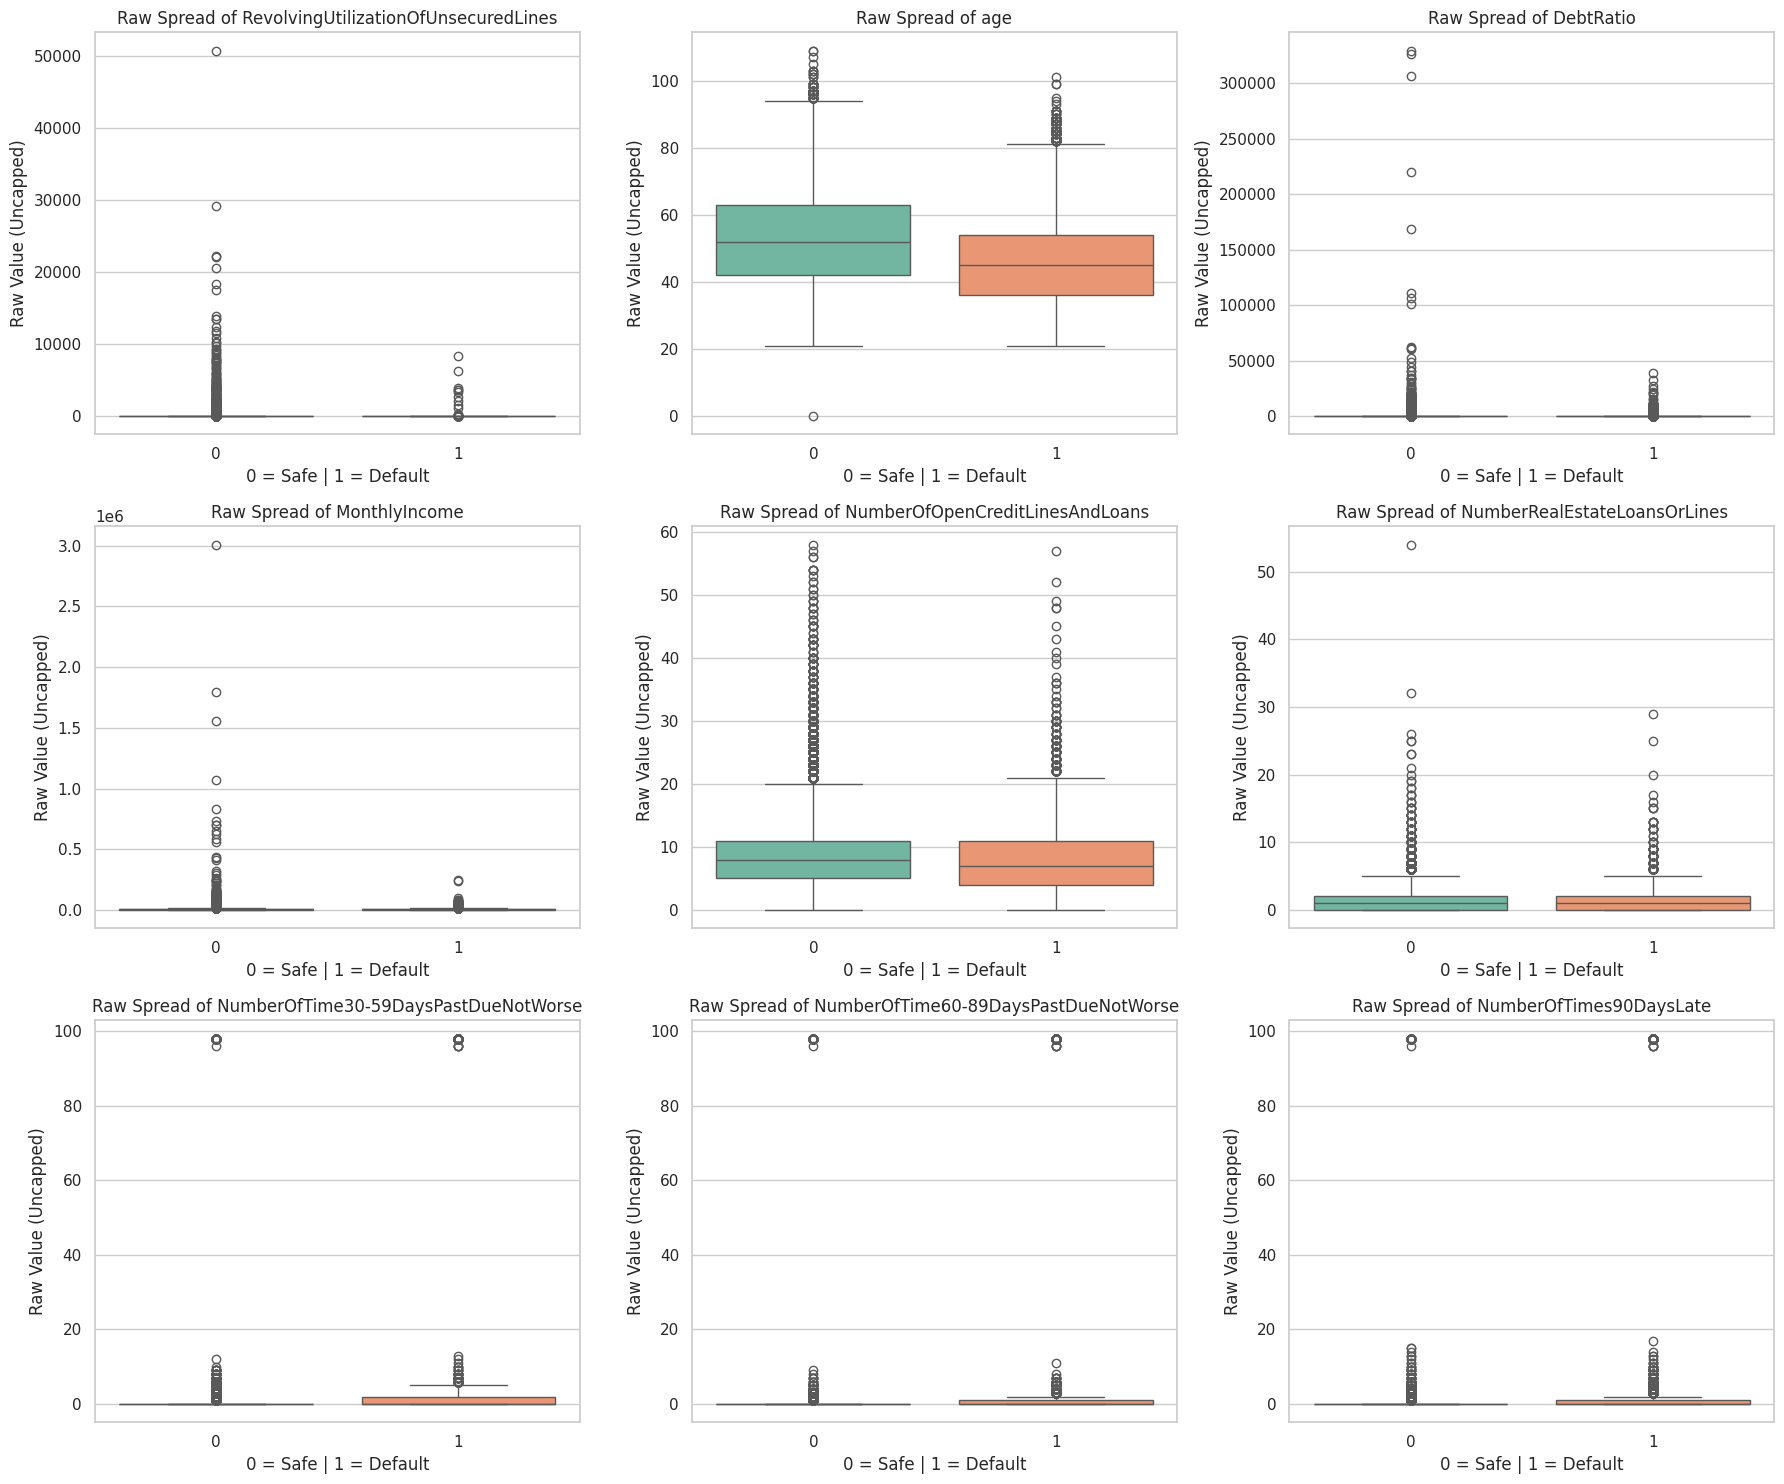

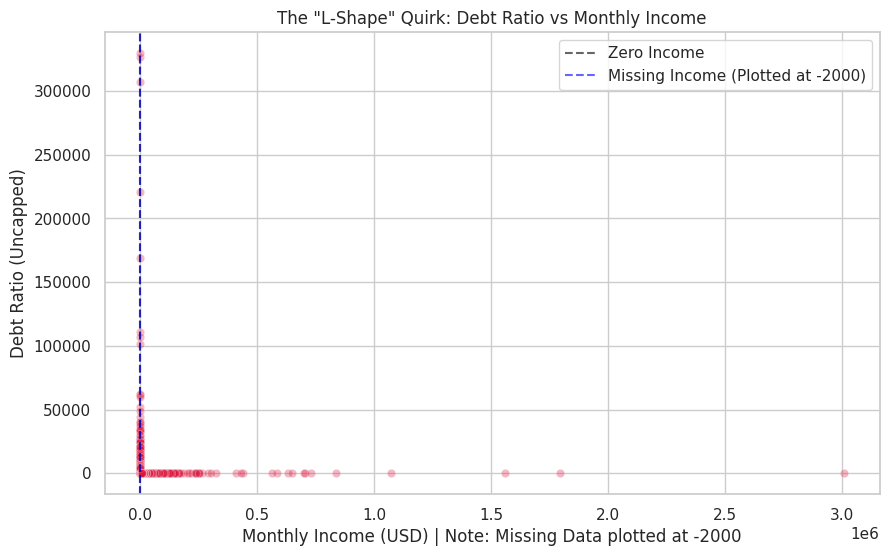

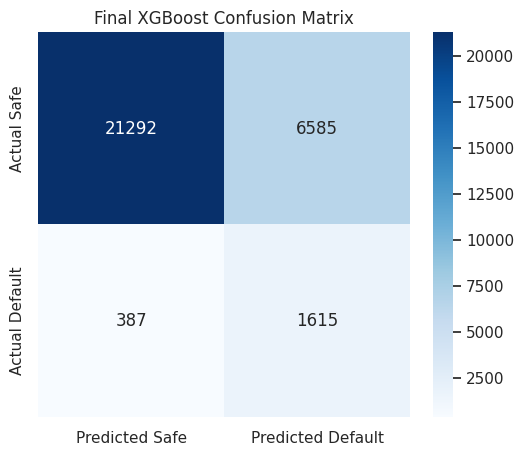

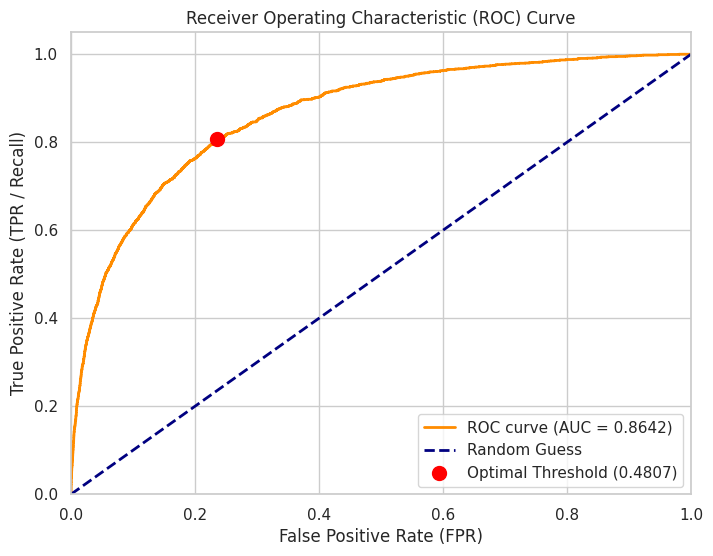

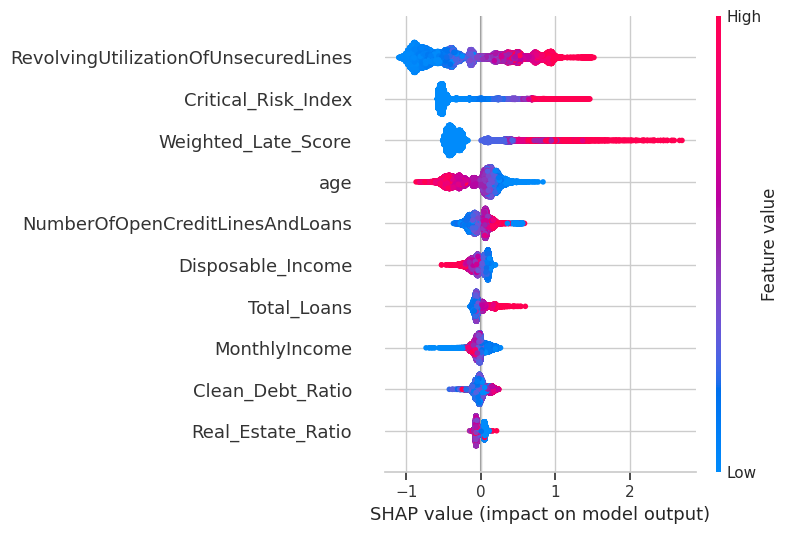

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score,
                             recall_score, f1_score, confusion_matrix, roc_curve)

# Set visual style
sns.set_theme(style="whitegrid")

# ==========================================
# 0. LOAD DATA & DROP DUPLICATES 📥
# ==========================================
df = pd.read_csv('cs-training.csv', index_col=0)

initial_shape = df.shape
df = df.drop_duplicates()
print(f"✅ Dropped {initial_shape[0] - df.shape[0]} duplicate rows.")



# ==========================================
# 1A. INITIAL EDA & TARGET DISTRIBUTION 📊
# ==========================================
print("\n========== 📊 INITIAL DATA HEALTH CHECK ==========")
print(f"Missing Values:\n{df.isnull().sum()}\n")

default_rate = df['SeriousDlqin2yrs'].mean()
print(f"Dataset Imbalance: {default_rate:.2%} are Defaulters.")


# ADD THIS BLOCK 👇
print("\n========== 🔢 SUMMARY STATISTICS (Raw Data) ==========")
# We use .T (Transpose) to make it readable. Look at the 'max' column!
print(df.describe().T)

plt.figure(figsize=(6, 4))
sns.countplot(x='SeriousDlqin2yrs', data=df, palette='viridis')
plt.title('Distribution of Defaulters (Target Variable)')
plt.savefig('target_distribution.png')

# ==========================================
# 1B. EDA: RAW FEATURE RANGES & OUTLIERS 📊
# ==========================================
plt.figure(figsize=(18, 15))
features_to_plot = [
    'RevolvingUtilizationOfUnsecuredLines', 'age', 'DebtRatio',
    'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberRealEstateLoansOrLines',
    'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate'
]

for i, col in enumerate(features_to_plot, 1):
    plt.subplot(3, 3, i)
    plot_data = df.dropna(subset=[col])
    sns.boxplot(data=plot_data, x='SeriousDlqin2yrs', y=col, palette='Set2')
    plt.title(f'Raw Spread of {col}')
    plt.xlabel('0 = Safe | 1 = Default')
    plt.ylabel('Raw Value (Uncapped)')

plt.tight_layout()
plt.savefig('raw_feature_ranges_boxplot_xgb.png')

# ==========================================
# 1C. EDA: THE "L-SHAPE" DEBT RATIO QUIRK 📊
# ==========================================
plt.figure(figsize=(10, 6))
plot_df = df[['MonthlyIncome', 'DebtRatio']].copy()
plot_df['MonthlyIncome'] = plot_df['MonthlyIncome'].fillna(-2000)

sns.scatterplot(x='MonthlyIncome', y='DebtRatio', data=plot_df, alpha=0.3, color='crimson')
plt.axvline(x=0, color='black', linestyle='--', alpha=0.6, label='Zero Income')
plt.axvline(x=-2000, color='blue', linestyle='--', alpha=0.6, label='Missing Income (Plotted at -2000)')

plt.title('The "L-Shape" Quirk: Debt Ratio vs Monthly Income')
plt.xlabel('Monthly Income (USD) | Note: Missing Data plotted at -2000')
plt.ylabel('Debt Ratio (Uncapped)')
plt.legend()
plt.savefig('l_shape_quirk.png')

# ==========================================
# 2. DATA CLEANING (SYSTEM ERRORS) 🧹
# ==========================================
late_cols = ['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate']
for col in late_cols:
    valid_median = df.loc[df[col] < 96, col].median()
    df.loc[df[col] >= 96, col] = valid_median

# ==========================================
# 3. SMART SPLITTER & IMPUTER 🧠
# ==========================================
total_defaults = (df['SeriousDlqin2yrs'] == 1).sum()
req_test_defaults = int(np.ceil(0.2 * total_defaults))
req_test_good = int(np.ceil(0.2 * (df['SeriousDlqin2yrs'] == 0).sum()))

clean_df = df.dropna()

if clean_df[clean_df['SeriousDlqin2yrs'] == 1].shape[0] >= req_test_defaults:
    print("✅ Smart Splitter: Building Test Set from pure data.")
    test_df = pd.concat([
        clean_df[clean_df['SeriousDlqin2yrs'] == 1].sample(n=req_test_defaults, random_state=42),
        clean_df[clean_df['SeriousDlqin2yrs'] == 0].sample(n=req_test_good, random_state=42)
    ])
    train_df = df.drop(test_df.index)

    train_df['MonthlyIncome'] = train_df['MonthlyIncome'].fillna(
        train_df.groupby('NumberOfDependents')['MonthlyIncome'].transform('median')
    )
    train_df['MonthlyIncome'] = train_df['MonthlyIncome'].fillna(train_df['MonthlyIncome'].median())
    train_df['NumberOfDependents'] = train_df['NumberOfDependents'].fillna(train_df['NumberOfDependents'].median())
else:
    df_imputed = df.copy()
    df_imputed['MonthlyIncome'] = df_imputed['MonthlyIncome'].fillna(df_imputed['MonthlyIncome'].median())
    df_imputed['NumberOfDependents'] = df_imputed['NumberOfDependents'].fillna(df_imputed['NumberOfDependents'].median())
    train_df, test_df = train_test_split(df_imputed, test_size=0.2, stratify=df_imputed['SeriousDlqin2yrs'], random_state=42)

# ==========================================
# 4. XGBOOST FEATURE ENGINEERING (NO AGE ENG) 🛠️
# ==========================================
def engineer_features(data):
    d = data.copy()

    # 1. Fix Age 0 Typo
    d.loc[d['age'] < 18, 'age'] = d['age'].median()

    # 2. Cap Runaway Utilization
    d['RevolvingUtilizationOfUnsecuredLines'] = np.clip(d['RevolvingUtilizationOfUnsecuredLines'], 0, 2.0)

    # 3. Reverse-Engineer DebtRatio
    d['True_Monthly_Debt'] = np.where(d['MonthlyIncome'] <= 1, d['DebtRatio'], d['DebtRatio'] * d['MonthlyIncome'])
    safe_income = np.where(d['MonthlyIncome'] <= 1, 1, d['MonthlyIncome'])
    d['Clean_Debt_Ratio'] = d['True_Monthly_Debt'] / safe_income

    # 4. Behavioral Engineering
    d['Weighted_Late_Score'] = (1 * d['NumberOfTime30-59DaysPastDueNotWorse']) + (2 * d['NumberOfTime60-89DaysPastDueNotWorse']) + (3 * d['NumberOfTimes90DaysLate'])
    d['Critical_Risk_Index'] = d['RevolvingUtilizationOfUnsecuredLines'] * d['Weighted_Late_Score']
    d['Total_Loans'] = d['NumberOfOpenCreditLinesAndLoans'] + d['NumberRealEstateLoansOrLines']
    d['Real_Estate_Ratio'] = np.where(d['Total_Loans'] > 0, d['NumberRealEstateLoansOrLines'] / d['Total_Loans'], -1)
    d['Disposable_Income'] = d['MonthlyIncome'] - d['True_Monthly_Debt']

    return d.drop(columns=['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 'DebtRatio'])

train_df_eng = engineer_features(train_df)
test_df_eng = engineer_features(test_df)

X_train = train_df_eng.drop('SeriousDlqin2yrs', axis=1)
y_train = train_df_eng['SeriousDlqin2yrs']
X_test = test_df_eng.drop('SeriousDlqin2yrs', axis=1)
y_test = test_df_eng['SeriousDlqin2yrs']

imbalance_ratio = (y_train == 0).sum() / (y_train == 1).sum()

# ==========================================
# 5. OPTUNA BAYESIAN TUNING 🤖
# ==========================================
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 400),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'scale_pos_weight': imbalance_ratio,
        'random_state': 42,
        'eval_metric': 'auc',
        'n_jobs': -1
    }
    model = xgb.XGBClassifier(**param)
    return cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc').mean()

print("\n⏳ Running Bayesian Optimization (Optuna)...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)

best_model = xgb.XGBClassifier(**study.best_params, scale_pos_weight=imbalance_ratio, random_state=42)
best_model.fit(X_train, y_train)

# ==========================================
# 6. EVALUATION & METRICS 🏆
# ==========================================
y_probs = best_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_probs)

fpr_c, tpr_c, thresh = roc_curve(y_test, y_probs)
opt_idx = np.argmax(tpr_c - fpr_c)
best_t = thresh[opt_idx]

y_pred = (y_probs >= best_t).astype(int)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
fpr_val = fp / (fp + tn)

print("\n========== 🏆 FULL MODEL EVALUATION ==========")
print(f"AUC Score:             {auc:.4f}")
print(f"Accuracy:              {acc:.4f}")
print(f"Precision:             {prec:.4f}")
print(f"Recall (TPR):          {rec:.4f}")
print(f"F1-Score:              {f1:.4f}")
print(f"False Alarm Rate (FPR):{fpr_val:.4f}")

plt.figure(figsize=(6, 5))
sns.heatmap([[tn, fp], [fn, tp]], annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Safe', 'Predicted Default'],
            yticklabels=['Actual Safe', 'Actual Default'])
plt.title('Final XGBoost Confusion Matrix')
plt.savefig('final_confusion_matrix_xgb.png')

plt.figure(figsize=(8, 6))
plt.plot(fpr_c, tpr_c, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.scatter(fpr_val, rec, color='red', s=100, zorder=5, label=f'Optimal Threshold ({best_t:.4f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR / Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('roc_curve_xgboost.png')

# ==========================================
# 7. BUSINESS IMPACT & SHAP 💰🔍
# ==========================================
results = X_test.copy()
results['Actual_Default'] = y_test
results['Prob_Default'] = y_probs
results['Prediction'] = y_pred

results['Estimated_Loan'] = results['MonthlyIncome'] * 3
results['Recovery_Rate'] = np.where(results['Total_Loans'] > results['NumberOfOpenCreditLinesAndLoans'], 0.50, 0.10)

def calculate_net_impact(row):
    loan = row['Estimated_Loan']
    if row['Actual_Default'] == 0 and row['Prediction'] == 0: return loan * 0.15
    elif row['Actual_Default'] == 0 and row['Prediction'] == 1: return -(loan * 0.15)
    elif row['Actual_Default'] == 1 and row['Prediction'] == 1: return 0
    elif row['Actual_Default'] == 1 and row['Prediction'] == 0: return -(loan * (1 - row['Recovery_Rate']))
    return 0

results['Net_Result'] = results.apply(calculate_net_impact, axis=1)
total_economic_impact = results['Net_Result'].sum()

print("\n========== 💰 ECONOMIC IMPACT ==========")
print(f"TOTAL PROJECTED PROFIT:  ${total_economic_impact:,.2f}")
print(f"PROFIT PER APPLICANT:    ${total_economic_impact/len(results):,.2f}")

plt.figure()
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="dot", max_display=10, show=False)
plt.savefig('shap_summary.png', bbox_inches='tight')
print("✅ SHAP Plot Generated: 'shap_summary.png'")

# ==========================================
# 8. AGE BIAS AUDIT ⚖️
# ==========================================
results_bias = pd.DataFrame({'age': X_test['age'], 'pred': y_pred})
young_app = (results_bias[results_bias['age'] < 30]['pred'] == 0).mean()
senior_app = (results_bias[results_bias['age'] >= 30]['pred'] == 0).mean()

print("\n========== ⚖️ BIAS AUDIT ==========")
print(f"Young Approval Rate:  {young_app:.2%}")
print(f"Senior Approval Rate: {senior_app:.2%}")

disparate_impact = young_app / senior_app
print(f"Disparate Impact:     {disparate_impact:.4f}")

if disparate_impact < 0.8:
    print("🚨 ALERT: Model shows significant bias against young applicants!")
else:
    print("✅ Model passes the 80% fairness rule.")

# ==========================================
# 9. RISK TIER CATEGORIZATION 🚦
# ==========================================
high_risk_thresh = best_t
medium_risk_thresh = 0.15

def categorize_risk(prob):
    if prob >= high_risk_thresh:
        return "High Risk (Auto-Reject)"
    elif prob >= medium_risk_thresh:
        return "Medium Risk (Manual Review)"
    else:
        return "Low Risk (Auto-Approve)"

results['Risk_Tier'] = results['Prob_Default'].apply(categorize_risk)

tier_summary = results.groupby('Risk_Tier').agg(
    Total_Applicants=('Actual_Default', 'count'),
    Actual_Defaulters=('Actual_Default', 'sum'),
    Total_Profit=('Net_Result', 'sum')
).reset_index()

tier_summary['Total_Profit'] = tier_summary['Total_Profit'].apply(lambda x: f"${x:,.2f}")

print("\n========== 🚦 RISK TIER CATEGORIZATION ==========")
print(f"Low Risk (Auto-Approve):       0.00 to {medium_risk_thresh:.2f}")
print(f"Medium Risk (Manual Review):   {medium_risk_thresh:.2f} to {high_risk_thresh:.4f}")
print(f"High Risk (Auto-Reject):       > {high_risk_thresh:.4f}")
print("\n--- TIER IMPACT SUMMARY ---")
print(tier_summary.to_string(index=False))
print("=================================================")

✅ Dropped 609 duplicate rows.

========== 📊 INITIAL DATA HEALTH CHECK ==========
Missing Values:
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29221
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3828
dtype: int64

Dataset Imbalance: 6.70% are Defaulters.


/tmp/ipython-input-1476115735.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='SeriousDlqin2yrs', data=df, palette='viridis')
/tmp/ipython-input-1476115735.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data, x='SeriousDlqin2yrs', y=col, palette='Set2')
/tmp/ipython-input-1476115735.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data, x='SeriousDlqin2yrs', y=col, palette='Set2')
/tmp/ipython-input-1476115735.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be re

✅ Smart Splitter: Building Test Set from pure data.

⏳ Running Bayesian Optimization (Optuna)...


[I 2026-02-17 22:15:13,198] Trial 0 finished with value: 0.8636472653349951 and parameters: {'max_depth': 3, 'learning_rate': 0.17811785902567684, 'n_estimators': 132, 'subsample': 0.9494964612897641, 'colsample_bytree': 0.9679888493317744}. Best is trial 0 with value: 0.8636472653349951.
[I 2026-02-17 22:15:25,137] Trial 1 finished with value: 0.8426495896769343 and parameters: {'max_depth': 7, 'learning_rate': 0.11302447197128701, 'n_estimators': 187, 'subsample': 0.6371214647700975, 'colsample_bytree': 0.8778706790541426}. Best is trial 0 with value: 0.8636472653349951.
[I 2026-02-17 22:15:38,218] Trial 2 finished with value: 0.8515496494082223 and parameters: {'max_depth': 7, 'learning_rate': 0.06809933690771422, 'n_estimators': 235, 'subsample': 0.6144740814443305, 'colsample_bytree': 0.618329706812276}. Best is trial 0 with value: 0.8636472653349951.
[I 2026-02-17 22:15:47,975] Trial 3 finished with value: 0.8512358122664337 and parameters: {'max_depth': 6, 'learning_rate': 0.096


========== 🏆 FULL MODEL EVALUATION ==========
AUC Score:             0.8644
Accuracy:              0.7692
Precision:             0.1983
Recall (TPR):          0.8037
F1-Score:              0.3182
False Alarm Rate (FPR):0.2333

========== 💰 ECONOMIC IMPACT ==========
TOTAL PROJECTED PROFIT:  $44,409,549.75
PROFIT PER APPLICANT:    $1,486.31
✅ SHAP Plot Generated: 'shap_summary.png'

========== ⚖️ BIAS AUDIT ==========
Young Approval Rate:  52.32%
Senior Approval Rate: 74.16%
Disparate Impact:     0.7056
🚨 ALERT: Model shows significant bias against young applicants!

========== 🚦 RISK TIER CATEGORIZATION ==========
Low Risk (Auto-Approve):       0.00 to 0.15
Medium Risk (Manual Review):   0.15 to 0.4837
High Risk (Auto-Reject):       > 0.4837

--- TIER IMPACT SUMMARY ---
                  Risk_Tier  Total_Applicants  Actual_Defaulters    Total_Profit
    High Risk (Auto-Reject)              8112               1609 $-17,078,847.30
    Low Risk (Auto-Approve)              9322           

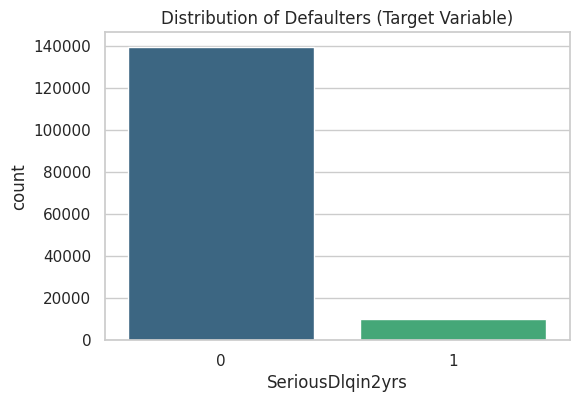

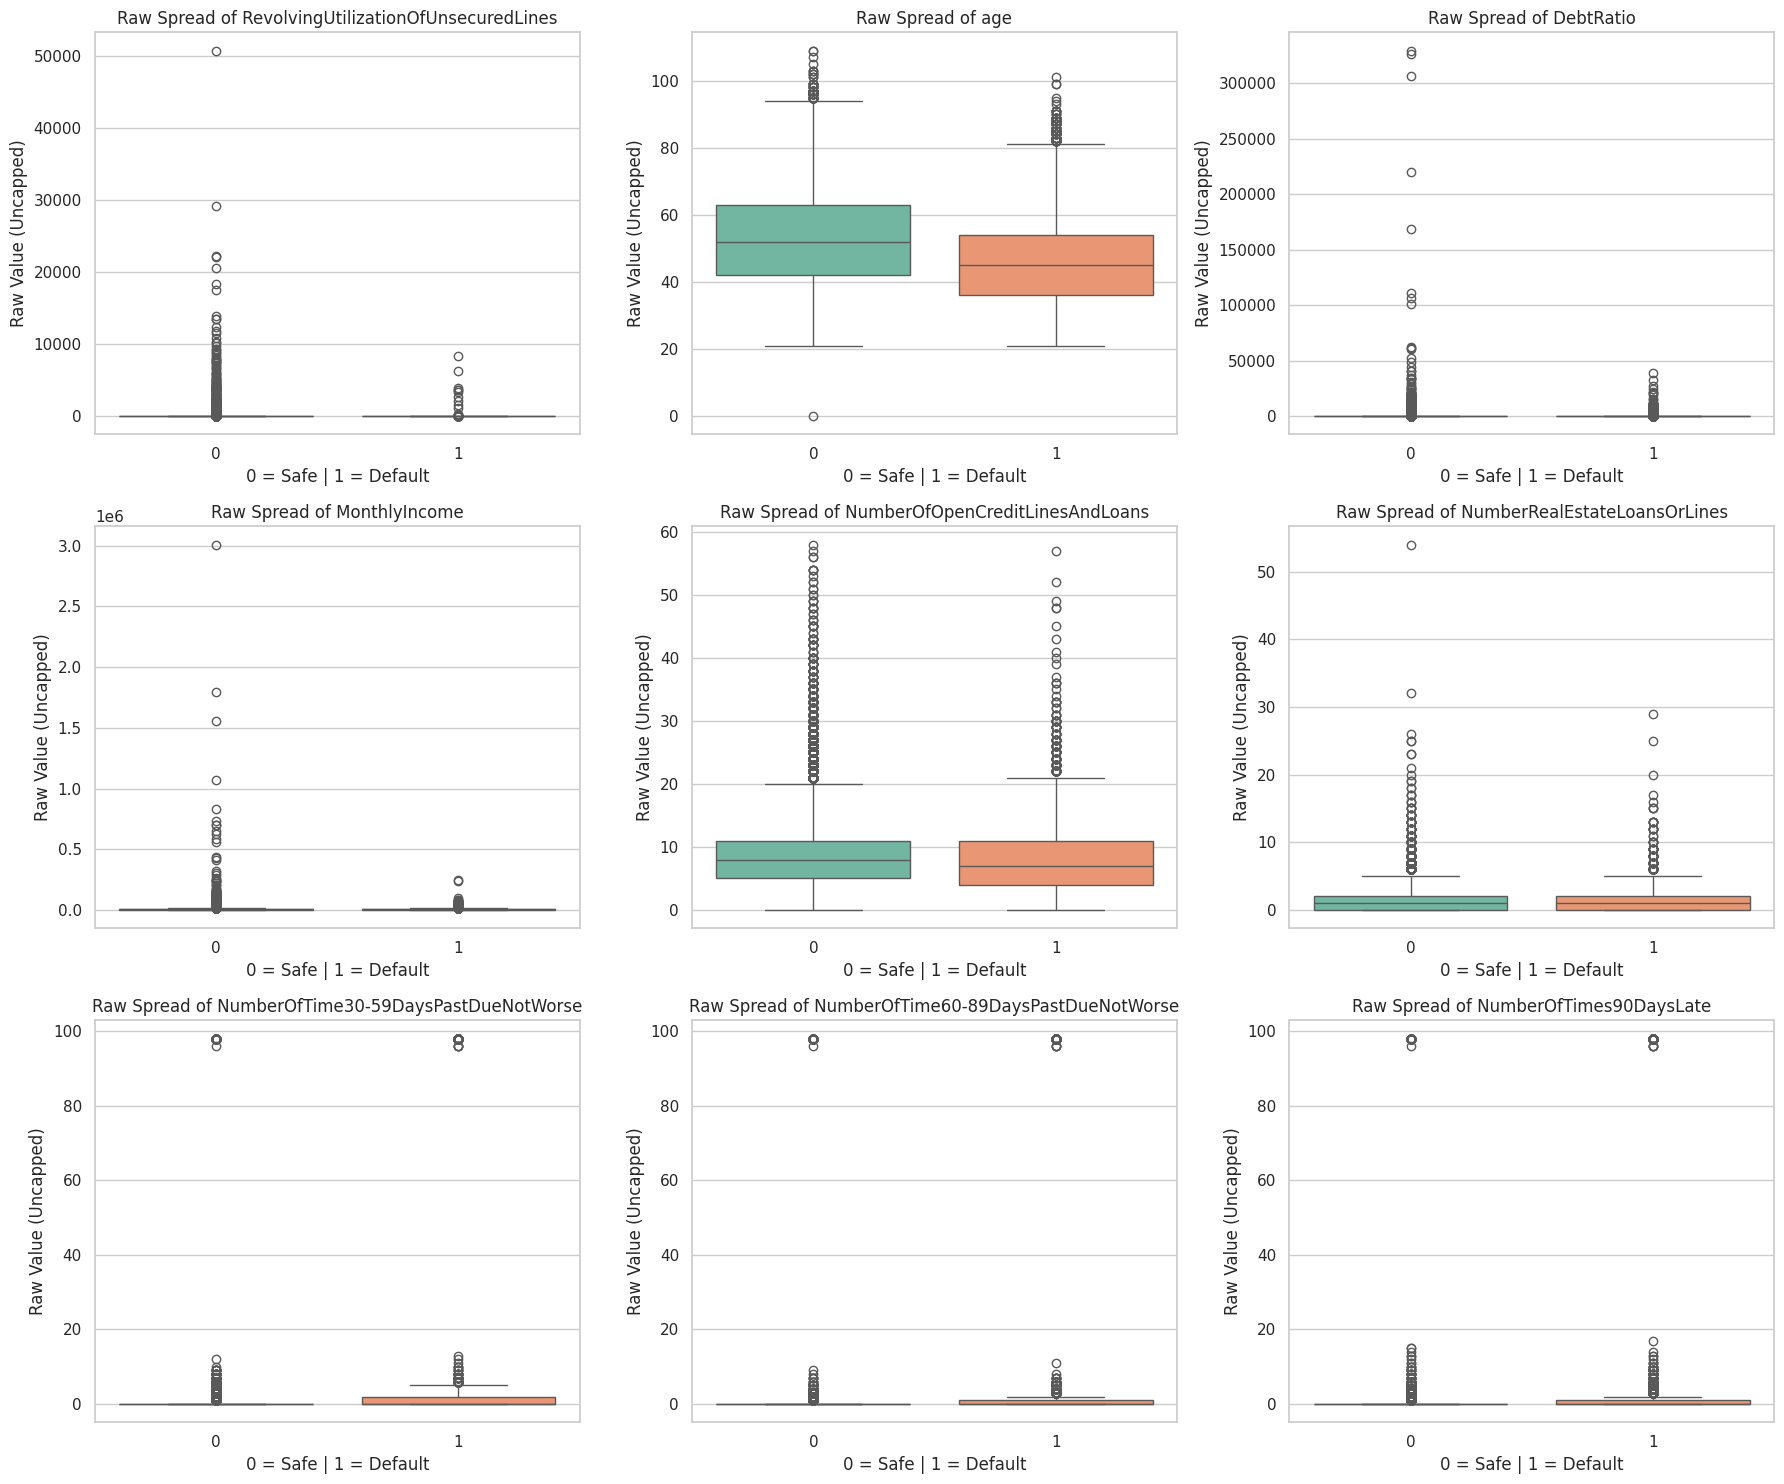

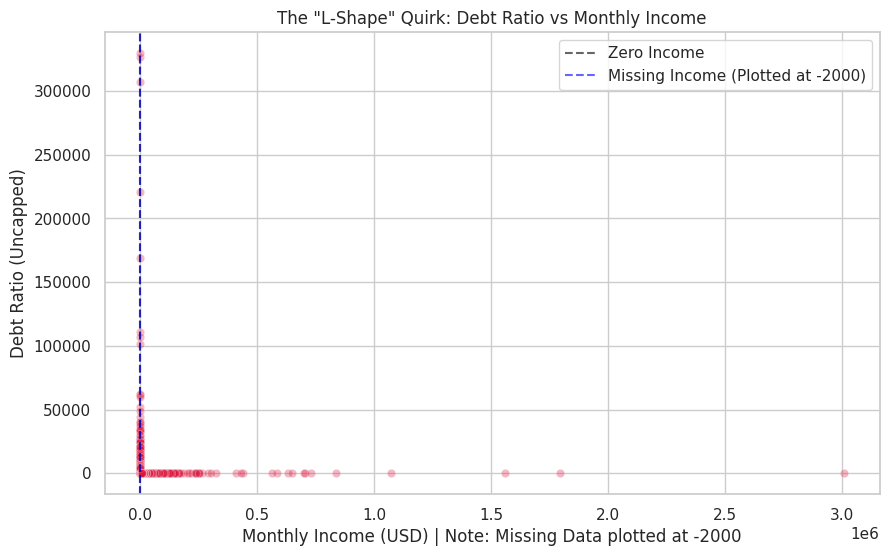

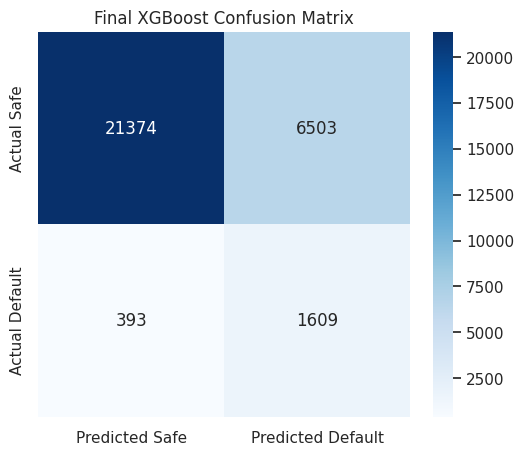

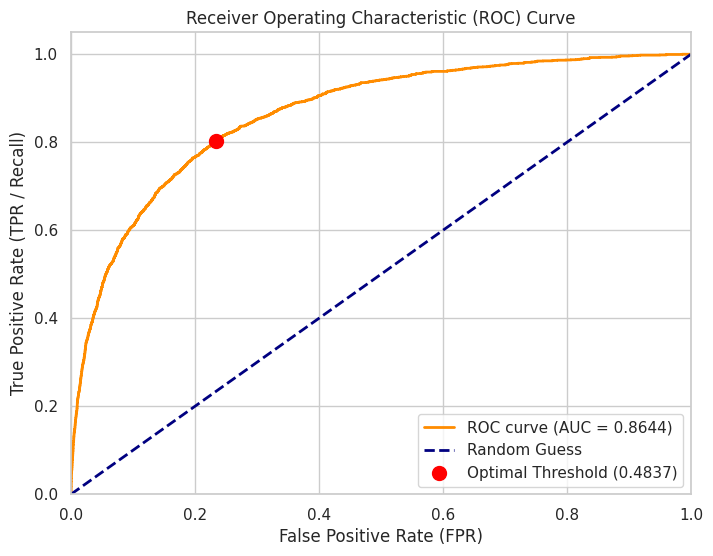

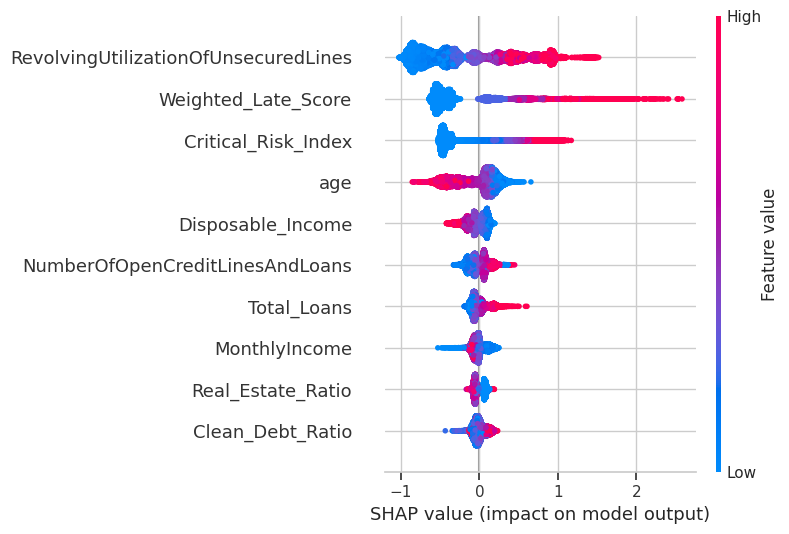

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score,
                             recall_score, f1_score, confusion_matrix, roc_curve)

# Set visual style
sns.set_theme(style="whitegrid")

# ==========================================
# 0. LOAD DATA & DROP DUPLICATES 📥
# ==========================================
df = pd.read_csv('cs-training.csv', index_col=0)

initial_shape = df.shape
df = df.drop_duplicates()
print(f"✅ Dropped {initial_shape[0] - df.shape[0]} duplicate rows.")

# ==========================================
# 1A. INITIAL EDA & TARGET DISTRIBUTION 📊
# ==========================================
print("\n========== 📊 INITIAL DATA HEALTH CHECK ==========")
print(f"Missing Values:\n{df.isnull().sum()}\n")

default_rate = df['SeriousDlqin2yrs'].mean()
print(f"Dataset Imbalance: {default_rate:.2%} are Defaulters.")

plt.figure(figsize=(6, 4))
sns.countplot(x='SeriousDlqin2yrs', data=df, palette='viridis')
plt.title('Distribution of Defaulters (Target Variable)')
plt.savefig('target_distribution.png')

# ==========================================
# 1B. EDA: RAW FEATURE RANGES & OUTLIERS 📊
# ==========================================
plt.figure(figsize=(18, 15))
features_to_plot = [
    'RevolvingUtilizationOfUnsecuredLines', 'age', 'DebtRatio',
    'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberRealEstateLoansOrLines',
    'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate'
]

for i, col in enumerate(features_to_plot, 1):
    plt.subplot(3, 3, i)
    plot_data = df.dropna(subset=[col])
    sns.boxplot(data=plot_data, x='SeriousDlqin2yrs', y=col, palette='Set2')
    plt.title(f'Raw Spread of {col}')
    plt.xlabel('0 = Safe | 1 = Default')
    plt.ylabel('Raw Value (Uncapped)')

plt.tight_layout()
plt.savefig('raw_feature_ranges_boxplot_xgb.png')

# ==========================================
# 1C. EDA: THE "L-SHAPE" DEBT RATIO QUIRK 📊
# ==========================================
plt.figure(figsize=(10, 6))
plot_df = df[['MonthlyIncome', 'DebtRatio']].copy()
plot_df['MonthlyIncome'] = plot_df['MonthlyIncome'].fillna(-2000)

sns.scatterplot(x='MonthlyIncome', y='DebtRatio', data=plot_df, alpha=0.3, color='crimson')
plt.axvline(x=0, color='black', linestyle='--', alpha=0.6, label='Zero Income')
plt.axvline(x=-2000, color='blue', linestyle='--', alpha=0.6, label='Missing Income (Plotted at -2000)')

plt.title('The "L-Shape" Quirk: Debt Ratio vs Monthly Income')
plt.xlabel('Monthly Income (USD) | Note: Missing Data plotted at -2000')
plt.ylabel('Debt Ratio (Uncapped)')
plt.legend()
plt.savefig('l_shape_quirk.png')

# ==========================================
# 2. DATA CLEANING (SYSTEM ERRORS) 🧹
# ==========================================
late_cols = ['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate']
for col in late_cols:
    valid_median = df.loc[df[col] < 96, col].median()
    df.loc[df[col] >= 96, col] = valid_median

# ==========================================
# 3. SMART SPLITTER & IMPUTER 🧠
# ==========================================
total_defaults = (df['SeriousDlqin2yrs'] == 1).sum()
req_test_defaults = int(np.ceil(0.2 * total_defaults))
req_test_good = int(np.ceil(0.2 * (df['SeriousDlqin2yrs'] == 0).sum()))

clean_df = df.dropna()

if clean_df[clean_df['SeriousDlqin2yrs'] == 1].shape[0] >= req_test_defaults:
    print("✅ Smart Splitter: Building Test Set from pure data.")
    test_df = pd.concat([
        clean_df[clean_df['SeriousDlqin2yrs'] == 1].sample(n=req_test_defaults, random_state=42),
        clean_df[clean_df['SeriousDlqin2yrs'] == 0].sample(n=req_test_good, random_state=42)
    ])
    train_df = df.drop(test_df.index)

    train_df['MonthlyIncome'] = train_df['MonthlyIncome'].fillna(
        train_df.groupby('NumberOfDependents')['MonthlyIncome'].transform('median')
    )
    train_df['MonthlyIncome'] = train_df['MonthlyIncome'].fillna(train_df['MonthlyIncome'].median())
    train_df['NumberOfDependents'] = train_df['NumberOfDependents'].fillna(train_df['NumberOfDependents'].median())
else:
    df_imputed = df.copy()
    df_imputed['MonthlyIncome'] = df_imputed['MonthlyIncome'].fillna(df_imputed['MonthlyIncome'].median())
    df_imputed['NumberOfDependents'] = df_imputed['NumberOfDependents'].fillna(df_imputed['NumberOfDependents'].median())
    train_df, test_df = train_test_split(df_imputed, test_size=0.2, stratify=df_imputed['SeriousDlqin2yrs'], random_state=42)

# ==========================================
# 4. XGBOOST FEATURE ENGINEERING (WITH AGE ENG) 🛠️
# ==========================================
def engineer_features(data):
    d = data.copy()

    # 1. Fix Age 0 Typo
    d.loc[d['age'] < 18, 'age'] = d['age'].median()

    # 2. Cap Runaway Utilization
    d['RevolvingUtilizationOfUnsecuredLines'] = np.clip(d['RevolvingUtilizationOfUnsecuredLines'], 0, 2.0)

    # 3. Reverse-Engineer DebtRatio
    d['True_Monthly_Debt'] = np.where(d['MonthlyIncome'] <= 1, d['DebtRatio'], d['DebtRatio'] * d['MonthlyIncome'])
    safe_income = np.where(d['MonthlyIncome'] <= 1, 1, d['MonthlyIncome'])
    d['Clean_Debt_Ratio'] = d['True_Monthly_Debt'] / safe_income

    # 4. Behavioral Engineering
    d['Weighted_Late_Score'] = (1 * d['NumberOfTime30-59DaysPastDueNotWorse']) + (2 * d['NumberOfTime60-89DaysPastDueNotWorse']) + (3 * d['NumberOfTimes90DaysLate'])
    d['Critical_Risk_Index'] = d['RevolvingUtilizationOfUnsecuredLines'] * d['Weighted_Late_Score']
    d['Total_Loans'] = d['NumberOfOpenCreditLinesAndLoans'] + d['NumberRealEstateLoansOrLines']
    d['Real_Estate_Ratio'] = np.where(d['Total_Loans'] > 0, d['NumberRealEstateLoansOrLines'] / d['Total_Loans'], -1)
    d['Disposable_Income'] = d['MonthlyIncome'] - d['True_Monthly_Debt']

    # 5. Age Engineering (INCLUDED)
    d['Income_to_Age_Ratio'] = d['MonthlyIncome'] / d['age']
    d['Young_Homeowner'] = np.where((d['age'] < 30) & (d['NumberRealEstateLoansOrLines'] > 0), 1, 0)

    return d.drop(columns=['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 'DebtRatio'])

train_df_eng = engineer_features(train_df)
test_df_eng = engineer_features(test_df)

X_train = train_df_eng.drop('SeriousDlqin2yrs', axis=1)
y_train = train_df_eng['SeriousDlqin2yrs']
X_test = test_df_eng.drop('SeriousDlqin2yrs', axis=1)
y_test = test_df_eng['SeriousDlqin2yrs']

imbalance_ratio = (y_train == 0).sum() / (y_train == 1).sum()

# ==========================================
# 5. OPTUNA BAYESIAN TUNING 🤖
# ==========================================
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 400),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'scale_pos_weight': imbalance_ratio,
        'random_state': 42,
        'eval_metric': 'auc',
        'n_jobs': -1
    }
    model = xgb.XGBClassifier(**param)
    return cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc').mean()

print("\n⏳ Running Bayesian Optimization (Optuna)...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)

best_model = xgb.XGBClassifier(**study.best_params, scale_pos_weight=imbalance_ratio, random_state=42)
best_model.fit(X_train, y_train)

# ==========================================
# 6. EVALUATION & METRICS 🏆
# ==========================================
y_probs = best_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_probs)

fpr_c, tpr_c, thresh = roc_curve(y_test, y_probs)
opt_idx = np.argmax(tpr_c - fpr_c)
best_t = thresh[opt_idx]

y_pred = (y_probs >= best_t).astype(int)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
fpr_val = fp / (fp + tn)

print("\n========== 🏆 FULL MODEL EVALUATION ==========")
print(f"AUC Score:             {auc:.4f}")
print(f"Accuracy:              {acc:.4f}")
print(f"Precision:             {prec:.4f}")
print(f"Recall (TPR):          {rec:.4f}")
print(f"F1-Score:              {f1:.4f}")
print(f"False Alarm Rate (FPR):{fpr_val:.4f}")

plt.figure(figsize=(6, 5))
sns.heatmap([[tn, fp], [fn, tp]], annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Safe', 'Predicted Default'],
            yticklabels=['Actual Safe', 'Actual Default'])
plt.title('Final XGBoost Confusion Matrix')
plt.savefig('final_confusion_matrix_xgb.png')

plt.figure(figsize=(8, 6))
plt.plot(fpr_c, tpr_c, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.scatter(fpr_val, rec, color='red', s=100, zorder=5, label=f'Optimal Threshold ({best_t:.4f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR / Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('roc_curve_xgboost.png')

# ==========================================
# 7. BUSINESS IMPACT & SHAP 💰🔍
# ==========================================
results = X_test.copy()
results['Actual_Default'] = y_test
results['Prob_Default'] = y_probs
results['Prediction'] = y_pred

results['Estimated_Loan'] = results['MonthlyIncome'] * 3
results['Recovery_Rate'] = np.where(results['Total_Loans'] > results['NumberOfOpenCreditLinesAndLoans'], 0.50, 0.10)

def calculate_net_impact(row):
    loan = row['Estimated_Loan']
    if row['Actual_Default'] == 0 and row['Prediction'] == 0: return loan * 0.15
    elif row['Actual_Default'] == 0 and row['Prediction'] == 1: return -(loan * 0.15)
    elif row['Actual_Default'] == 1 and row['Prediction'] == 1: return 0
    elif row['Actual_Default'] == 1 and row['Prediction'] == 0: return -(loan * (1 - row['Recovery_Rate']))
    return 0

results['Net_Result'] = results.apply(calculate_net_impact, axis=1)
total_economic_impact = results['Net_Result'].sum()

print("\n========== 💰 ECONOMIC IMPACT ==========")
print(f"TOTAL PROJECTED PROFIT:  ${total_economic_impact:,.2f}")
print(f"PROFIT PER APPLICANT:    ${total_economic_impact/len(results):,.2f}")

plt.figure()
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="dot", max_display=10, show=False)
plt.savefig('shap_summary.png', bbox_inches='tight')
print("✅ SHAP Plot Generated: 'shap_summary.png'")

# ==========================================
# 8. AGE BIAS AUDIT ⚖️
# ==========================================
results_bias = pd.DataFrame({'age': X_test['age'], 'pred': y_pred})
young_app = (results_bias[results_bias['age'] < 30]['pred'] == 0).mean()
senior_app = (results_bias[results_bias['age'] >= 30]['pred'] == 0).mean()

print("\n========== ⚖️ BIAS AUDIT ==========")
print(f"Young Approval Rate:  {young_app:.2%}")
print(f"Senior Approval Rate: {senior_app:.2%}")

disparate_impact = young_app / senior_app
print(f"Disparate Impact:     {disparate_impact:.4f}")

if disparate_impact < 0.8:
    print("🚨 ALERT: Model shows significant bias against young applicants!")
else:
    print("✅ Model passes the 80% fairness rule.")

# ==========================================
# 9. RISK TIER CATEGORIZATION 🚦
# ==========================================
high_risk_thresh = best_t
medium_risk_thresh = 0.15

def categorize_risk(prob):
    if prob >= high_risk_thresh:
        return "High Risk (Auto-Reject)"
    elif prob >= medium_risk_thresh:
        return "Medium Risk (Manual Review)"
    else:
        return "Low Risk (Auto-Approve)"

results['Risk_Tier'] = results['Prob_Default'].apply(categorize_risk)

tier_summary = results.groupby('Risk_Tier').agg(
    Total_Applicants=('Actual_Default', 'count'),
    Actual_Defaulters=('Actual_Default', 'sum'),
    Total_Profit=('Net_Result', 'sum')
).reset_index()

tier_summary['Total_Profit'] = tier_summary['Total_Profit'].apply(lambda x: f"${x:,.2f}")

print("\n========== 🚦 RISK TIER CATEGORIZATION ==========")
print(f"Low Risk (Auto-Approve):       0.00 to {medium_risk_thresh:.2f}")
print(f"Medium Risk (Manual Review):   {medium_risk_thresh:.2f} to {high_risk_thresh:.4f}")
print(f"High Risk (Auto-Reject):       > {high_risk_thresh:.4f}")
print("\n--- TIER IMPACT SUMMARY ---")
print(tier_summary.to_string(index=False))
print("=================================================")

[I 2026-02-19 03:21:20,363] A new study created in memory with name: no-name-8b87166f-06b2-4302-96de-51933511b14e


✅ Data Loaded. Shape: (149391, 11)
✅ Smart Splitter: Building Test Set from pure data.

⏳ Running Bayesian Optimization (Optuna)...


[I 2026-02-19 03:21:38,114] Trial 0 finished with value: 0.8582505110047242 and parameters: {'max_depth': 5, 'learning_rate': 0.10627206737177293, 'n_estimators': 269}. Best is trial 0 with value: 0.8582505110047242.
[I 2026-02-19 03:21:47,930] Trial 1 finished with value: 0.8650581670578689 and parameters: {'max_depth': 5, 'learning_rate': 0.0708813701814779, 'n_estimators': 152}. Best is trial 1 with value: 0.8650581670578689.
[I 2026-02-19 03:21:51,263] Trial 2 finished with value: 0.8661118801596474 and parameters: {'max_depth': 5, 'learning_rate': 0.03322669511782374, 'n_estimators': 127}. Best is trial 2 with value: 0.8661118801596474.
[I 2026-02-19 03:22:02,129] Trial 3 finished with value: 0.860027851804641 and parameters: {'max_depth': 6, 'learning_rate': 0.04309397871439461, 'n_estimators': 330}. Best is trial 2 with value: 0.8661118801596474.
[I 2026-02-19 03:22:12,742] Trial 4 finished with value: 0.8591159238892675 and parameters: {'max_depth': 5, 'learning_rate': 0.067775


========== 🏆 PERFORMANCE (ON PURE TEST SET) ==========
AUC Score: 0.8541
Optimal Threshold: 0.5345
Recall: 0.7483
F1-Score: 0.3399

💰 Total Economic Impact: $48,489,419.40

========== ⚖️ BIAS AUDIT ==========
Young Approval Rate (<30):  57.11%
Senior Approval Rate (30+): 78.47%
Disparate Impact Ratio:     0.7278
🚨 ALERT: Model shows significant bias against young applicants (Ratio < 0.8)

========== 🚦 RISK TIER SUMMARY ==========
Tier
Medium Risk (Manual Review)    13491
Low Risk (Auto-Approve)         9576
High Risk (Auto-Reject)         6812
Name: count, dtype: int64

                              Count  Defaulters       Profit
Tier                                                       
High Risk (Auto-Reject)       6812        1498 -13929097.95
Low Risk (Auto-Approve)       9576          81  31206772.65
Medium Risk (Manual Review)  13491         423  31211744.70


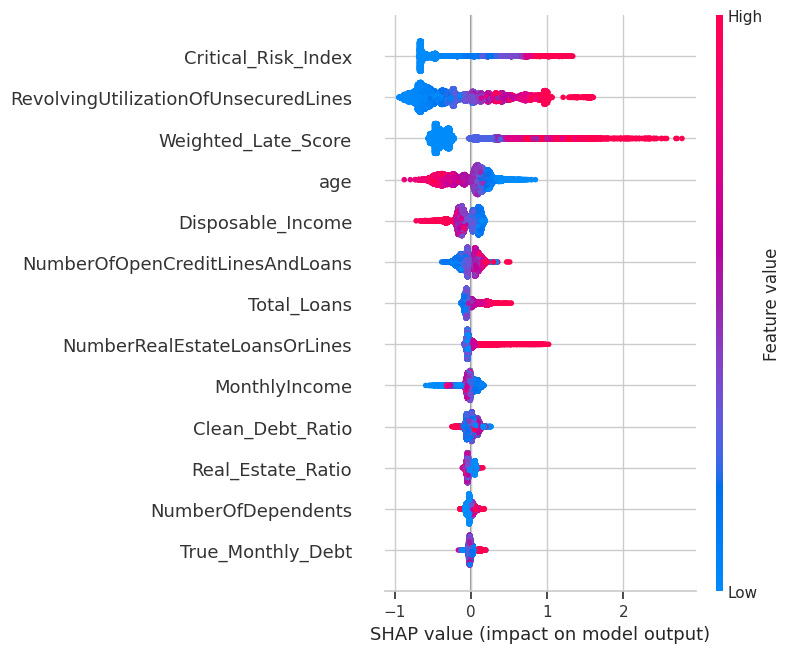

In [5]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score,
                             recall_score, f1_score, confusion_matrix, roc_curve)

# Set visual style
sns.set_theme(style="whitegrid")

# ==========================================
# 0. LOAD DATA & DROP DUPLICATES 📥
# ==========================================
df = pd.read_csv('cs-training.csv', index_col=0)
df = df.drop_duplicates()
print(f"✅ Data Loaded. Shape: {df.shape}")

# ==========================================
# 1. THE GOLD STANDARD SPLITTER 🧠
# ==========================================
# Step A: Identify "Pure" rows for the Test Set (No NaNs, No Age 0, No 98s)
is_pure = (df.notna().all(axis=1)) & \
          (df['age'] >= 18) & \
          (df['NumberOfTime30-59DaysPastDueNotWorse'] < 96) & \
          (df['NumberOfTime60-89DaysPastDueNotWorse'] < 96) & \
          (df['NumberOfTimes90DaysLate'] < 96)

pure_pool = df[is_pure]

# Step B: Stratified Sampling for Test Set (20%)
total_defaults_needed = int(np.ceil(0.2 * (df['SeriousDlqin2yrs'] == 1).sum()))
total_safe_needed = int(np.ceil(0.2 * (df['SeriousDlqin2yrs'] == 0).sum()))

if pure_pool[pure_pool['SeriousDlqin2yrs'] == 1].shape[0] >= total_defaults_needed:
    print("✅ Smart Splitter: Building Test Set from pure data.")
    test_df = pd.concat([
        pure_pool[pure_pool['SeriousDlqin2yrs'] == 1].sample(n=total_defaults_needed, random_state=42),
        pure_pool[pure_pool['SeriousDlqin2yrs'] == 0].sample(n=total_safe_needed, random_state=42)
    ])
    train_df = df.drop(test_df.index)
else:
    print("⚠️ Fallback: Not enough pure data. Using standard stratified split.")
    train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['SeriousDlqin2yrs'], random_state=42)

# ==========================================
# 2. IMPUTATION (NO NULLS) 🧹
# ==========================================
# We fill nulls in BOTH datasets to ensure feature engineering works smoothly
# Note: We calculate medians from TRAIN set only to avoid data leakage
income_median_train = train_df.groupby('NumberOfDependents')['MonthlyIncome'].transform('median')
global_income_median = train_df['MonthlyIncome'].median()
dependents_median = train_df['NumberOfDependents'].median()

# Apply to Train
train_df['MonthlyIncome'] = train_df['MonthlyIncome'].fillna(income_median_train)
train_df['MonthlyIncome'] = train_df['MonthlyIncome'].fillna(global_income_median)
train_df['NumberOfDependents'] = train_df['NumberOfDependents'].fillna(dependents_median)

# Apply to Test (using TRAIN statistics)
test_df['MonthlyIncome'] = test_df['MonthlyIncome'].fillna(global_income_median)
test_df['NumberOfDependents'] = test_df['NumberOfDependents'].fillna(dependents_median)

# ==========================================
# 3. XGBOOST FEATURE ENGINEERING 🛠️
# ==========================================
def engineer_features(data):
    d = data.copy()

    # 1. Fix Age 0 Typo
    d.loc[d['age'] < 18, 'age'] = d['age'].median()

    # 2. Cap Runaway Utilization
    d['RevolvingUtilizationOfUnsecuredLines'] = np.clip(d['RevolvingUtilizationOfUnsecuredLines'], 0, 2.0)

    # 3. Reverse-Engineer DebtRatio
    # Safe to do now since we filled MonthlyIncome
    d['True_Monthly_Debt'] = np.where(d['MonthlyIncome'] <= 1, d['DebtRatio'], d['DebtRatio'] * d['MonthlyIncome'])
    safe_income = np.where(d['MonthlyIncome'] <= 1, 1, d['MonthlyIncome'])
    d['Clean_Debt_Ratio'] = d['True_Monthly_Debt'] / safe_income

    # 4. Behavioral Engineering
    d['Weighted_Late_Score'] = (1 * d['NumberOfTime30-59DaysPastDueNotWorse']) + \
                               (2 * d['NumberOfTime60-89DaysPastDueNotWorse']) + \
                               (3 * d['NumberOfTimes90DaysLate'])
    d['Critical_Risk_Index'] = d['RevolvingUtilizationOfUnsecuredLines'] * d['Weighted_Late_Score']
    d['Total_Loans'] = d['NumberOfOpenCreditLinesAndLoans'] + d['NumberRealEstateLoansOrLines']
    d['Real_Estate_Ratio'] = np.where(d['Total_Loans'] > 0, d['NumberRealEstateLoansOrLines'] / d['Total_Loans'], -1)
    d['Disposable_Income'] = d['MonthlyIncome'] - d['True_Monthly_Debt']

    return d.drop(columns=['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 'DebtRatio'])

train_df_eng = engineer_features(train_df)
test_df_eng = engineer_features(test_df)

X_train = train_df_eng.drop('SeriousDlqin2yrs', axis=1)
y_train = train_df_eng['SeriousDlqin2yrs']
X_test = test_df_eng.drop('SeriousDlqin2yrs', axis=1)
y_test = test_df_eng['SeriousDlqin2yrs']

imbalance_ratio = (y_train == 0).sum() / (y_train == 1).sum()

# ==========================================
# 4. OPTUNA BAYESIAN TUNING 🤖
# ==========================================
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 400),
        'scale_pos_weight': imbalance_ratio,
        'random_state': 42,
        'eval_metric': 'auc',
        'n_jobs': -1
    }
    model = xgb.XGBClassifier(**param)
    return cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc').mean()

print("\n⏳ Running Bayesian Optimization (Optuna)...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)

best_model = xgb.XGBClassifier(**study.best_params, scale_pos_weight=imbalance_ratio, random_state=42)
best_model.fit(X_train, y_train)

# ==========================================
# 5. EVALUATION & OPTIMAL THRESHOLD 🏆
# ==========================================
y_probs = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
best_t = thresholds[np.argmax(tpr - fpr)]
y_pred = (y_probs >= best_t).astype(int)

print(f"\n========== 🏆 PERFORMANCE (ON PURE TEST SET) ==========")
print(f"AUC Score: {roc_auc_score(y_test, y_probs):.4f}")
print(f"Optimal Threshold: {best_t:.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")

# ==========================================
# 6. BUSINESS IMPACT & SHAP 💰🔍
# ==========================================
# SHAP Summary
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
plt.figure()
shap.summary_plot(shap_values, X_test, show=False)
plt.savefig('xgb_shap_summary.png', bbox_inches='tight')

# Business Impact Calculation
results = X_test.copy()
results['Actual'] = y_test
results['Prob'] = y_probs
results['Pred'] = y_pred

# Assume Average Loan is 3x Monthly Income
results['Loan_Amt'] = results['MonthlyIncome'] * 3

def calculate_profit(row):
    if row['Actual'] == 0 and row['Pred'] == 0: return row['Loan_Amt'] * 0.15 # Interest
    if row['Actual'] == 0 and row['Pred'] == 1: return -(row['Loan_Amt'] * 0.15) # Opportunity Loss
    if row['Actual'] == 1 and row['Pred'] == 0: return -row['Loan_Amt'] # Total Default Loss
    return 0

results['Impact'] = results.apply(calculate_profit, axis=1)
print(f"\n💰 Total Economic Impact: ${results['Impact'].sum():,.2f}")

# ==========================================
# 7. AGE BIAS AUDIT ⚖️
# ==========================================
# Re-attach 'age' from X_test to see who was approved/rejected
results_bias = pd.DataFrame({'age': X_test['age'], 'pred': y_pred})

# Calculate Approval Rate (Prediction = 0 means Approved/Safe)
young_app = (results_bias[results_bias['age'] < 30]['pred'] == 0).mean()
senior_app = (results_bias[results_bias['age'] >= 30]['pred'] == 0).mean()

print("\n========== ⚖️ BIAS AUDIT ==========")
print(f"Young Approval Rate (<30):  {young_app:.2%}")
print(f"Senior Approval Rate (30+): {senior_app:.2%}")

disparate_impact = young_app / senior_app
print(f"Disparate Impact Ratio:     {disparate_impact:.4f}")

if disparate_impact < 0.8:
    print("🚨 ALERT: Model shows significant bias against young applicants (Ratio < 0.8)")
else:
    print("✅ Model passes the 80% fairness rule.")

# ==========================================
# 8. RISK TIER CATEGORIZATION 🚦
# ==========================================
def get_tier(p):
    if p >= best_t: return "High Risk (Auto-Reject)"
    if p >= 0.15: return "Medium Risk (Manual Review)"
    return "Low Risk (Auto-Approve)"

results['Tier'] = results['Prob'].apply(get_tier)

print("\n========== 🚦 RISK TIER SUMMARY ==========")
print(results['Tier'].value_counts())

tier_summary = results.groupby('Tier').agg(
    Count=('Actual', 'count'),
    Defaulters=('Actual', 'sum'),
    Profit=('Impact', 'sum')
)
print("\n", tier_summary)